# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as colors

### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 3,
    "lines.markersize": 10,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

### Location

In [4]:
# workstation
#%cd /home/alamson/DATA/Chromatin/

# mnt
%cd /mnt/home/alamson/projects/DATA/Chromatin/

# ceph
#%cd /mnt/home/alamson/ceph/DATA/Chromatin/

/mnt/home/alamson/projects/DATA/Chromatin


# Functions

## Physical scale calculations

In [5]:
def get_drag_coeff(bead_rad, viscosity):
    ''' Dimensions of Length/(Time*Force) = Length^2/(Time*Energy)'''
    return 6.*np.pi*viscosity*bead_rad

print(get_drag_coeff(.01, 1000))

188.4955592153876


In [6]:
def get_char_time(bead_diam, viscosity, kT=.00411):
    ''' Characteristic time i.e. the time it takes for bead to diffuse its diameter '''
    return 4.*np.pi*viscosity*np.power(bead_diam, 3)/kT

print(get_char_time(.01, 1000.)) # in sec

3.0575110983842273


In [7]:
def get_poly_diffuse_dist(time, n_beads, bead_diam, viscosity, frac_dim=.5, kT=.00411 ):
    return np.sqrt(kT*time/(np.pi*viscosity*bead_diam*np.power(n_beads, frac_dim)))

print(get_poly_diffuse_dist(100*3600, 512, .02, 1000.)) # In microns

1.0201516513282987


In [8]:
def get_rouse_time(n_beads, bead_diam, viscosity, kT=.00411 ):
    return 2.*viscosity*np.power(bead_diam,3)*n_beads*n_beads/(3*np.pi*kT)

print(get_rouse_time(512, .02, 1000.)/3600) # In hours

30.077688313513075


In [9]:
def get_link_relax_time(bead_rad, viscosity, spring_const):
    return (6.*np.pi*viscosity*bead_rad)/spring_const

print(get_link_relax_time(.01, 1000, 3650)) # in seconds

0.05164261896311989


# Test graphs

In [10]:
data_path = Path("21-04-23_AMchr1_RS_line512_pin/")

## Proximity

In [11]:
def gauss_weighted_contact(sep_mat, sigma=.020):
    return np.exp(-np.power(sep_mat,2)/(2.*(sigma*sigma)))

def log_gauss_weighted_contact(sep_mat, sigma=.020):
    return -np.power(sep_mat,2)/(2.*(sigma*sigma))/np.log(10)


In [12]:
#test_com_arr = np.asarray([[0,0,0],[1,0,0],[2,0,0],[5,0,0],[0,0,1]])
#test_sep_mat = make_separation_mat(test_com_arr)
#print(test_sep_mat)

## Energy

In [13]:
def get_energy_arrays(h5_data, write=False):
    """TODO: Docstring for get_mean_energy_array.

    @param h5_data HDF5 data file to analyze with all raw data about filaments
    @param write If true, will write data directly to the analysis group in
                 the h5_data file.
    @return: TODO

    """
    sy_dat = h5_data['raw_data']['sylinders'][...]
    params = yaml.safe_load(h5_data.attrs['RunConfig'])
    k_spring = params['linkKappa']
    kbt = params['KBT']
    rest_length = params['linkGap'] + sy_dat[1:, 1, :] + sy_dat[:-1, 1, :]
    sep_vec = sy_dat[1:, 2:5, :] - sy_dat[:-1, 5:8, :]

    sep_mag = np.linalg.norm(sep_vec, axis=1)

    energy_arr = .5 * k_spring * np.power(sep_mag - rest_length, 2)
    mean_energy = np.mean(energy_arr, axis=0)
    sem_energy = stats.sem(energy_arr, axis=0)
    expt_energy = kbt * (.5 - 1./(1. + (k_spring*rest_length[0,0]*rest_length[0,0]/kbt)))
    if write:
        energy_dset = h5_data['analysis'].create_dataset(
            'energy', data=np.stack(mean_energy, std_energy))
        energy_dset.attrs['nsylinders'] = energy_arr.shape[0]
    return mean_energy, sem_energy, expt_energy


StopIteration: 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


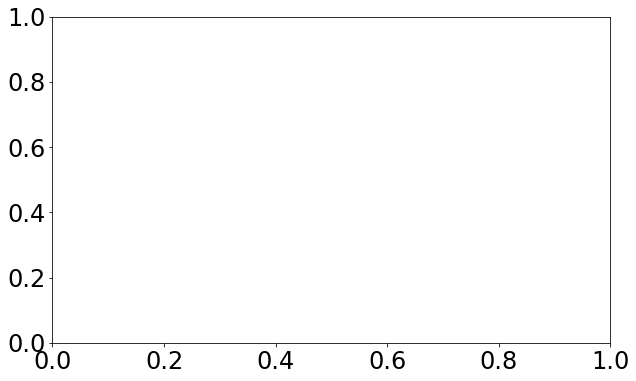

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:

    mean_energy, sem_energy, expt_energy = get_energy_arrays(h5_data)
    time = h5_data['time'][...]

    # print(sy_dat)
    #end_end_sep = np.linalg.norm(sy_dat[-1,5:8,:] - sy_dat[0,5:8,:],axis=0)
    # print(end_end_sep)
    ax.plot(time, mean_energy, label="Self-avoidng")
    ax.fill_between(time, (mean_energy-sem_energy), (mean_energy+sem_energy), color='blue', alpha=0.1)
    
    energy_mean = mean_energy[int(mean_energy.size * .75):].mean()
    print(energy_mean)
    print(expt_energy)
    
    
    ax.axhline(energy_mean, color='r')
    ax.set_ylabel(r"Mean spring energy (pN$\cdot \mu$m)")
    ax.set_xlabel("Time (sec)")


## Overlap

In [ ]:
def get_sep_hist(h5_data, nbins=100, ss_ind=0, write=False):
    """Returns a 2D histogram of bead separations vs time

    @param h5_data TODO
    @return: TODO

    """
    params = yaml.safe_load(h5_data.attrs['RunConfig'])
    hist_min = params['sylinderDiameter'] * .8
    hist_max = params['sylinderDiameter'] * 1.2

    dist_hist = []
    dist_mat = get_sep_dist_mat(h5_data, ss_ind)

    for i in range(dist_mat.shape[-1]):
        hist, bin_edges = np.histogram(
            dist_mat[:, :, i].flatten(), nbins, range=(hist_min, hist_max))
        dist_hist += [hist * .5]

    return dist_hist, bin_edges


def get_sep_dist_mat(h5_data, ss_ind=0, write=False):
    """Returns a NxNxM matrix of NXN filaments distances over M time points
    starting at ss_ind time point.

    @param h5_data TODO
    @return: TODO

    """
    sy_dat = h5_data['raw_data']['sylinders'][...]

    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    dist_mat = np.linalg.norm((com_arr[:, np.newaxis, :, ss_ind:] -
                               com_arr[np.newaxis, :, :, ss_ind:]),
                              axis=2)

    return dist_mat


def get_overlap_arrs(dist_mat, sy_diam):
    """Returns a NxNxM matrix of NXN filaments distances over M time points
    starting at ss_ind time point.

    @param h5_data TODO
    @return: TODO

    """
    is_overlap_mat = (dist_mat < sy_diam).astype(int)
    num_overlap = .5 * (is_overlap_mat.sum(axis=(0, 1))
                        - dist_mat.shape[0])  # remove self-overlap
    overlap_dist_mat = np.einsum('ijk, ijk -> ijk', dist_mat, is_overlap_mat)
    avg_overlap_arr = (.5*overlap_dist_mat.sum(axis=(0, 1))) / num_overlap
    min_overlap_arr = np.ma.masked_values(overlap_dist_mat, 0).min(axis=(0, 1))

    return num_overlap, avg_overlap_arr, min_overlap_arr




### Testing overlap

In [15]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
#     diff_hist, bin_edges = get_sep_hist(h5_data, ss_ind=-10)
#     time = h5_data['time'][...]

#     c = ax.pcolorfast(bin_edges, time[-10:], diff_hist)
#     fig.colorbar(c, ax=ax, label=r'Pairs')
#     ax.set_xlabel(r"Bead COM separation ($\mu$m)")
#     ax.set_ylabel("Time (sec)")


In [16]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
#     dist_mat = get_sep_dist_mat(h5_data, -10)
#     time_arr = h5_data['time'][...]
#     params = yaml.safe_load(h5_data.attrs['RunConfig'])
#     sy_diam = params['sylinderDiameter']
    
#     overlap_arr,_,_ = get_overlap_arrs(dist_mat, sy_diam)
#     ax.plot(time_arr[-10:], overlap_arr)
    
    

In [17]:
# data_path_h2 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt2")
# ss_ind = -100
# with h5py.File(next(data_path_h2.glob('*.h5')), 'r+') as h5_data:
#     dist_mat_h2 = get_sep_dist_mat(h5_data, ss_ind)

In [18]:
# fig, ax = plt.subplots(2, 1, figsize=(10, 14))
# #data_path_h1 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt2")

# with h5py.File(next(data_path_h2.glob('*.h5')), 'r+') as h5_data:
#     time_arr = h5_data['time'][...]
#     params = yaml.safe_load(h5_data.attrs['RunConfig'])
#     sy_diam = params['sylinderDiameter']
    
#     overlap_arr, avg_overlap_arr, min_overlap_arr = get_overlap_arrs(dist_mat_h2, sy_diam)
#     ax[0].plot(time_arr[ss_ind:], overlap_arr)
#     ax[1].plot(time_arr[ss_ind:], avg_overlap_arr,label='avg')
#     ax[1].plot(time_arr[ss_ind:], min_overlap_arr, label='min')
#     ax[1].legend()
    

In [22]:
# data_path_h1 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt1")
# ss_ind = -100
# with h5py.File(next(data_path_h1.glob('*.h5')), 'r+') as h5_data:
#     dist_mat_h1 = get_sep_dist_mat(h5_data, ss_ind)

In [23]:
# fig, ax = plt.subplots(2, 1, figsize=(10, 14))
# #data_path_h1 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt2")

# with h5py.File(next(data_path_h1.glob('*.h5')), 'r+') as h5_data:
#     time_arr = h5_data['time'][...]
#     params = yaml.safe_load(h5_data.attrs['RunConfig'])
#     sy_diam = params['sylinderDiameter']
    
#     overlap_arr, avg_overlap_arr, min_overlap_arr = get_overlap_arrs(dist_mat_h1, sy_diam)
#     ax[0].plot(time_arr[ss_ind:], overlap_arr)
#     ax[1].plot(time_arr[ss_ind:], sy_diam - avg_overlap_arr,label='avg')
#     ax[1].plot(time_arr[ss_ind:], sy_diam - min_overlap_arr, label='max')
#     ax[1].legend()
#     print(f'mean avg_overlap: {sy_diam - avg_overlap_arr.mean()}, $\pm$ {stats.sem(avg_overlap_arr)}')
    

In [24]:
# data_path_h_5 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt0.5")
# ss_ind = -100
# with h5py.File(next(data_path_h_5.glob('*.h5')), 'r+') as h5_data:
#     dist_mat_h_5 = get_sep_dist_mat(h5_data, ss_ind)

In [25]:
# fig, ax = plt.subplots(2, 1, figsize=(10, 14))
# #data_path_h1 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt2")

# with h5py.File(next(data_path_h_5.glob('*.h5')), 'r+') as h5_data:
#     time_arr = h5_data['time'][...]
#     params = yaml.safe_load(h5_data.attrs['RunConfig'])
#     sy_diam = params['sylinderDiameter']
    
#     overlap_arr, avg_overlap_arr, min_overlap_arr = get_overlap_arrs(dist_mat_h_5, sy_diam)
#     ax[0].plot(time_arr[ss_ind:], overlap_arr)
#     ax[1].plot(time_arr[ss_ind:], sy_diam - avg_overlap_arr,label='avg')
#     ax[1].plot(time_arr[ss_ind:], sy_diam - min_overlap_arr, label='max')
#     ax[1].legend()
#     print(f"mean avg_overlap: {np.ma.fix_invalid(sy_diam - avg_overlap_arr,fill_value=0).mean()}, $\pm$ {stats.sem(np.ma.fix_invalid(avg_overlap_arr,np.nan))}")
    

In [26]:
# print(f"mean avg_overlap: {np.ma.fix_invalid(sy_diam - avg_overlap_arr,fill_value=0).mean()}, $\pm$ {stats.sem(np.ma.fix_invalid(avg_overlap_arr,fill_value=0))}")

In [28]:
# data_path_h_2 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt0.2")
# ss_ind = -100
# with h5py.File(next(data_path_h_2.glob('*.h5')), 'r+') as h5_data:
#     dist_mat_h_2 = get_sep_dist_mat(h5_data, ss_ind)

In [ ]:
# fig, ax = plt.subplots(2, 1, figsize=(10, 14))
# #data_path_h1 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt2")

# with h5py.File(next(data_path_h_2.glob('*.h5')), 'r+') as h5_data:
#     time_arr = h5_data['time'][...]
#     params = yaml.safe_load(h5_data.attrs['RunConfig'])
#     sy_diam = params['sylinderDiameter']
    
#     overlap_arr, avg_overlap_arr, min_overlap_arr = get_overlap_arrs(dist_mat_h_2, sy_diam)
#     ax[0].plot(time_arr[ss_ind:], overlap_arr)
#     ax[1].plot(time_arr[ss_ind:], sy_diam - avg_overlap_arr,label='avg')
#     ax[1].plot(time_arr[ss_ind:], sy_diam - min_overlap_arr, label='max')
#     ax[1].legend()
#     print(f"mean avg_overlap: {np.ma.fix_invalid(sy_diam - avg_overlap_arr,fill_value=0).mean()}, $\pm$ {stats.sem(np.ma.fix_invalid(avg_overlap_arr,fill_value=0))}")
    

## Rouse modes

In [19]:
def get_rouse_modes_at_t(pos_arr, nmodes=20):
    """TODO: Docstring for get_rouse_modes.

    @param sphere_dat TODO
    @param nmodes TODO
    @return: TODO

    """
    modes = []
    pos_0 = pos_arr[0]
    nbeads = pos_arr.shape[0]
    
    rel_pos_arr = (pos_arr - pos_0)[:-1]
    n_arr = np.arange(nbeads-1) + .5

    for k in range(nmodes):
        cos_arr = np.cos(np.pi*n_arr*float(k/nbeads))
        modes += [np.sum(rel_pos_arr*cos_arr[:,np.newaxis], axis=0)]

    return np.asarray(modes) / (nbeads)

def get_rouse_modes(pos_mat, nmodes=20):
    """TODO: Docstring for get_rouse_modes.

    @param sphere_dat TODO
    @param nmodes TODO
    @return: TODO

    """
    nsteps = pos_mat.shape[-1]
    mode_arr = np.zeros((nmodes, 3, nsteps))
    for i in range(nsteps):
        mode_arr[:, :, i] = get_rouse_modes_at_t(pos_mat[:, :, i], nmodes)

    return mode_arr

def get_rouse_mode_corr(mode_mat):
    """TODO: Docstring for get_rouse_modes.

    @param mode_mat TODO
    @return: TODO

    """
    nsteps = mode_mat.shape[-1]
    nmodes = mode_mat.shape[0]
    mode_corr = np.zeros((nmodes, nsteps))
    print(mode_corr.shape)

    for t in range(nsteps):
        for j in range(nsteps - t):
            mode_corr[:, t] += np.einsum('ij,ij->i',mode_mat[:, :, t + j],
                                      mode_mat[:, :, j])
        mode_corr[:, t] /= (nsteps - t)

    return mode_corr

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def get_fast_rouse_mode_corr(mode_mat):
    nsteps = mode_mat.shape[-1]
    n = next_pow_two(nsteps)

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fftn(mode_mat, s=[2 * n], axes=[-1])
    mode_corr = np.fft.ifftn(np.einsum('ijk,ijk->ik', f,
                                      np.conjugate(f)), 
                                       axes=[-1])[:nsteps].real
    
    mode_corr /= 4 * n
    return mode_corr

def make_rouse_analysis_plots(
        time_arr, mode_mat, nbeads, nmodes=20, max_ind=-1):
    fig, ax = plt.subplots(1, 2, figsize=(14, 8))

    # nbeads = com_arr.shape[0]

    #mode_corr = get_rouse_mode_corr(mode_mat)
    mode_corr = get_fast_rouse_mode_corr(mode_mat)
    mode_arr = np.arange(nmodes)

    ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e5)
    ax[0].loglog(mode_arr / nbeads, nbeads * mode_corr[:, 0])

    for k in range(nmodes):
        ax[1].loglog(np.power(k / nbeads, 2) * time_arr[:max_ind],
                     -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')

    ax[1].loglog(time_arr[:max_ind] / nbeads, 10.*time_arr[:max_ind])

    ax[0].set_xlabel(r'Mode index ($k/N_b$)')
    ax[0].set_ylabel('Mode amplitude correlation\n' + r'($N_bX_{kk}(0)$)')

    ax[1].set_xlabel(r'Time ($(k/N_b)^2t$)')
    ax[1].set_ylabel(r'$-\ln[X_{kk}(t)/X_{kk}(0)]$')

    fig.tight_layout()
    return fig, ax



In [20]:
data_path = Path("21-04-29_AMchr1_RS_line512_lo0/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)

StopIteration: 

In [21]:
get_fast_rouse_mode_corr(mode_mat)

NameError: name 'mode_mat' is not defined

In [22]:
data_path_line = Path("21-04-23_AMchr1_RS_line512_scan5.1_dt.001-.1/simulations/dt0.010/")
with h5py.File(next(data_path_line.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    sy_dat = h5_data['raw_data']['sylinders'][...]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)


StopIteration: 

In [291]:
#make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

In [292]:
#make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

## Auto-correlation function

In [23]:
def autocorr_bead_pos(com_arr, ignore_id=None):
    """Find the autocorrelation function for bead positions

    @param com_arr TODO
    @param ignore_id TODO
    @return: TODO

    """
   
    #com_rel_arr = com_arr - com_arr.mean(axis=-1)[:, :, np.newaxis]
    com_rel_arr = com_arr[...]

    if ignore_id is not None:
        com_rel_arr = np.delete(com_rel_arr, ignore_id, axis=0)
    nsteps = com_rel_arr.shape[-1]
    nbeads = com_rel_arr.shape[0]
    auto_corr = np.zeros((nbeads, nsteps))
    for t in range(nsteps):
        for j in range(nsteps - t):
            auto_corr[:, t] += np.einsum('ij,ij->i', com_rel_arr[:, :, t + j],
                                         com_rel_arr[:, :, j])
        auto_corr[:, t] /= (nsteps - t)
    
    return auto_corr


/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  


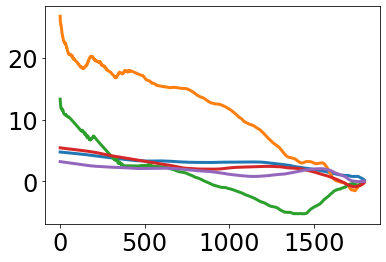

In [35]:
data_path = Path("21-04-23_AMsph512/")
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    acf = autocorr_bead_pos(com_arr, [0,-1])
    for i in range(95,100):
        _ = plt.plot(acf[i])

## Radial distribution from pin

In [30]:
def distr_hists(pos_mat, free_frac_chain=.5, rel_ind=0, nbins=100, hist_max=1):
    """TODO: Docstring for radial_distr.
    @param pos_mat TODO
    @param free_frac_chain TODO
    @param rel_ind TODO
    @param nbins TODO
    @return: TODO
    """
    nbeads = pos_mat.shape[0]
    ind = int(nbeads * free_frac_chain)


    rel_vec_arr = pos_mat[ind, :, :] - pos_mat[rel_ind, :, :]
    dist_arr = np.linalg.norm(rel_vec_arr, axis=0)

    dist_hist, dist_bin_edges = np.histogram(dist_arr, nbins, range=[0, hist_max], density=True)
    z_rho_hist, rho_bin_edges, z_bin_edges = np.histogram2d(
        np.linalg.norm(rel_vec_arr[:-1, :], axis=0), rel_vec_arr[-1, :], 
        int(nbins/2), range=[[0, hist_max], [-hist_max, hist_max]], density=True)

    return ((dist_hist, dist_bin_edges),
            (z_rho_hist, rho_bin_edges, z_bin_edges))

def total_distr_hists(pos_mat, rel_ind=0, nbins=100, hist_max=1):
    """TODO: Docstring for radial_distr.
    @param pos_mat TODO
    @param free_frac_chain TODO
    @param rel_ind TODO
    @param nbins TODO
    @return: TODO
    """
    rel_vec_arr = pos_mat - (pos_mat[rel_ind])[np.newaxis,:,:]
    dist_arr = np.linalg.norm(rel_vec_arr, axis=1).flatten()

    dist_hist, dist_bin_edges = np.histogram(dist_arr, nbins, range=[0, hist_max], density=True)
    z_rho_hist, rho_bin_edges, z_bin_edges = np.histogram2d(
        np.linalg.norm(rel_vec_arr[:,:-1, :], axis=1).flatten(), 
        rel_vec_arr[:,-1, :].flatten(), int(nbins/2), 
        range=[[0, hist_max], [-hist_max, hist_max]], density=True)

    return ((dist_hist, dist_bin_edges),
            (z_rho_hist, rho_bin_edges, z_bin_edges))

def get_all_rog_stats(pos_mat, rel_ind=0):
    rel_vec_arr = pos_mat - (pos_mat[rel_ind])[np.newaxis,:,:]
    pos_avg_arr = rel_vec_arr.mean(axis=2)
    pos_std_arr = rel_vec_arr.std(axis=2)
    #pos_mean_sqr_arr = np.mean(np.einsum('ijk,ijk->ik',rel_vec_arr, rel_vec_arr), axis=1)
    rad_pos_arr = np.linalg.norm(rel_vec_arr, axis = 1)
    rad_mean_arr = np.power(rad_pos_arr,2).mean(axis=1)
    rad_std_arr = rad_pos_arr.std(axis=1)
    
    return(pos_avg_arr, pos_std_arr, rad_mean_arr, rad_std_arr)

def get_time_avg_contact_mat(com_arr, sigma = .02, avg_block_step = 1):
    #np.convolve(com_arr[:,0,:].flatten(), np.ones(avg_block_steps), 'valid') / avg_block_step
    #np.convolve(com_arr[:,0,:].flatten(), np.ones(avg_block_steps), 'valid') / avg_block_step
    #np.convolve(com_arr[:,0,:].flatten(), np.ones(avg_block_steps), 'valid') / avg_block_step
    #mov_avg_com_arr = 
    reduc_com_arr = com_arr[::avg_block_step,:,:] # simple downsampling
    sep_mat = np.linalg.norm(reduc_com_arr[:,np.newaxis,:,:] - reduc_com_arr[np.newaxis,:,:,:], axis=2)
    log_contact_map = log_gauss_weighted_contact(sep_mat, sigma)
    return log_contact_map.mean(axis=-1)
    
    
    

In [31]:
def make_total_distr_plots(com_arr, log_contact_avg=None, hist_max=1., rel_ind=0, vmin=-50):
    fig, axarr = plt.subplots(2,3, figsize=(26,16))
    ax = axarr.flatten()
    ax[1].set_aspect('equal')
    dist_hist_dat, z_rho_hist_dat = total_distr_hists(com_arr, hist_max=hist_max, rel_ind=rel_ind)
    ax[0].bar(dist_hist_dat[1][:-1], dist_hist_dat[0], width=np.diff(dist_hist_dat[1]), align='edge')
    
    X, Y = np.meshgrid(z_rho_hist_dat[1], z_rho_hist_dat[2])
    ax[1].pcolorfast(X, Y, z_rho_hist_dat[0].T)
    pos_avg_arr, pos_std_arr, rad_pos_arr, rog_arr = get_all_rog_stats(com_arr, rel_ind=rel_ind)
    ax[2].scatter(np.arange(rog_arr.size), rad_pos_arr)
    ax[3].scatter(np.arange(rog_arr.size), rog_arr)
    
    if isinstance(log_contact_avg, np.ndarray):
        nbeads = com_arr.shape[0]
        x = np.arange(nbeads+1)[::int((nbeads)/log_contact_avg.shape[0])]
        X,Y = np.meshgrid(x,x)
        c = ax[4].pcolorfast(X,Y,log_contact_avg, vmin=-50)
        fig.colorbar(c,label="Log contact probability")
        
    
    ax[0].set_xlabel(r'$|{\bf r} - {\bf r}_0|$ ($\mu$m)')
    ax[0].set_ylabel(r'Probability density ($\mu$m$^{-1}$)')
    ax[1].set_xlabel(r'$\rho - \rho_0$ ($\mu$m)')
    ax[1].set_ylabel(r'$z-z_0$ ($\mu$m)')
    ax[2].set_xlabel(r'Bead index')
    ax[2].set_ylabel(r'$\langle|{\bf r}_i - {\bf r}_0|^2\rangle$ ($\mu$m)')
    ax[3].set_xlabel(r'Bead index')
    ax[3].set_ylabel(r'$\langle \sigma_{|{\bf r}_i - {\bf r}_0|}\rangle$ ($\mu$m)')
    plt.tight_layout()
    
        
    return fig, ax
    

In [32]:
def make_min_distr_plots(com_arr, log_contact_avg=None, hist_max=1., rel_ind=0, vmin=-50):
    fig, axarr = plt.subplots(1,3, figsize=(26,8))
    ax = axarr.flatten()
    #dist_hist_dat, z_rho_hist_dat = total_distr_hists(com_arr, hist_max=hist_max, rel_ind=rel_ind)
    #ax[0].bar(dist_hist_dat[1][:-1], dist_hist_dat[0], width=np.diff(dist_hist_dat[1]), align='edge')
    
    #X, Y = np.meshgrid(z_rho_hist_dat[1], z_rho_hist_dat[2])
    #ax[0].pcolorfast(X, Y, z_rho_hist_dat[0].T)
    pos_avg_arr, pos_std_arr, rad_pos_arr, rog_arr = get_all_rog_stats(com_arr, rel_ind=rel_ind)
    ax[0].scatter(np.arange(rog_arr.size), rad_pos_arr)
    ax[1].scatter(np.arange(rog_arr.size), rog_arr)
    
    if isinstance(log_contact_avg, np.ndarray):
        nbeads = com_arr.shape[0]
        x = np.arange(nbeads+1)[::int((nbeads)/log_contact_avg.shape[0])]
        X,Y = np.meshgrid(x,x)
        c = ax[2].pcolorfast(X,Y,log_contact_avg, vmin=-50)
        ax[2].set_aspect('equal')
        fig.colorbar(c,label="Log contact probability")
        
    
    ax[0].set_xlabel(r'Bead index')
    ax[0].set_ylabel(r'$\langle|{\bf r}_i - {\bf r}_0|^2\rangle$ ($\mu$m)')
    ax[1].set_xlabel(r'Bead index')
    ax[1].set_ylabel(r'$\langle \sigma_{|{\bf r}_i - {\bf r}_0|}\rangle$ ($\mu$m)')
    ax[2].set_xlabel(r'Bead index')
    ax[2].set_ylabel(r'Bead index')
    plt.tight_layout()
    
        
    return fig, ax
    

In [33]:
def make_segment_distr_graphs(
        com_arr, sep_ids, rel_ids, e0_ind, e1_ind, hist_max=1.):
    """TODO: Docstring for make_segment_distr_graphs.

    @param com_arr Center-of-mass array
    @param sep_ids IDs to define the boundaries of the different segments
    @param rel_ids List or tuple of gids of segements to define the zero
                   position from the average of both
    @param z_uvec The z-direction of the cartesian and cylindrical graphs
    @param hist_max absoulte maximum range of histograms
    @return: TODO

    """
    n_rows = len(sep_ids) + 1

    fig, axarr = plt.subplots(n_rows, 3, figsize=(18 + 4, n_rows * 8))
    axarr = axarr.flatten()

    zero_pos = .5 * (com_arr[rel_ids[0]] + com_arr[rel_ids[1]])

    for i in range(n_rows):
        if i == 0:
            if n_rows == 1:
                seg_com_arr = com_arr
                seg_zpos_arr = zero_pos
            else:
                seg_com_arr = com_arr[:sep_ids[i]]
                seg_zpos_arr = zero_pos[:sep_ids[i]]
        elif i == n_rows - 1:
            seg_com_arr = com_arr[sep_ids[i - 1]:]
            seg_zpos_arr = zero_pos[sep_ids[i - 1]:]
        else:
            seg_com_arr = com_arr[sep_ids[i - 1]:sep_ids[i]]
            seg_zpos_arr = zero_pos[sep_ids[i - 1]:sep_ids[i]]

        z_uvec = np.zeros((3, seg_zpos_arr.shape[-1]))
        z_uvec[e1_ind] = 1.
        e0_e1_hist, e0_edges, e1_edges = cart_distr_hists(
            seg_com_arr, zero_pos, e0_ind, e1_ind, hist_max=hist_max)
        X, Y = np.meshgrid(e0_edges, e1_edges)
        axarr[i*3].pcolorfast(X, Y, e0_e1_hist.T)
        axarr[i*3].set_xlabel(r'$x-x_0$ ($\mu$m)')

        rho_z_hist, rho_edges, z_edges = cylin_distr_hists(
            seg_com_arr, zero_pos, z_uvec, hist_max=hist_max)
        Rho, Z = np.meshgrid(rho_edges, z_edges)
        axarr[i*3+1].pcolorfast(Rho, Z, rho_z_hist.T)
        axarr[i*3+ 1].set_xlabel(r'$\rho - \rho_0$ ($\mu$m)')

        rad_hist, rad_edges = rad_distr_hists(
            seg_com_arr, zero_pos, hist_max=hist_max)
        rad_mean = np.average(rad_edges[:-1] + np.diff(rad_edges), weights = rad_hist)
        axarr[i*3+ 2].bar(rad_edges[:-1], rad_hist,
                        width=np.diff(rad_edges), align='edge')
        axarr[i*3+ 2].set_ylabel(r'Probability density ($\mu$m$^{-1}$)')
        axarr[i*3+ 2].set_xlabel(r'$|{\bf r} - {\bf r}_0|$ ($\mu$m)')
        axarr[i*3+ 2].axvline(rad_mean, color='r',
                            label=f'mean = {rad_mean:.4} $\mu$m')

        axarr[i*3+ 2].legend()

        for ax in axarr[i*3:i*3+2]:
            ax.set_aspect('equal')
            ax.set_ylabel(r'$z-z_0$ ($\mu$m)')


    plt.tight_layout()
    
    return fig, axarr




def cart_distr_hists(pos_mat, rel_pos, e0_ind, e1_ind, nbins=100, hist_max=1.):
    """TODO: Docstring for radial_distr.
    @param pos_mat TODO
    @param rel_ind TODO
    @param nbins TODO
    @return: TODO
    """
    rel_vec_arr = pos_mat - (rel_pos)[np.newaxis, :, :]
    e0_e1_hist, e0_edges, e1_edges = np.histogram2d(
        rel_vec_arr[:, e0_ind, :].flatten(),
        rel_vec_arr[:, e1_ind, :].flatten(),
        int(nbins / 2),
        range=[[-hist_max, hist_max], [-hist_max, hist_max]], density=True)

    return (e0_e1_hist, e0_edges, e1_edges)

def cylin_distr_hists(pos_mat, zero_pos, z_uvec, nbins=100, hist_max=1.):
    """TODO: Docstring for cylindrical histogram.
    @param pos_mat TODO
    @param rel_ind TODO
    @param nbins TODO
    @return: TODO
    """
    rel_vec_arr = pos_mat - (zero_pos)[np.newaxis, :, :]
    z_proj_arr = np.einsum('ijk,jk->ik', rel_vec_arr, z_uvec)
    rho_proj_arr = np.linalg.norm(
        rel_vec_arr - np.einsum('jk,ik->ijk', z_uvec, z_proj_arr), axis=1)
    rho_z_hist, rho_bin_edges, z_bin_edges = np.histogram2d(
        rho_proj_arr.flatten(), z_proj_arr.flatten(), int(nbins / 2),
        range=[[0, hist_max], [-hist_max, hist_max]], density=True)

    return (rho_z_hist, rho_bin_edges, z_bin_edges)

def rad_distr_hists(pos_mat, zero_pos, nbins=100, hist_max=1.):
    """TODO: Docstring for cylindrical histogram.
    @param pos_mat TODO
    @param nbins TODO
    @return: TODO
    """
    rel_vec_arr = pos_mat - (zero_pos)[np.newaxis, :, :]
    rad_arr = np.linalg.norm(rel_vec_arr, axis=1).flatten()

    rad_hist, rad_bin_edges = np.histogram(
        rad_arr, nbins, range=[
            0, hist_max], density=True)
    return (rad_hist, rad_bin_edges)

    


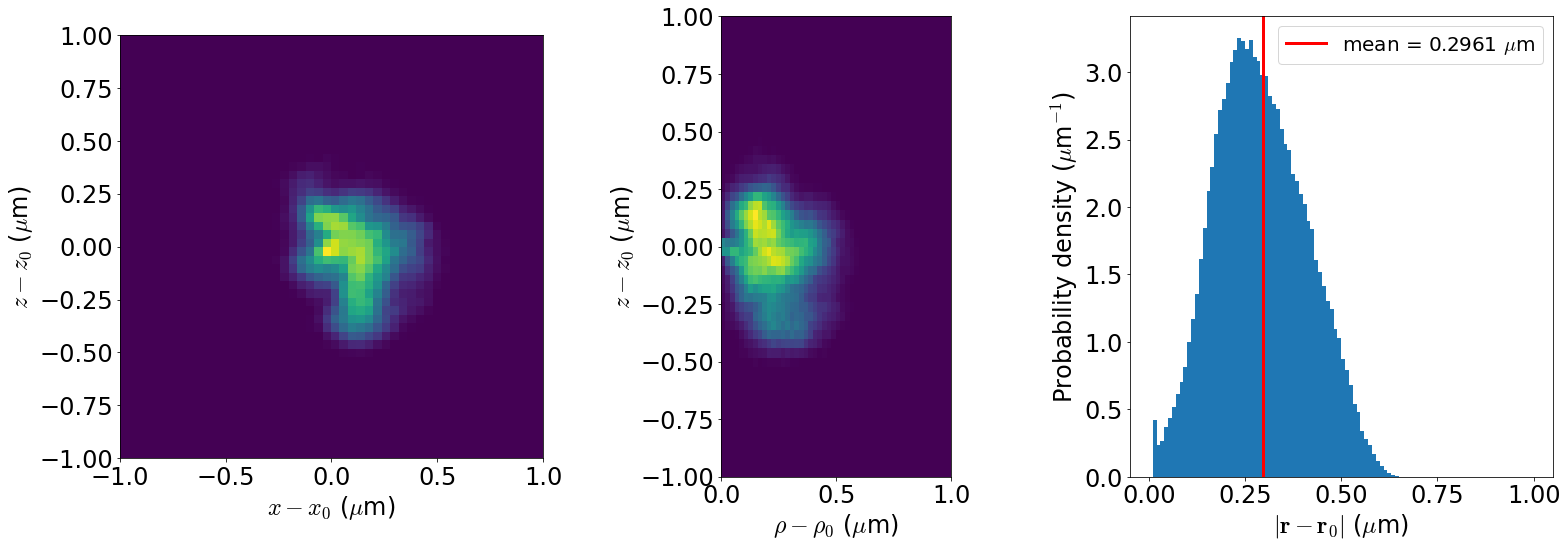

In [48]:
# Testing
data_path = Path("21-04-23_AMchr1_line512_pin/")
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    make_segment_distr_graphs(com_arr, [], [0,1], 1,2)

<BarContainer object of 100 artists>

Text(0.5, 0, '$|{\\bf r} - {\\bf r}_0|$ ($\\mu$m)')

Text(0, 0.5, 'Probability density ($\\mu$m$^{-1}$)')

Text(0.5, 0, '$|{\\bf \\rho} - {\\bf \\rho}_0|$ ($\\mu$m)')

Text(0, 0.5, '$z-z_0$ ($\\mu$m)')

0.14348722


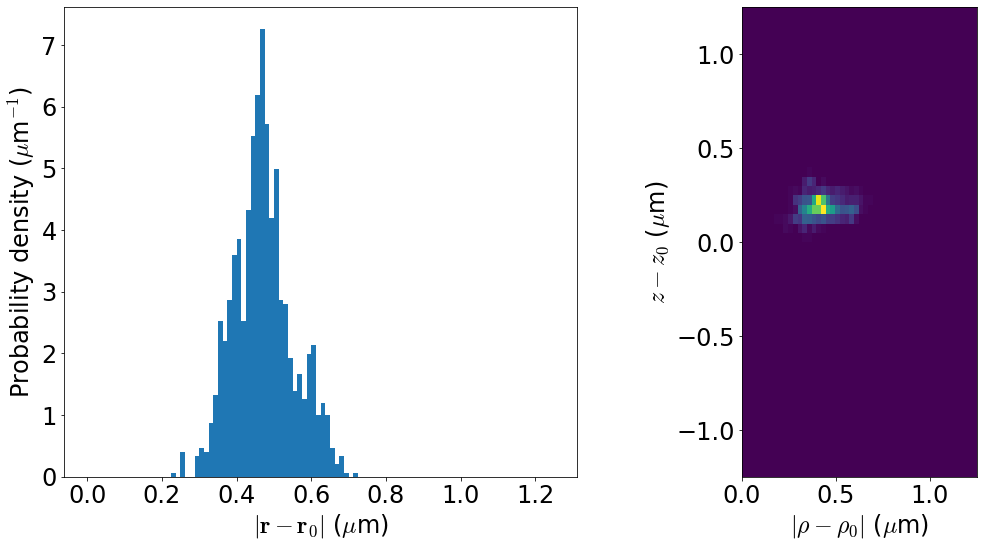

In [22]:

data_path = Path("")
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[1].set_aspect('equal')
with h5py.File(next(data_path_pin0.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    dist_hist_dat, z_rho_hist_dat = distr_hists(com_arr, .5, hist_max=1.25)
    ax[0].bar(dist_hist_dat[1][:-1], dist_hist_dat[0],
              width=np.diff(dist_hist_dat[1]), align='edge')

    X, Y = np.meshgrid(z_rho_hist_dat[1], z_rho_hist_dat[2])
    ax[1].pcolormesh(X, Y, z_rho_hist_dat[0].T)

    ax[0].set_xlabel(r'$|{\bf r} - {\bf r}_0|$ ($\mu$m)')
    ax[0].set_ylabel(r'Probability density ($\mu$m$^{-1}$)')
    ax[1].set_xlabel(r'$|{\bf \rho} - {\bf \rho}_0|$ ($\mu$m)')
    ax[1].set_ylabel(r'$z-z_0$ ($\mu$m)')

    plt.tight_layout()
    print(get_all_rog_stats(com_arr)[-1][int(com_arr.shape[0]*.5)])

## End-to-End Displacement

In [25]:
def get_end_end_distance(com_arr):
    return np.linalg.norm(com_arr[0,:,:] - com_arr[-1,:,:], axis=0)

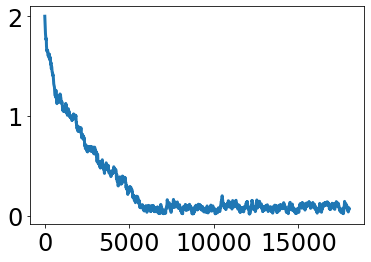

In [31]:
data_path = Path("21-05-07_AMchr1_line100_scan5.1_xl1000-5000/simulations/xl1000/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    ee_dist = get_end_end_distance(com_arr)
    
fig, ax = plt.subplots()
ax.plot(time_arr, ee_dist)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


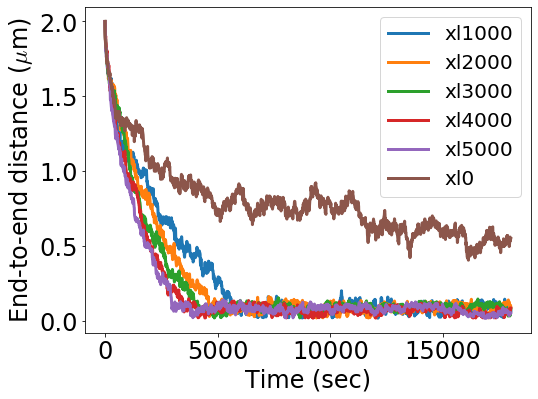

In [30]:
data_path = Path("21-05-07_AMchr1_line100_scan5.1_xl1000-5000/simulations/")
ss_ind = 0
fig, ax = plt.subplots(figsize=(8,6))
for h5_path in data_path.glob('**/*.h5'):
    with h5py.File(h5_path, 'r+') as h5_data:
        time_arr = h5_data['time'][ss_ind:]
        sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        ee_dist = get_end_end_distance(com_arr)
    
    _ = ax.plot(time_arr, ee_dist, label=h5_path.stem)
    
_ = ax.set_xlabel('Time (sec)')
_ = ax.set_ylabel('End-to-end distance ($\mu$m)')
_ = ax.legend()

## Radius of gyration

In [6]:
def calc_rad_of_gyration(pos_mat):
    """Calculate the radius of gyration of filament

    @param pos_mat TODO
    @return: TODO

    """
    n_beads = float(pos_mat.shape[0])
    rel_pos_arr = pos_mat - np.mean(pos_mat, axis=0)

    rog_sqr_arr = np.einsum('ijk,ijk->k', rel_pos_arr, rel_pos_arr) / n_beads
    return np.sqrt(rog_sqr_arr)


In [7]:
def make_rog_vs_time_graph(time_arr, com_arr, label=None):
    fig, ax = plt.subplots(figsize=(8,6))   
    rog_arr = calc_rad_of_gyration(com_arr)
    _ = ax.plot(time_arr, rog_arr, label=label)
    _ = ax.set_xlabel('Time (sec)')
    _ = ax.set_ylabel('Radius of gyration $R_g$ ($\mu$m)')
    return fig, ax

In [8]:
def plot_rog_vs_time_graph(ax, time_arr, com_arr, label=None):
    rog_arr = calc_rad_of_gyration(com_arr)
    _ = ax.plot(time_arr, rog_arr, label=label)
    return

In [9]:
data_path = Path("21-05-12_AMchr1_RS_line512eq_lo0_kl36.50_visc1.0_ts.1/")
#data_path = Path("21-05-07_AMchr1_line100_scan5.1_xl1000-5000/simulations/xl1000")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    nbeads = com_arr.shape[0]
    rog_arr = calc_rad_of_gyration(com_arr)
    ee_dist = get_end_end_distance(com_arr)

fig, ax = plt.subplots()
ax.plot(time_arr, rog_arr)
ax.axhline(np.sqrt(nbeads*.02*.02/6.))
ax.axhline(np.mean(rog_arr), c='r')
#ax.plot(time_arr, ee_dist)
#plt.axhline(np.mean(rog_arr))

StopIteration: 

## Nearest neighbors

In [10]:
def find_neighbors(com_arr, diam, time_ind=0):
    """TODO: Docstring for find_neighbors.

    """
    neighbor_mat = (np.linalg.norm((com_arr[:, np.newaxis, :, time_ind] -
                                    com_arr[np.newaxis, :, :, time_ind]),
                                   axis=2) < diam * 1.2).astype(int)
    return neighbor_mat

data_path = Path("21-04-06_AMchr1_loop520_pin_conf.6/")
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    neighbor_mat = find_neighbors(com_arr, .02)
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].pcolorfast(neighbor_mat)
    start=180
    stop=240
    ax[1].pcolorfast(neighbor_mat[start:stop, -stop:-start])
    x, y = np.where(neighbor_mat)
    x_ind = np.where((x > start) & (x < stop))
    print(x[x_ind][np.where(y[x_ind] > 520-stop)])
    print(y[x_ind][np.where(y[x_ind] > 520-stop)])
    #print(np.where(neighbor_mat))
    

StopIteration: 

# Data/Results

## 1040 2 loop

(20, 160)


<ipython-input-182-967d01ee41eb>:65: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)
<ipython-input-182-967d01ee41eb>:70: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')


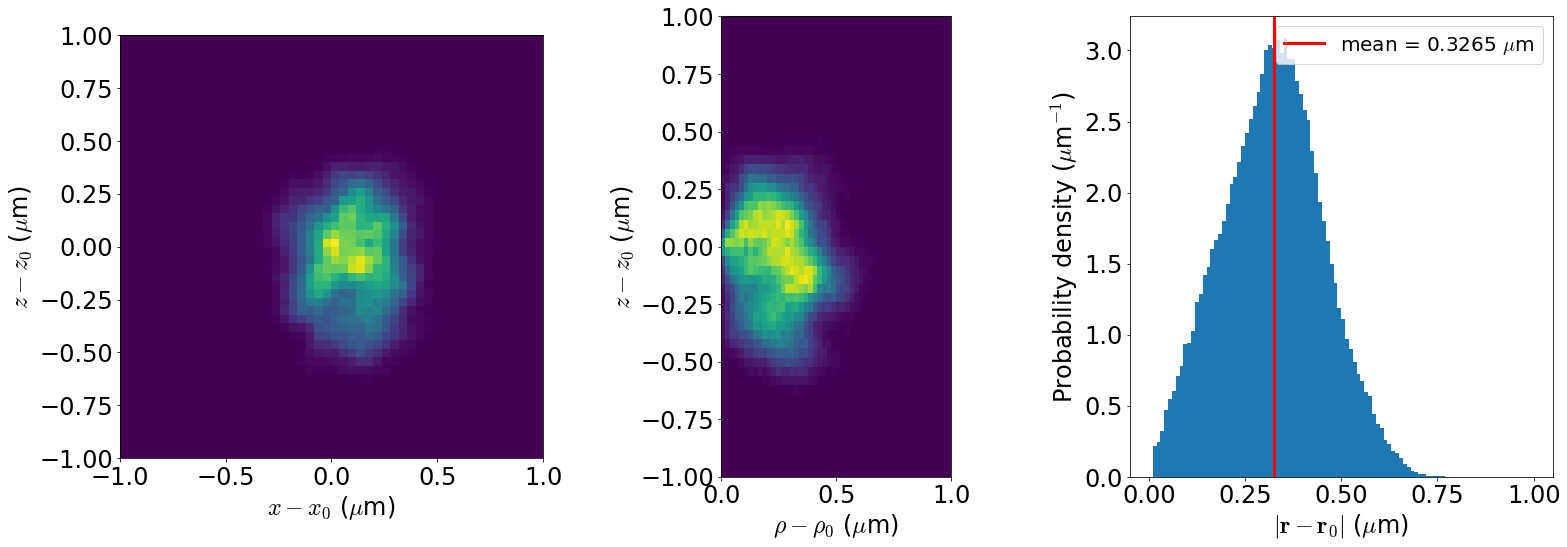

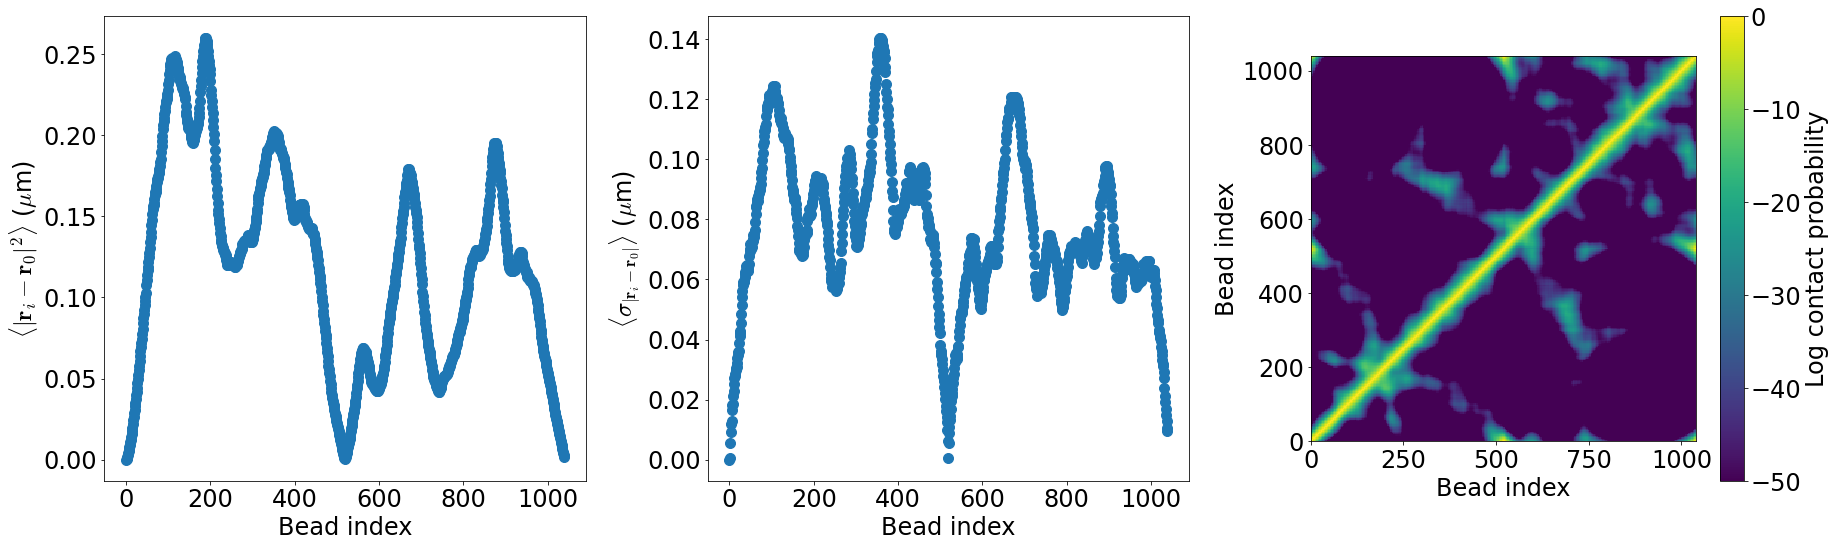

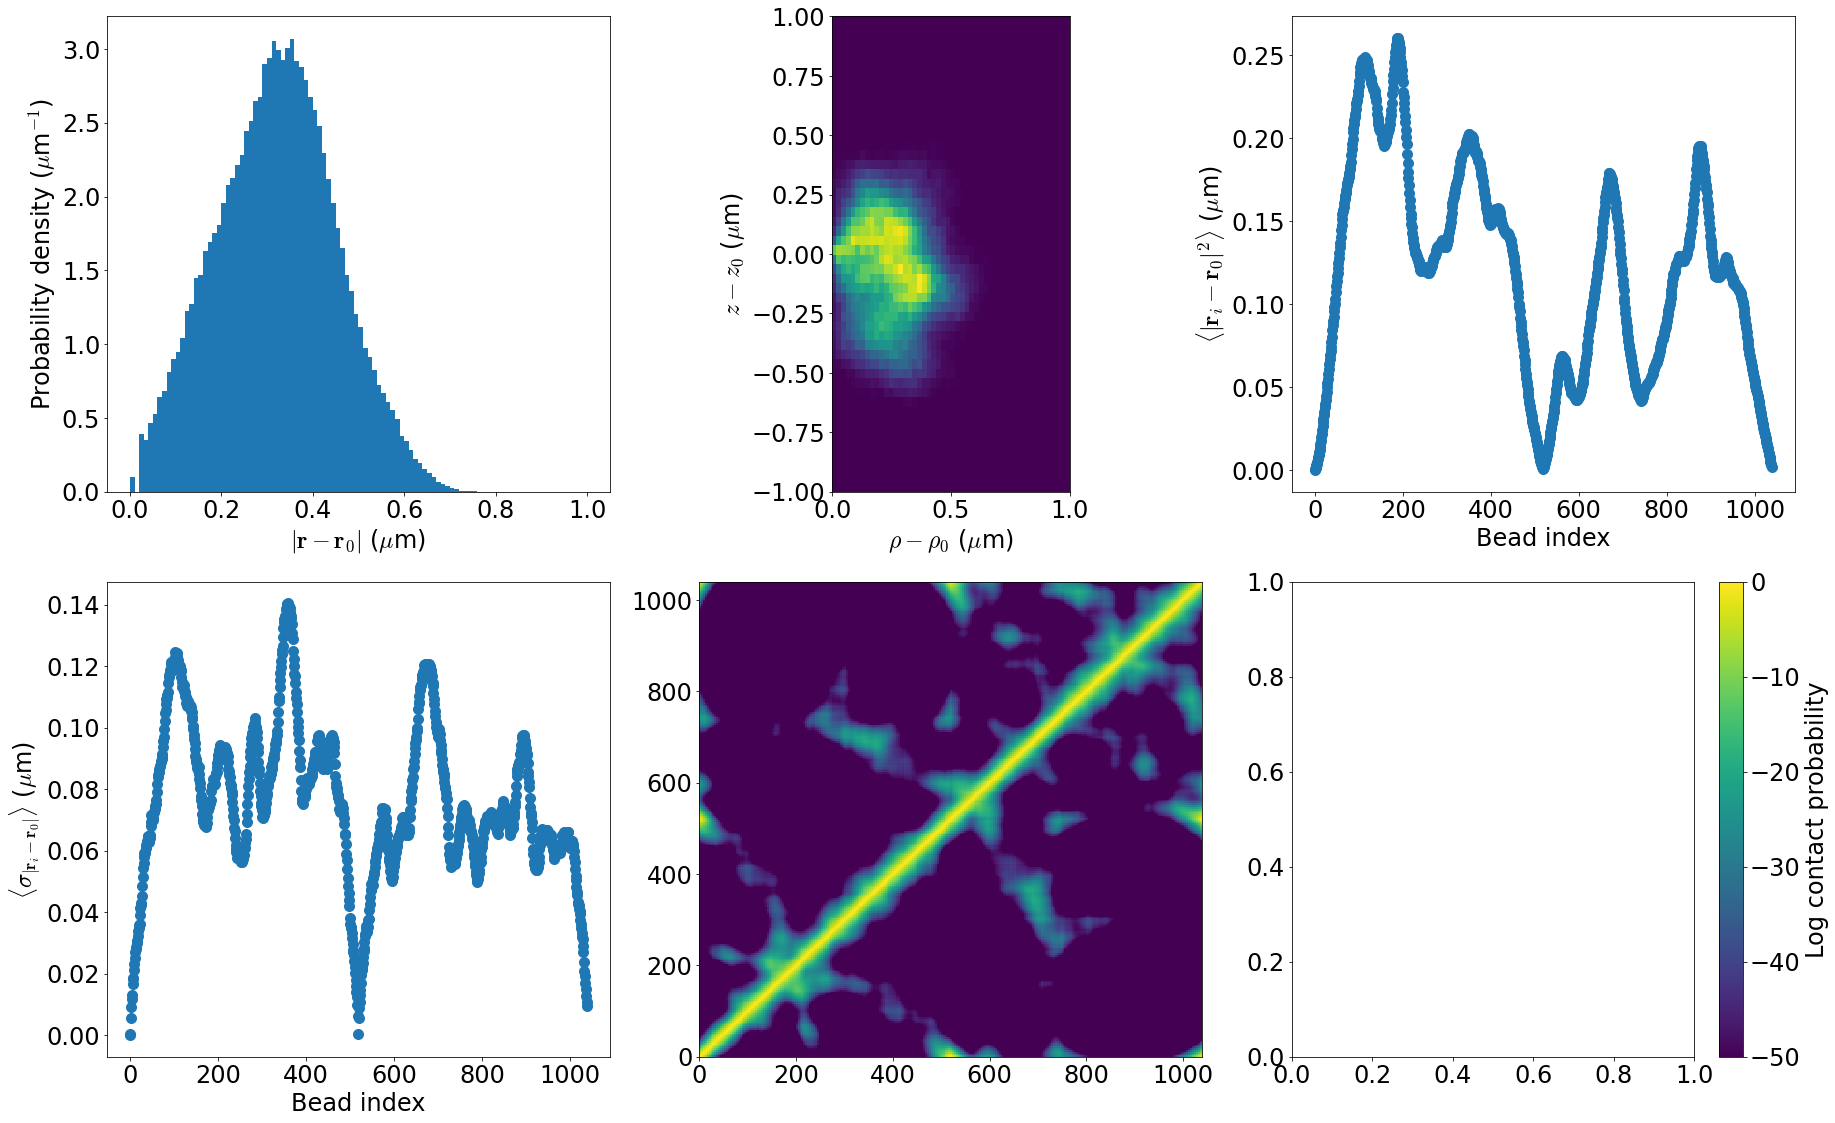

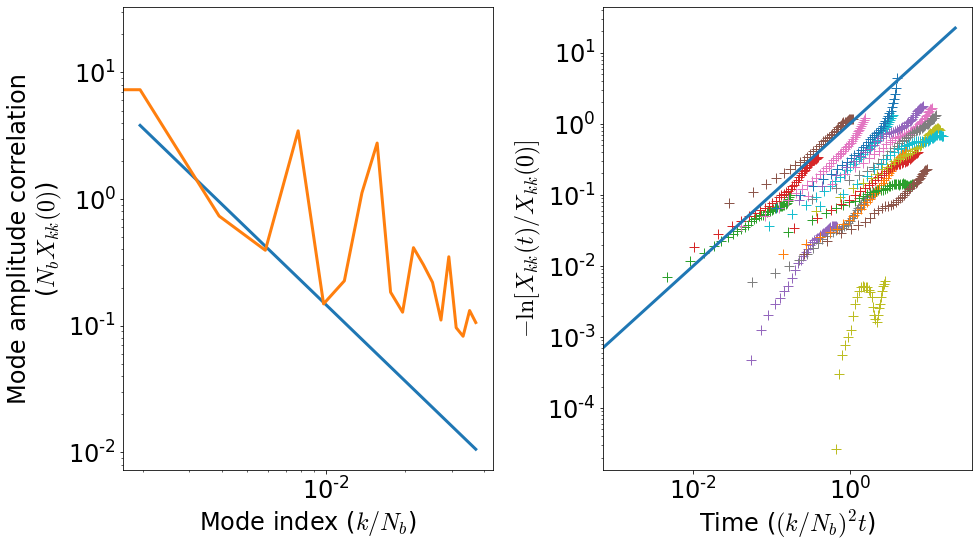

In [199]:
data_path = Path("21-04-26_AMchr1_2loop1040/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)
    
    ##com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_total_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

## 1040 RS 2 loop

(20, 160)


<ipython-input-182-967d01ee41eb>:65: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)
<ipython-input-182-967d01ee41eb>:70: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')


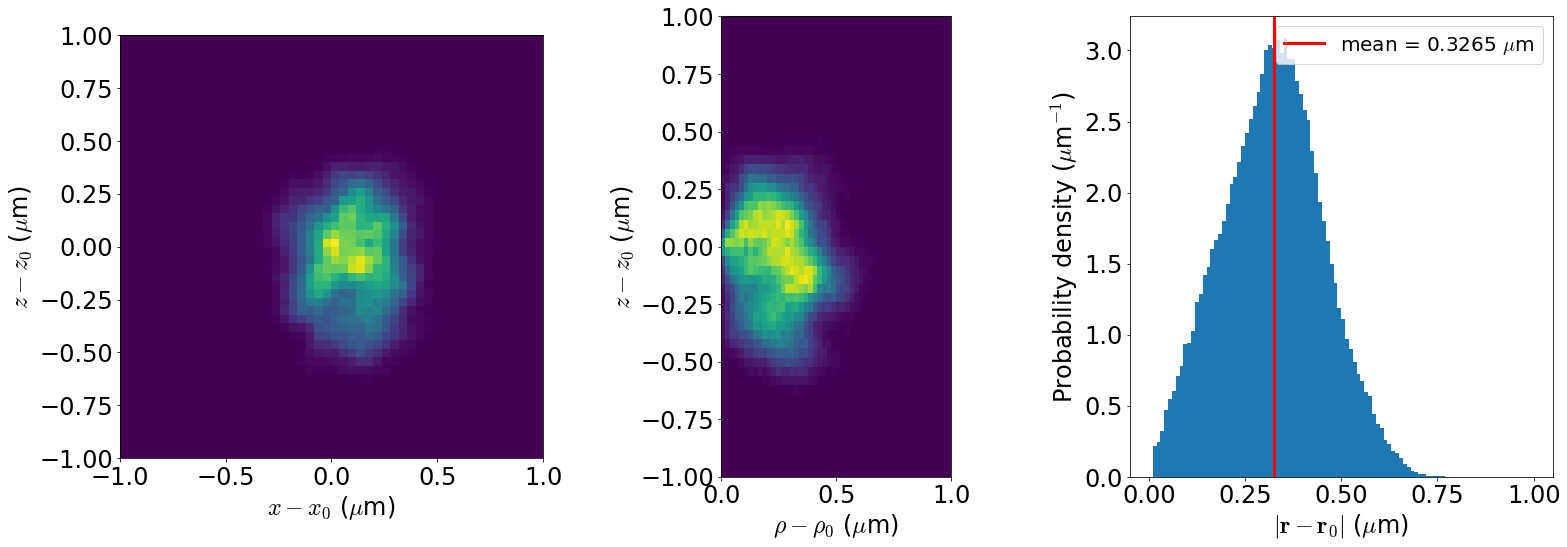

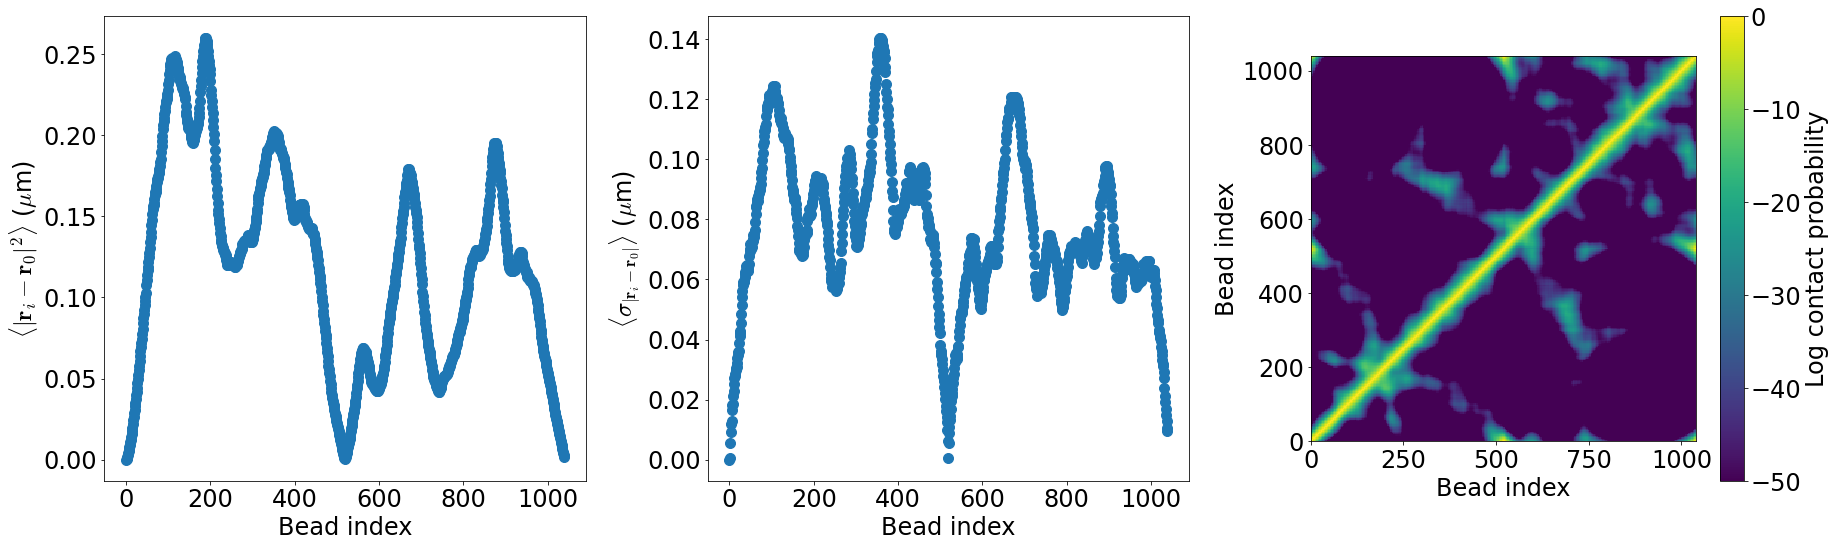

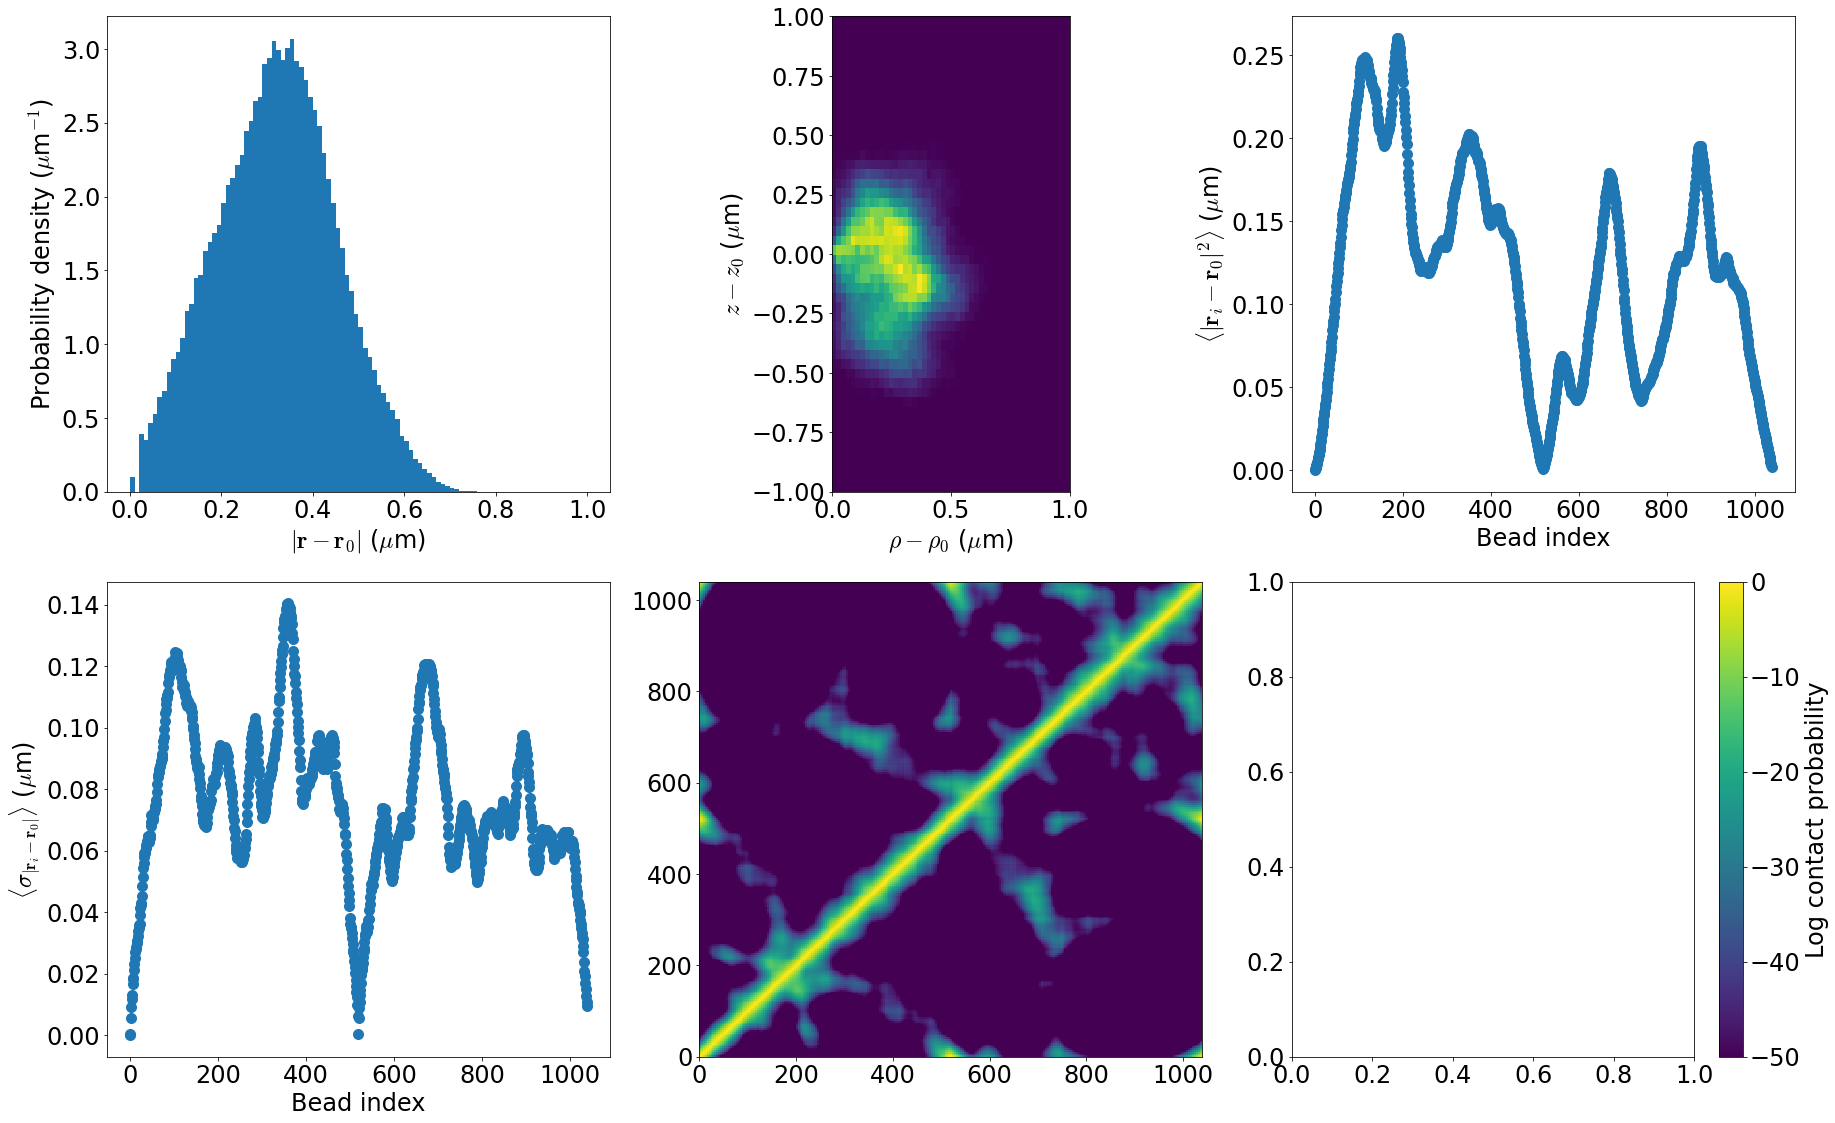

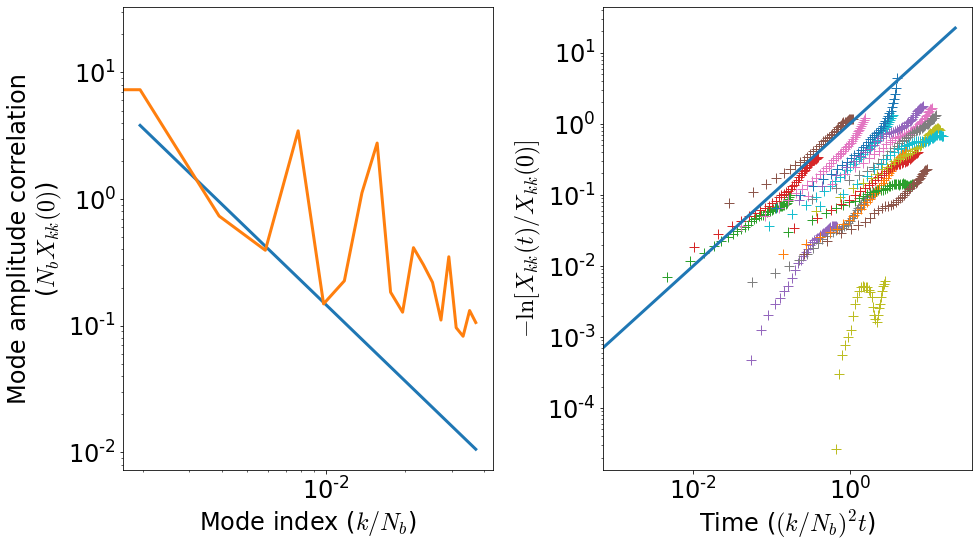

In [202]:
data_path = Path("21-04-26_AMchr1_2loop1040/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)
    
    ##com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_total_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

## 520 loop confinement scan

21-05-14_AMchr1_loop520_scan5.1_pin_visc1.0_Rconf.25-2.0/simulations/cR0.25/cR0.h5
21-05-14_AMchr1_loop520_scan5.1_pin_visc1.0_Rconf.25-2.0/simulations/cR0.5/cR0.h5
21-05-14_AMchr1_loop520_scan5.1_pin_visc1.0_Rconf.25-2.0/simulations/cR1/cR1.h5
21-05-14_AMchr1_loop520_scan5.1_pin_visc1.0_Rconf.25-2.0/simulations/cR2/cR2.h5
21-05-14_AMchr1_loop520_scan5.1_pin_visc1.0_Rconf.25-2.0/simulations/cR4/cR4.h5


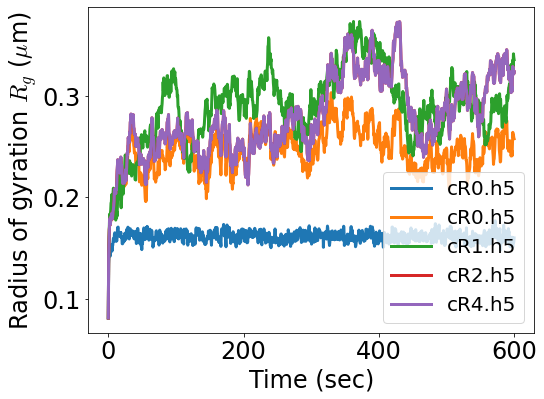

In [327]:
data_path = Path("21-05-14_AMchr1_loop520_scan5.1_pin_visc1.0_Rconf.25-2.0/")
ss_ind = 0
fig, ax = plt.subplots(figsize=(8,6))
for h5_path in data_path.glob('**/*.h5'):
    with h5py.File(h5_path, 'r+') as h5_data:
        time_arr = h5_data['time'][ss_ind:]
        sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        rog_arr = calc_rad_of_gyration(com_arr)
        ee_dist = get_end_end_distance(com_arr)
    
        _ = ax.plot(time_arr, rog_arr, label=h5_path.name)
        
_ = ax.set_xlabel('Time (sec)')
_ = ax.set_ylabel('Radius of gyration $R_g$ ($\mu$m)')
_ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")

## 520 loop confinement seed avg

8


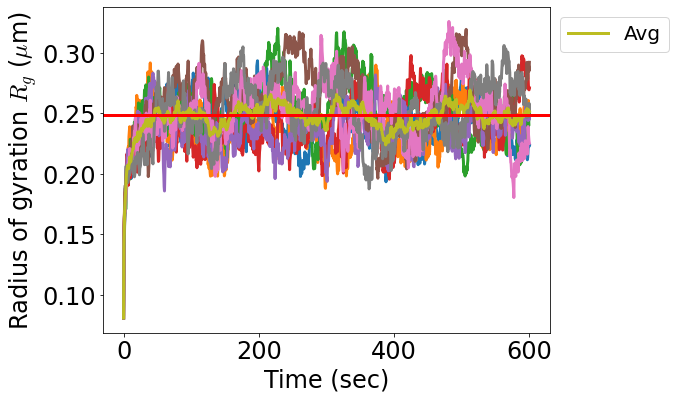

In [64]:
sd_data_paths = list(Path("21-05-18_AMchr1_scan.8_loop520_pin/simulations/").glob('*/*.h5'))
ss_ind = 0
rog_avg_arr = None
for h5_path in sd_data_paths:
    with h5py.File(h5_path, 'r+') as h5_data:
        time_arr = h5_data['time'][ss_ind:]
        sy_dat = h5_data['raw_data']['sylinders'][:520,:,ss_ind:]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        if not isinstance(rog_avg_arr, np.ndarray):
            fig, ax = make_rog_vs_time_graph(time_arr, com_arr)
            rog_avg_arr = calc_rad_of_gyration(com_arr)
        else:
            plot_rog_vs_time_graph(ax, time_arr, com_arr)
            rog_avg_arr += calc_rad_of_gyration(com_arr)
print(len(sd_data_paths))
rog_avg_arr /= len(sd_data_paths)
ax.plot(time_arr, rog_avg_arr, label='Avg')
ax.axhline(rog_avg_arr[400:].mean(), color='r')
_ = ax.legend(bbox_to_anchor=(1,1), loc='upper left')


## 520 loop 1000 crowder

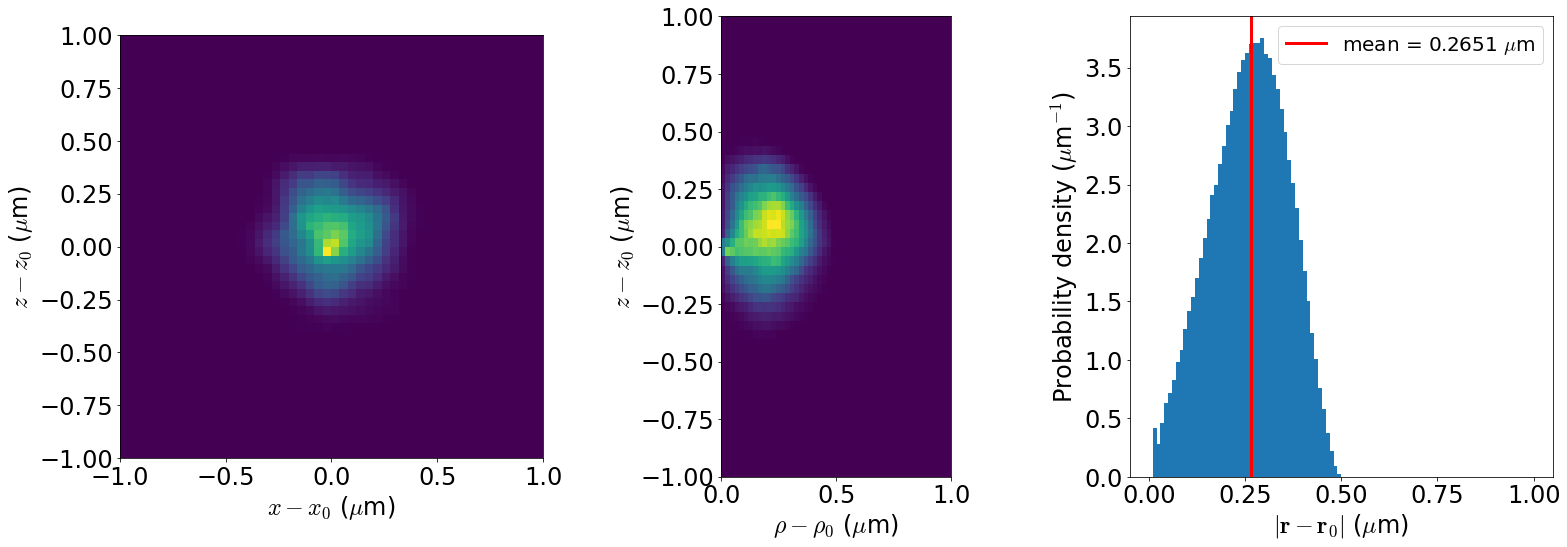

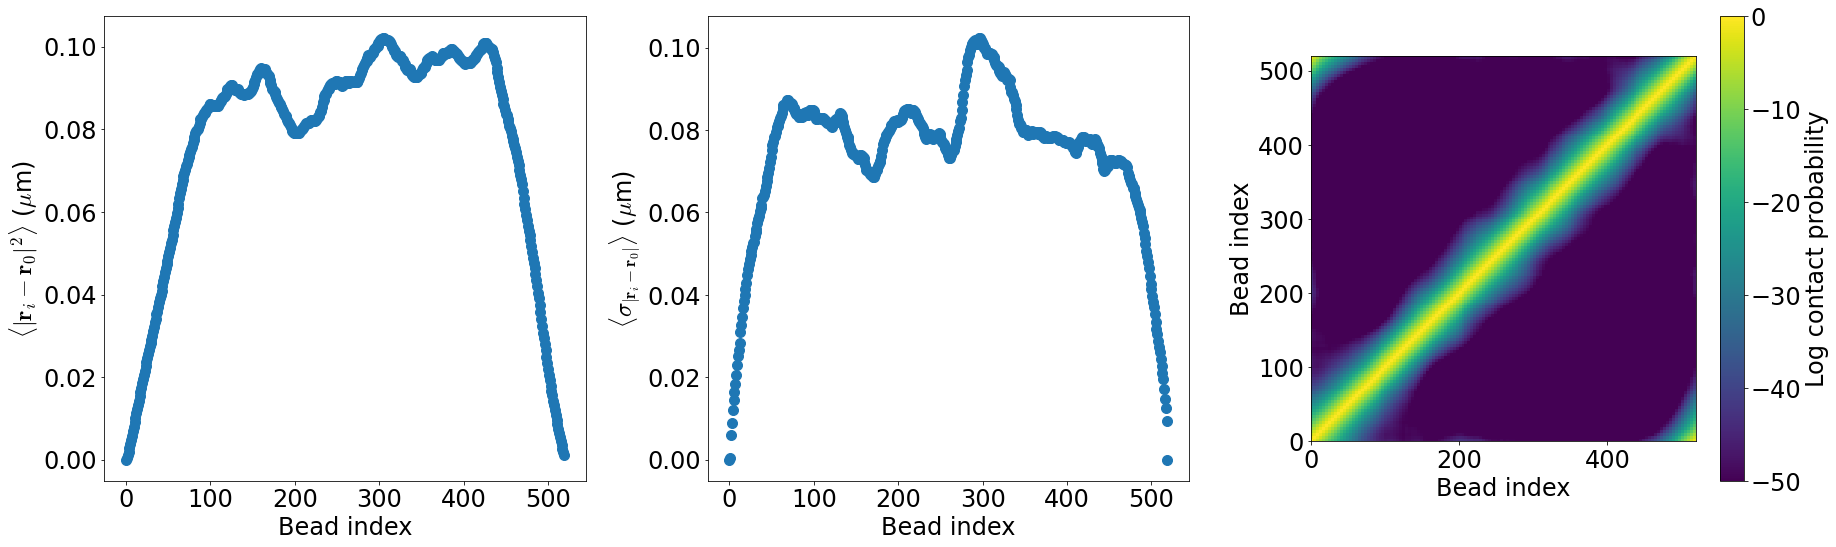

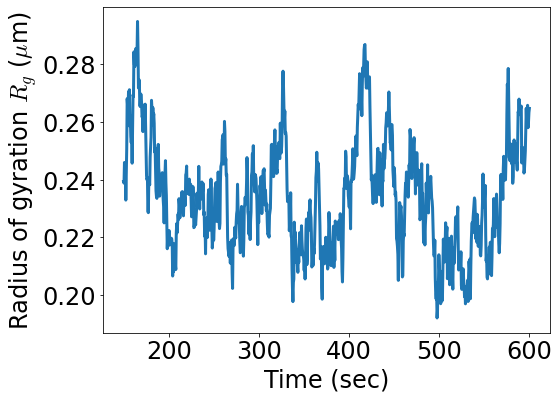

In [41]:
data_path = Path("21-05-18_AMchr1_scan.8_loop520_pin_crowder1000/simulations/s2/")
ss_ind = 300
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:520,:,ss_ind:]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    nbeads = com_arr.shape[0]


log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
#mode_mat = get_rouse_modes(com_arr)

# Graphing
fig0, ax0 = make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_rog_vs_time_graph(time_arr, com_arr)

#fig2, ax2 = make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=50)

## 520 loop 1000 crowder seed avg

s5
s8
s7
s1
s4
s3
s2
s6
8


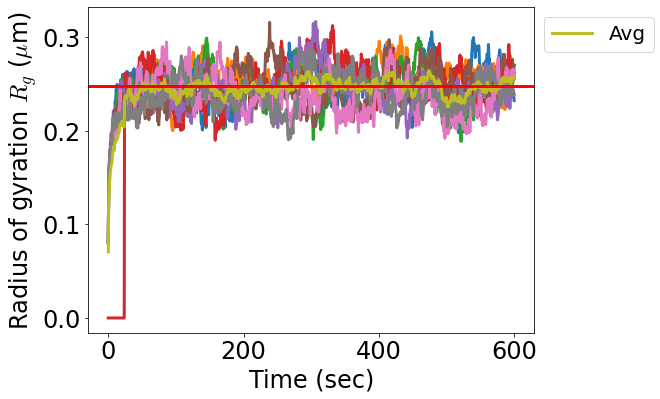

In [74]:
sd_data_paths = list(Path("21-05-18_AMchr1_scan.8_loop520_pin_crowder1000/simulations/").glob('*/*.h5'))
ss_ind = 0
rog_avg_arr = None
for h5_path in sd_data_paths:
    with h5py.File(h5_path, 'r+') as h5_data:
        time_arr = h5_data['time'][ss_ind:]
        sy_dat = h5_data['raw_data']['sylinders'][:520,:,ss_ind:]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        print(h5_path.stem)
        
        if not isinstance(rog_avg_arr, np.ndarray):
            fig, ax = make_rog_vs_time_graph(time_arr, com_arr)
            rog_avg_arr = calc_rad_of_gyration(com_arr)
        else:
            plot_rog_vs_time_graph(ax, time_arr, com_arr)
            rog_avg_arr += calc_rad_of_gyration(com_arr)
print(len(sd_data_paths))
rog_avg_arr /= len(sd_data_paths)
ax.plot(time_arr, rog_avg_arr, label='Avg')
ax.axhline(rog_avg_arr[400:].mean(), color='r')
_ = ax.legend(bbox_to_anchor=(1,1), loc='upper left')


## 520 loop 2000 crowder seed avg

8


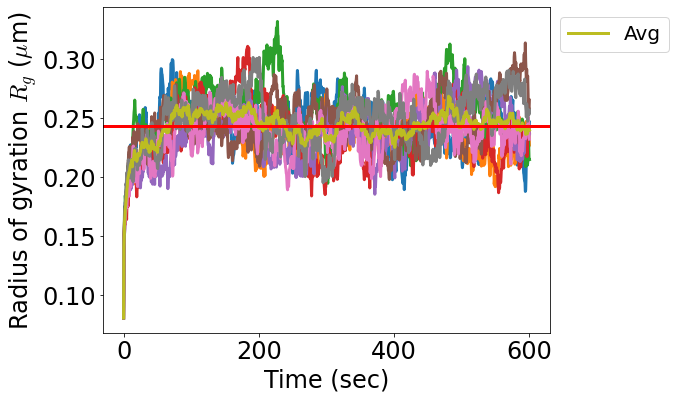

In [63]:
sd_data_paths = list(Path("21-05-18_AMchr1_scan.8_loop520_pin_crowder2000/simulations/").glob('*/*.h5'))
ss_ind = 0
rog_avg_arr = None
for h5_path in sd_data_paths:
    with h5py.File(h5_path, 'r+') as h5_data:
        time_arr = h5_data['time'][ss_ind:]
        sy_dat = h5_data['raw_data']['sylinders'][:520,:,ss_ind:]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        if not isinstance(rog_avg_arr, np.ndarray):
            fig, ax = make_rog_vs_time_graph(time_arr, com_arr)
            rog_avg_arr = calc_rad_of_gyration(com_arr)
        else:
            plot_rog_vs_time_graph(ax, time_arr, com_arr)
            rog_avg_arr += calc_rad_of_gyration(com_arr)
print(len(sd_data_paths))
rog_avg_arr /= len(sd_data_paths)
ax.plot(time_arr, rog_avg_arr, label='Avg')
ax.axhline(rog_avg_arr[400:].mean(), color='r')
_ = ax.legend(bbox_to_anchor=(1,1), loc='upper left')


## 520 loop 1000 crowder Rad.005 seed avg

8


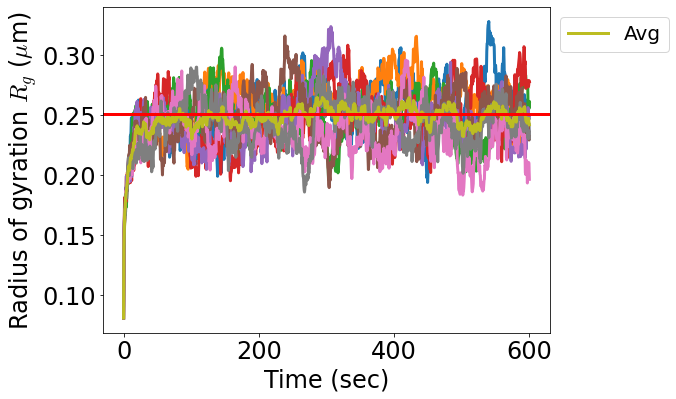

In [65]:
sd_data_paths = list(Path("21-05-18_AMchr1_scan.8_loop520_pin_crowder1000_crRad.005/simulations/").glob('*/*.h5'))
ss_ind = 0
rog_avg_arr = None
for h5_path in sd_data_paths:
    with h5py.File(h5_path, 'r+') as h5_data:
        time_arr = h5_data['time'][ss_ind:]
        sy_dat = h5_data['raw_data']['sylinders'][:520,:,ss_ind:]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        if not isinstance(rog_avg_arr, np.ndarray):
            fig, ax = make_rog_vs_time_graph(time_arr, com_arr)
            rog_avg_arr = calc_rad_of_gyration(com_arr)
        else:
            plot_rog_vs_time_graph(ax, time_arr, com_arr)
            rog_avg_arr += calc_rad_of_gyration(com_arr)
print(len(sd_data_paths))
rog_avg_arr /= len(sd_data_paths)
ax.plot(time_arr, rog_avg_arr, label='Avg')
ax.axhline(rog_avg_arr[400:].mean(), color='r')
_ = ax.legend(bbox_to_anchor=(1,1), loc='upper left')


### 520 loop 4000 crowder seed avg

In [12]:
sd_data_paths = list(Path("21-05-27_AMchr1_scan.8_loop520_pin_crowder4000/").glob('*/*.h5'))
ss_ind = 0
rog_avg_arr = None
for h5_path in sd_data_paths:
    with h5py.File(h5_path, 'r+') as h5_data:
        time_arr = h5_data['time'][ss_ind:]
        sy_dat = h5_data['raw_data']['sylinders'][:520,:,ss_ind:]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        if not isinstance(rog_avg_arr, np.ndarray):
            fig, ax = make_rog_vs_time_graph(time_arr, com_arr)
            rog_avg_arr = calc_rad_of_gyration(com_arr)
        else:
            plot_rog_vs_time_graph(ax, time_arr, com_arr)
            rog_avg_arr += calc_rad_of_gyration(com_arr)
print(len(sd_data_paths))
rog_avg_arr /= len(sd_data_paths)
ax.plot(time_arr, rog_avg_arr, label='Avg')
ax.axhline(rog_avg_arr[400:].mean(), color='r')
_ = ax.legend(bbox_to_anchor=(1,1), loc='upper left')


0


TypeError: unsupported operand type(s) for /=: 'NoneType' and 'int'

# Line/Rouse mode testing

## 512 line scan dt.001-.1

### dt0.1

(20, 1802)


<ipython-input-182-967d01ee41eb>:65: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)


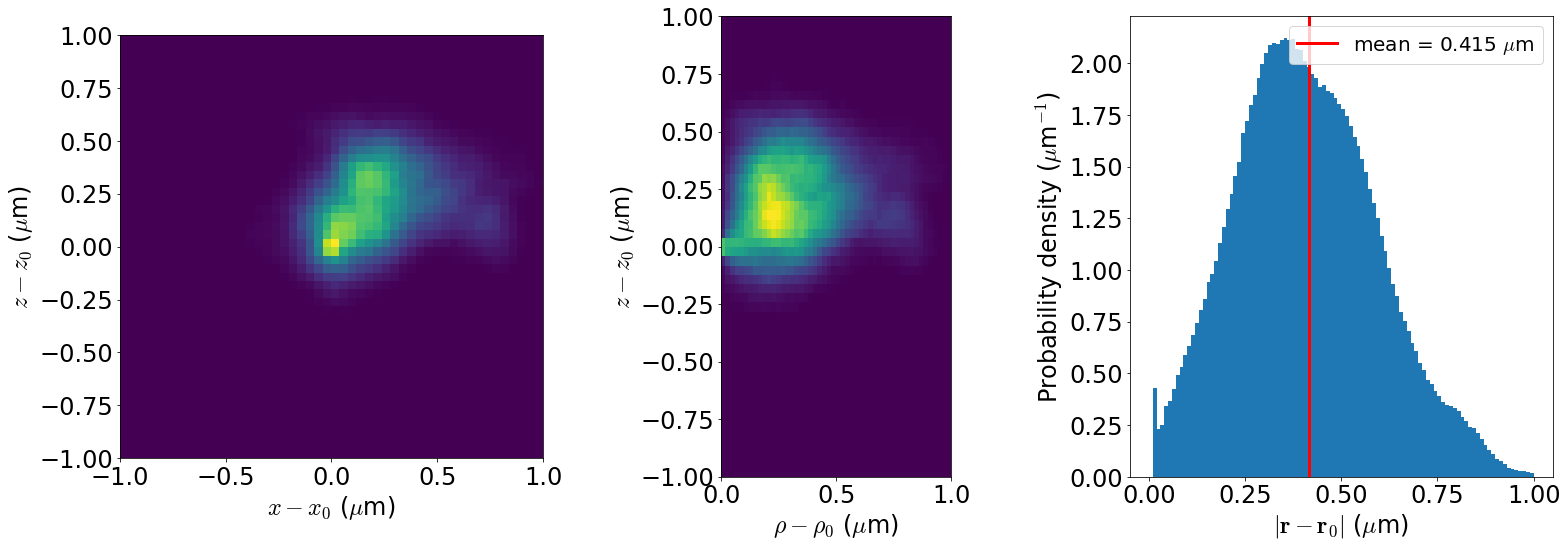

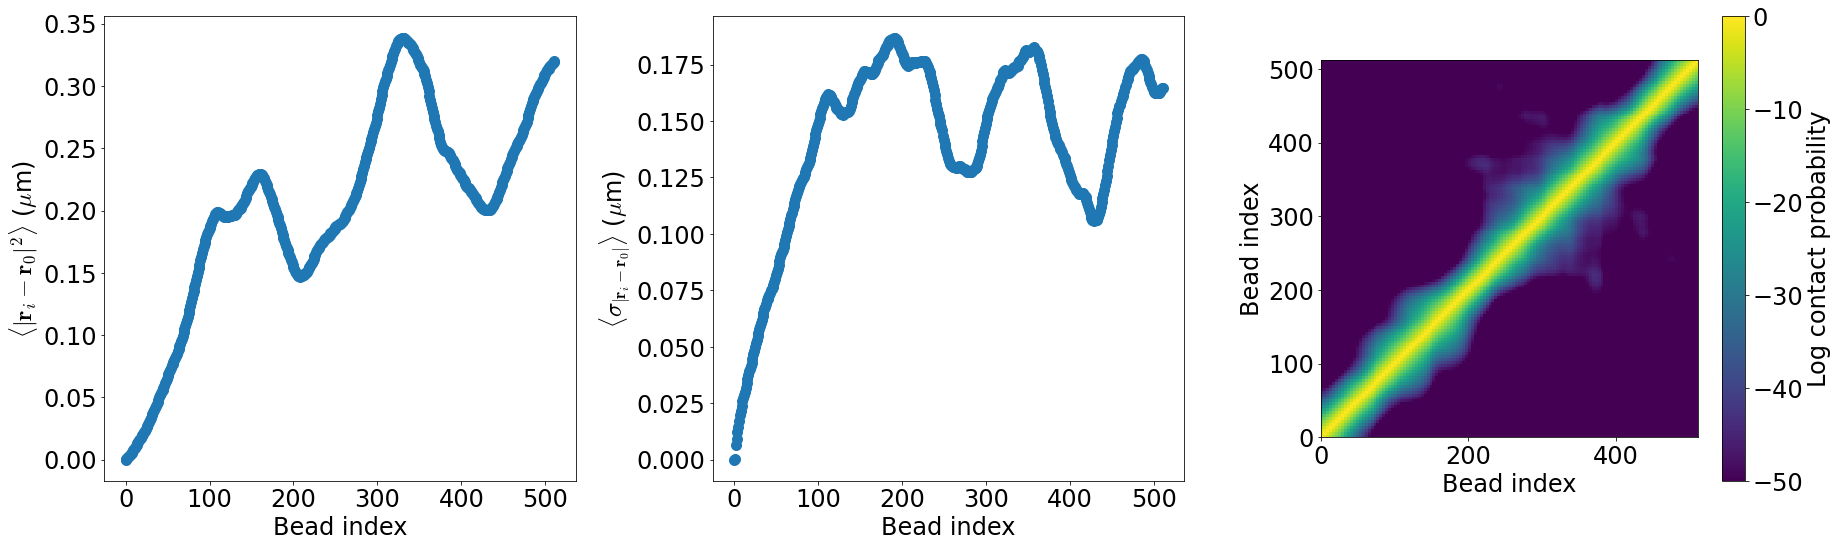

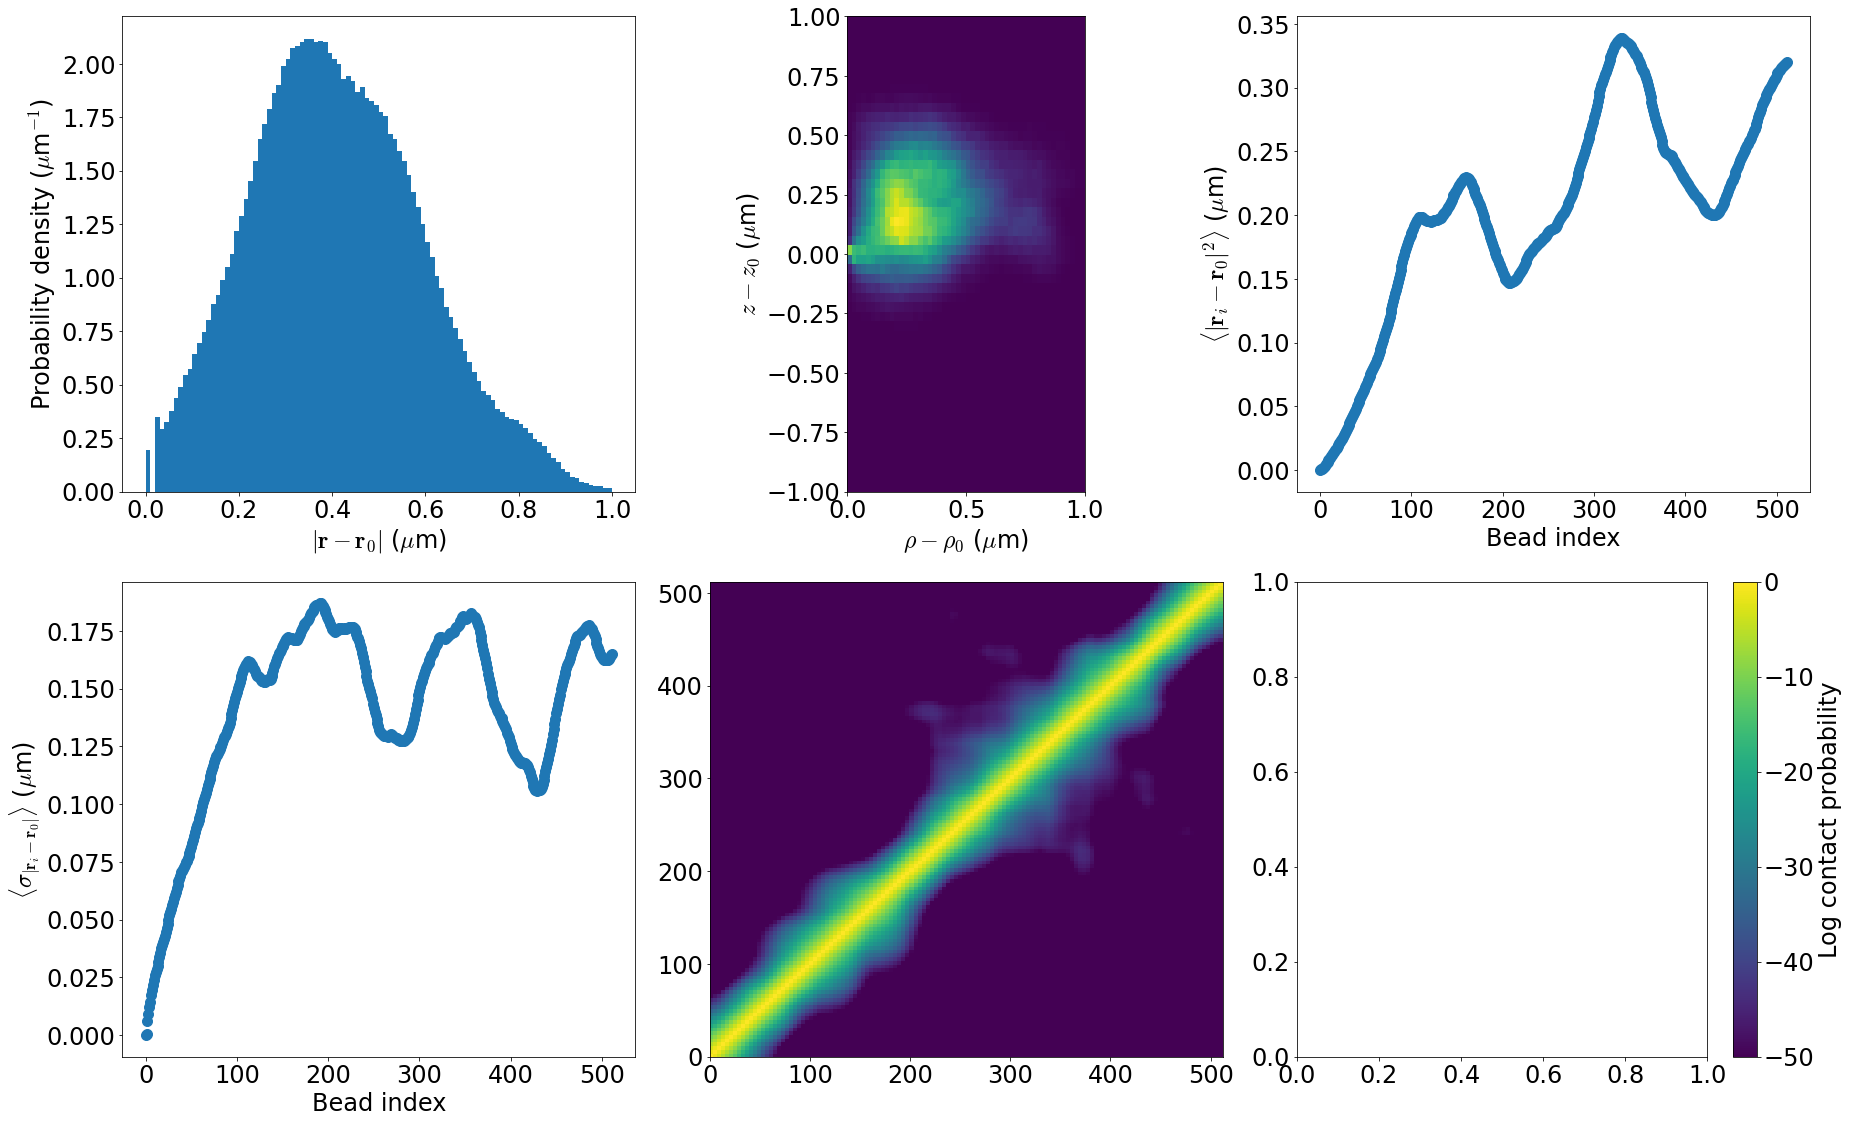

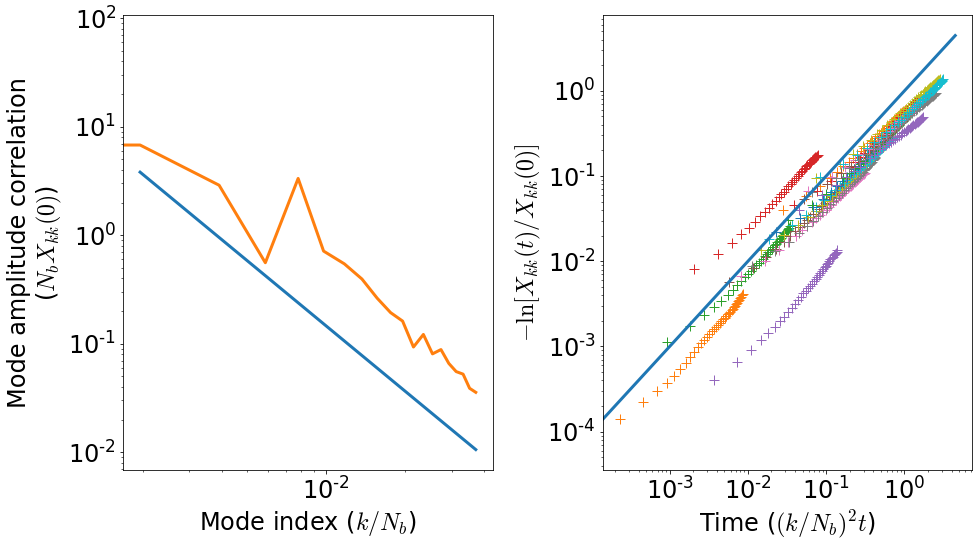

In [187]:
data_path = Path("21-04-23_AMchr1_line512_scan5.1_dt.001-.1/simulations/dt0.100/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)
    
    ##com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

#Graphing
make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_total_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)



### dt0.030

(20, 1802)


<ipython-input-182-967d01ee41eb>:65: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)


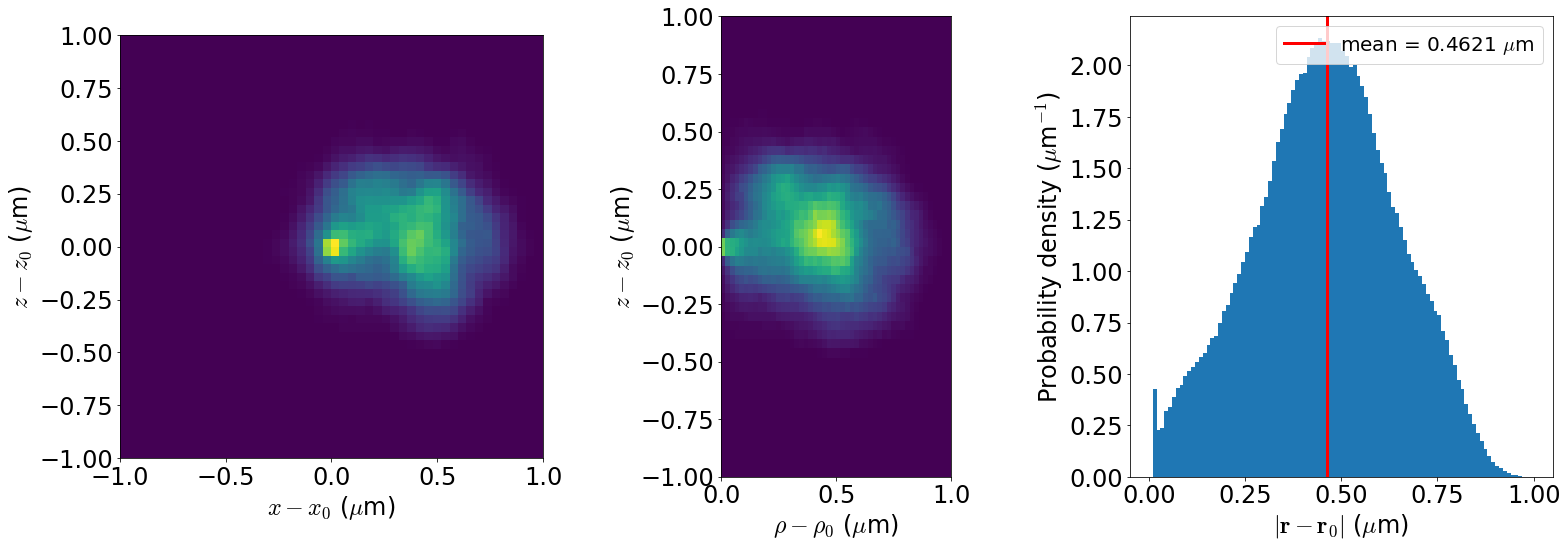

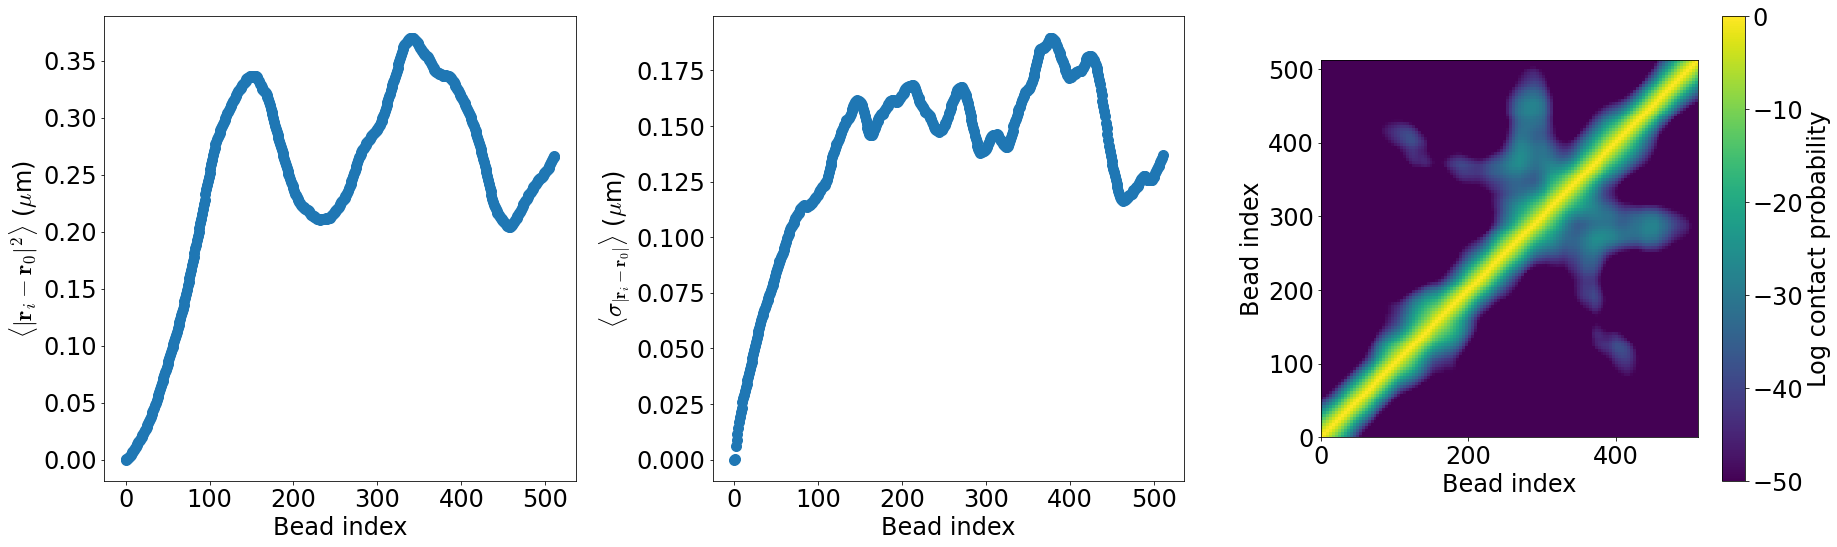

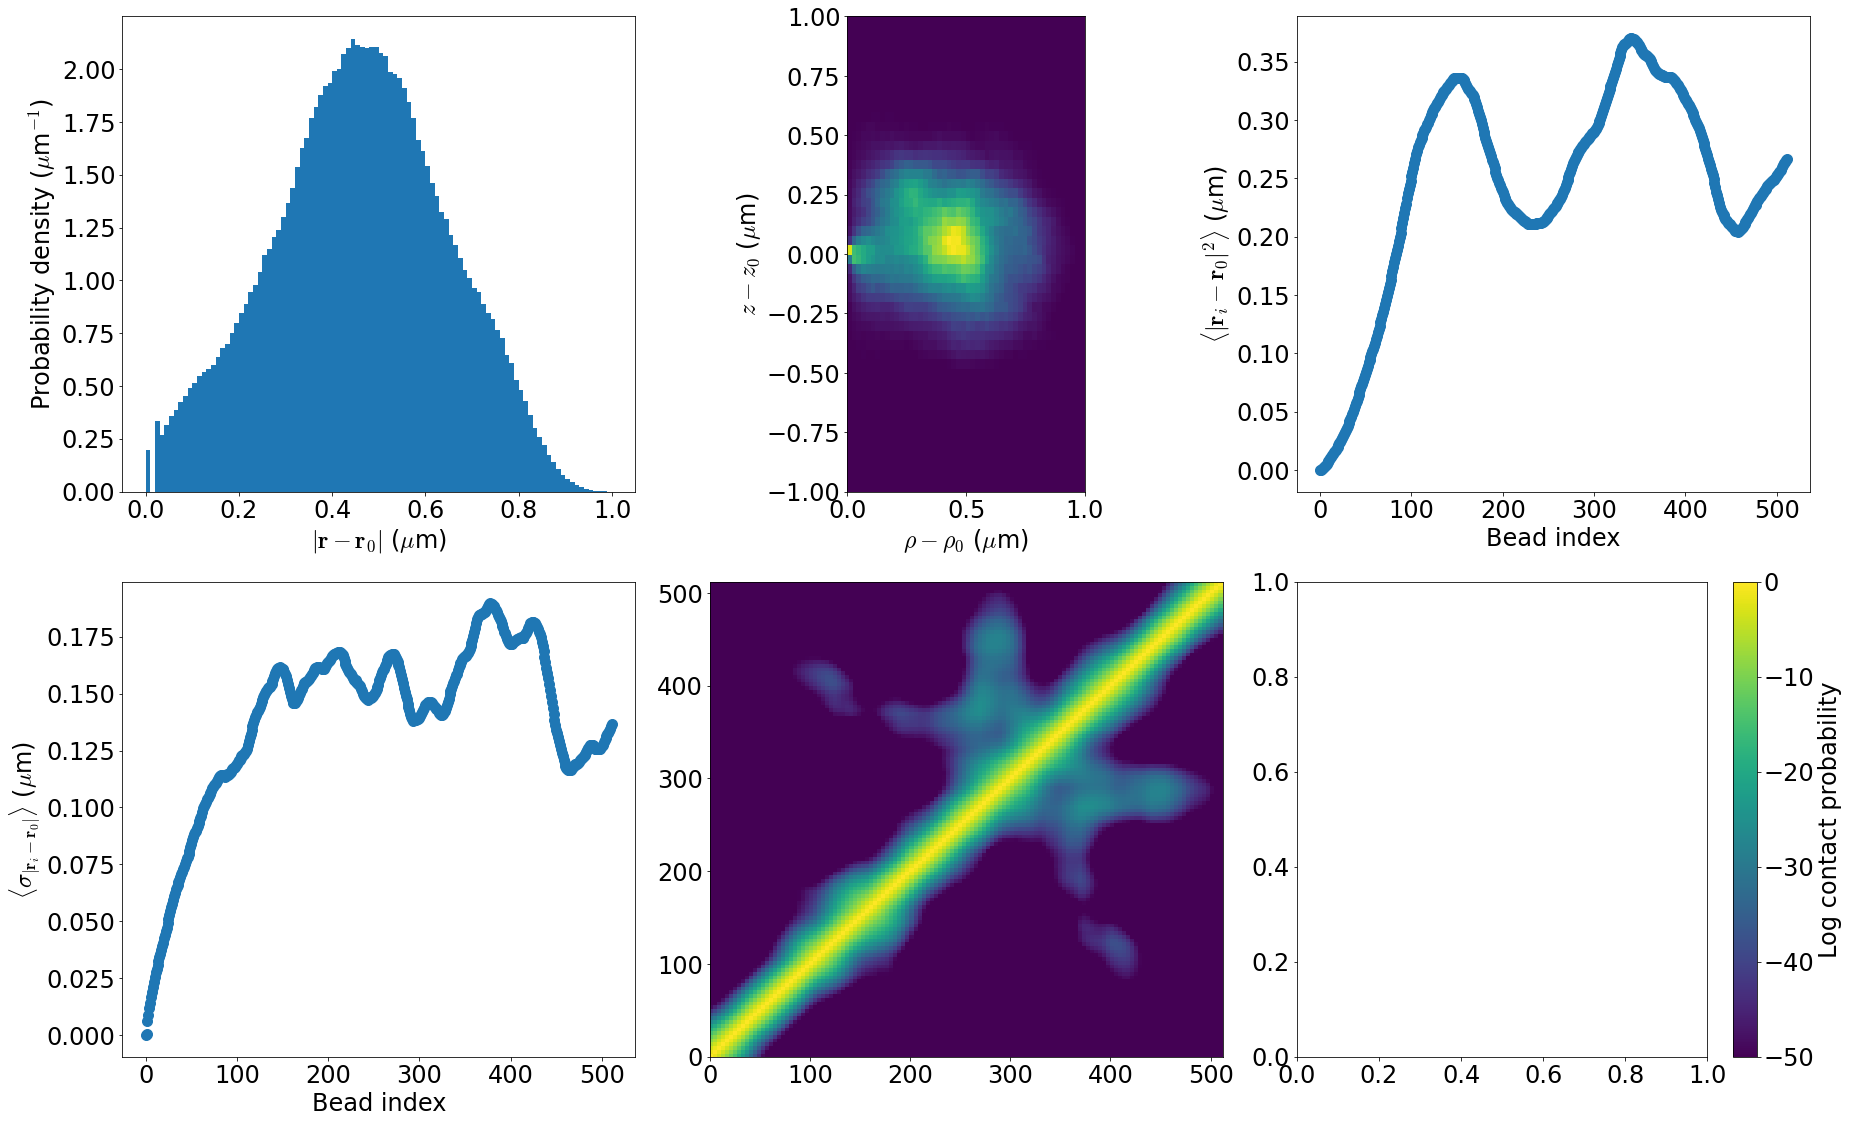

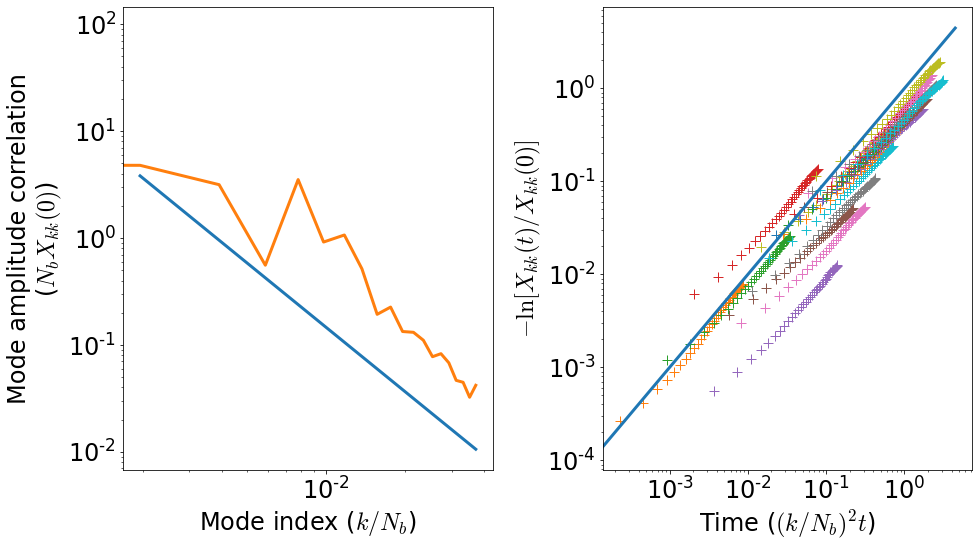

In [189]:
data_path = Path("21-04-23_AMchr1_line512_scan5.1_dt.001-.1/simulations/dt0.030/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)
    
    ##com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_total_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

### dt0.01

(20, 1802)


<ipython-input-182-967d01ee41eb>:65: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)


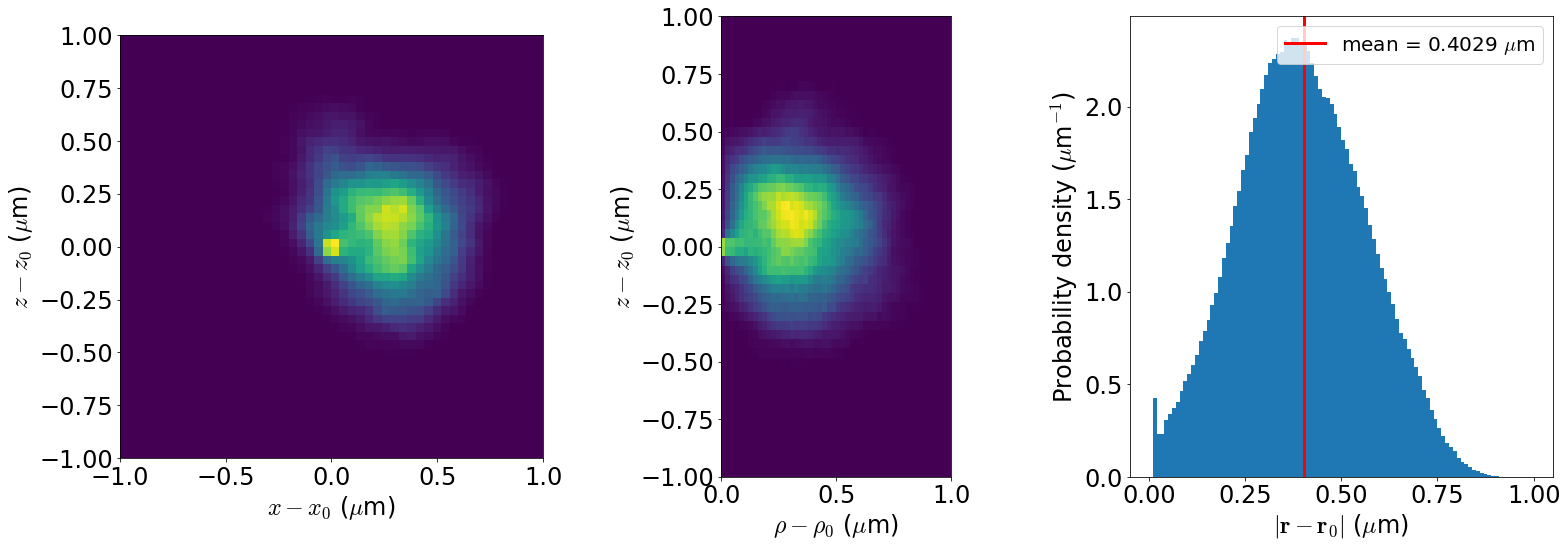

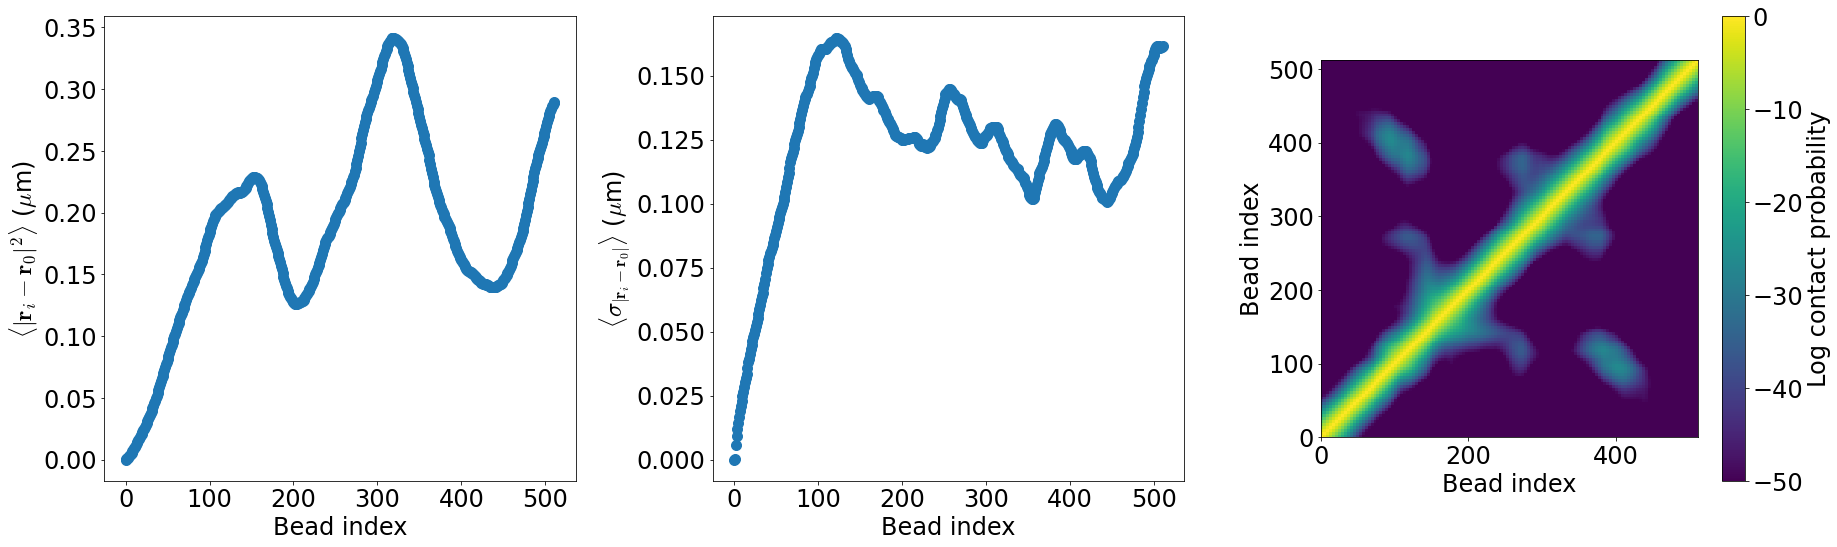

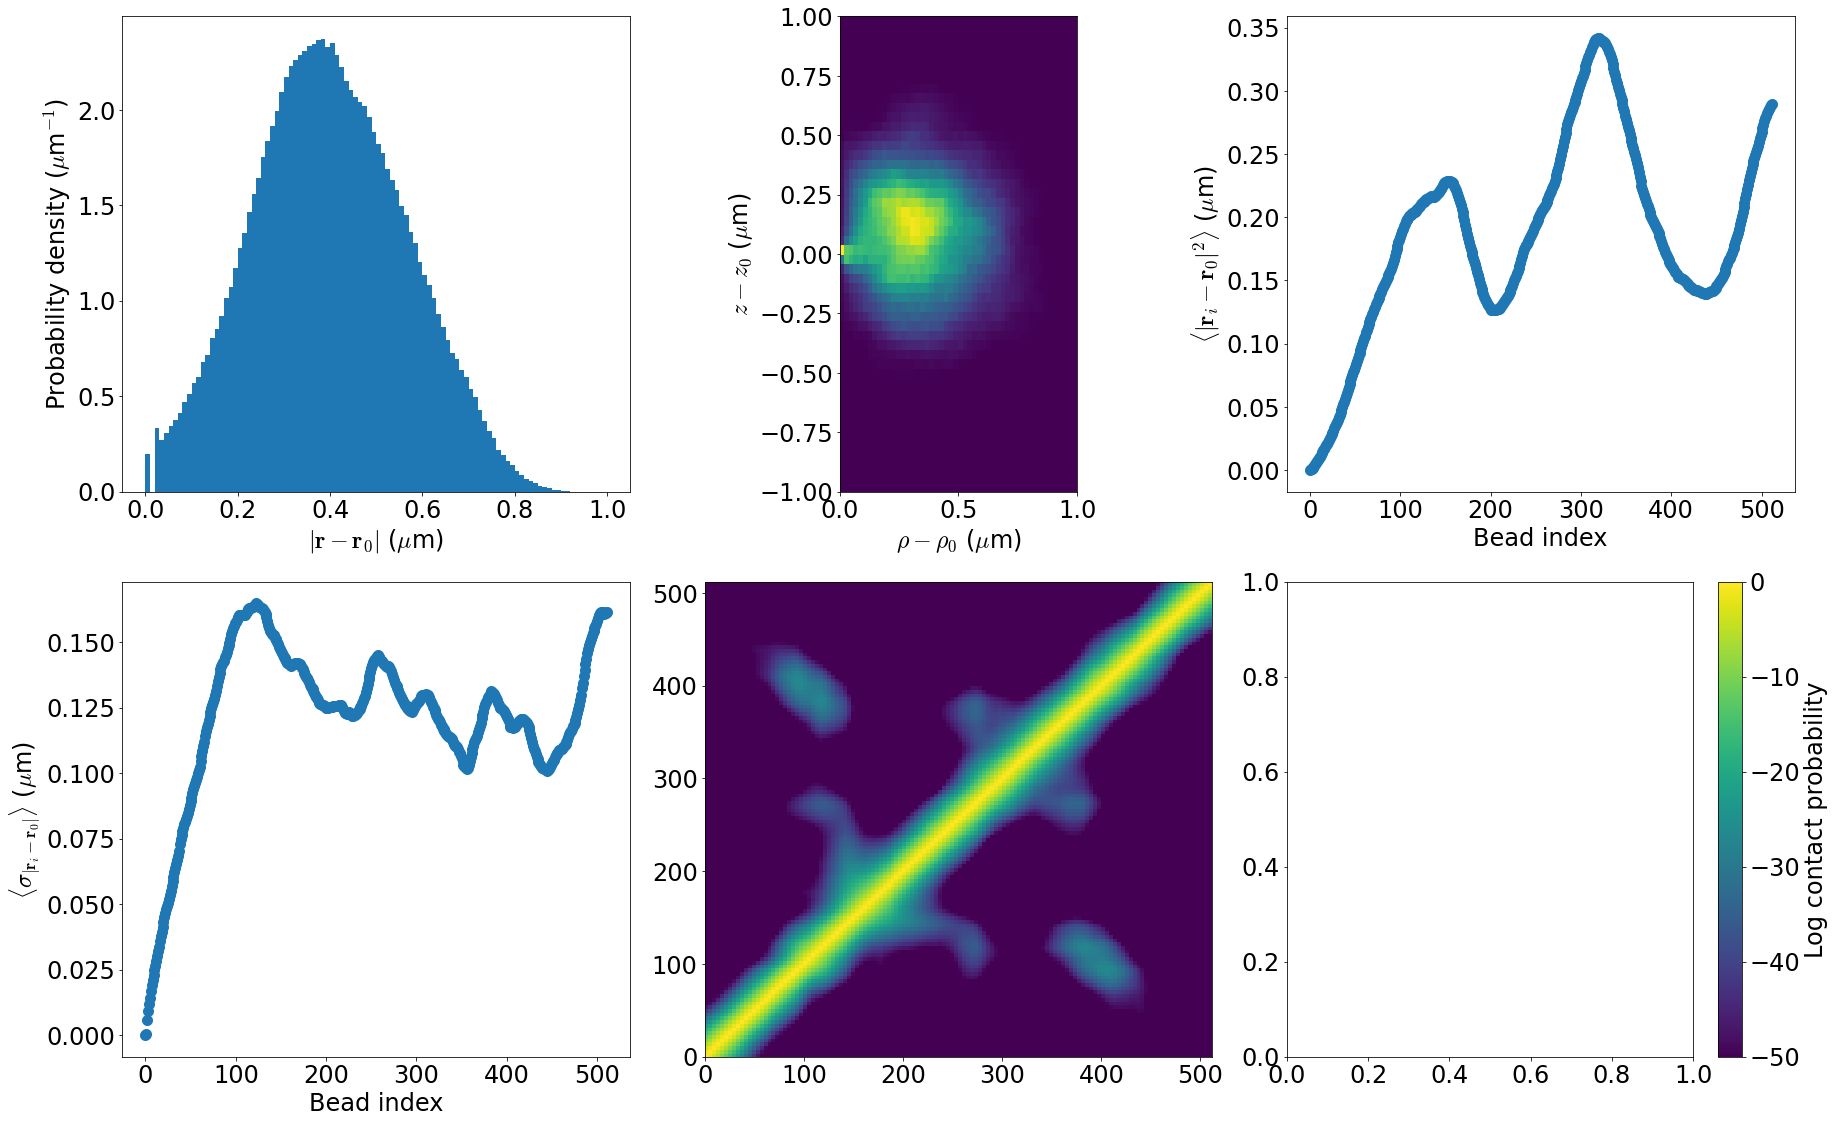

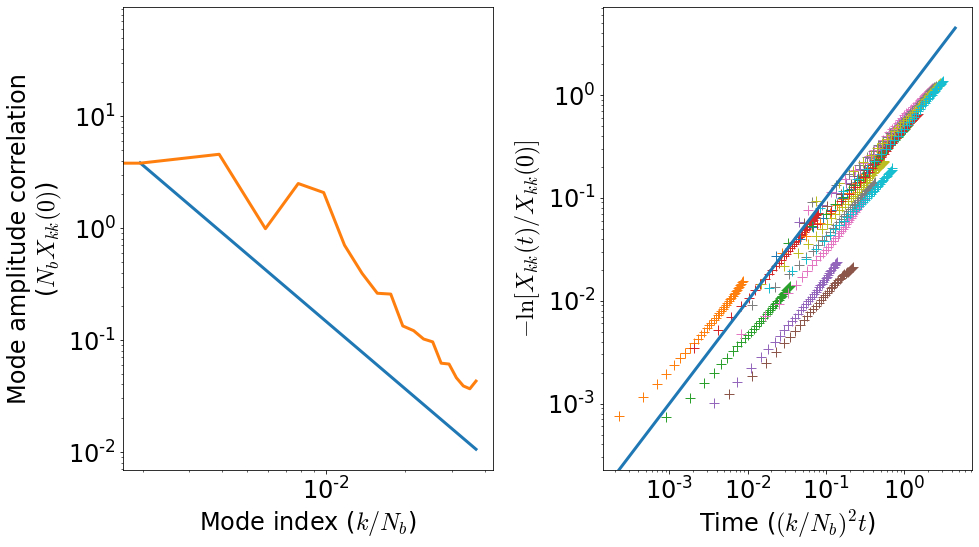

In [188]:
data_path = Path("21-04-23_AMchr1_line512_scan5.1_dt.001-.1/simulations/dt0.010/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)
    
    ##com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_total_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

### dt0.003

(20, 1802)


<ipython-input-182-967d01ee41eb>:65: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)


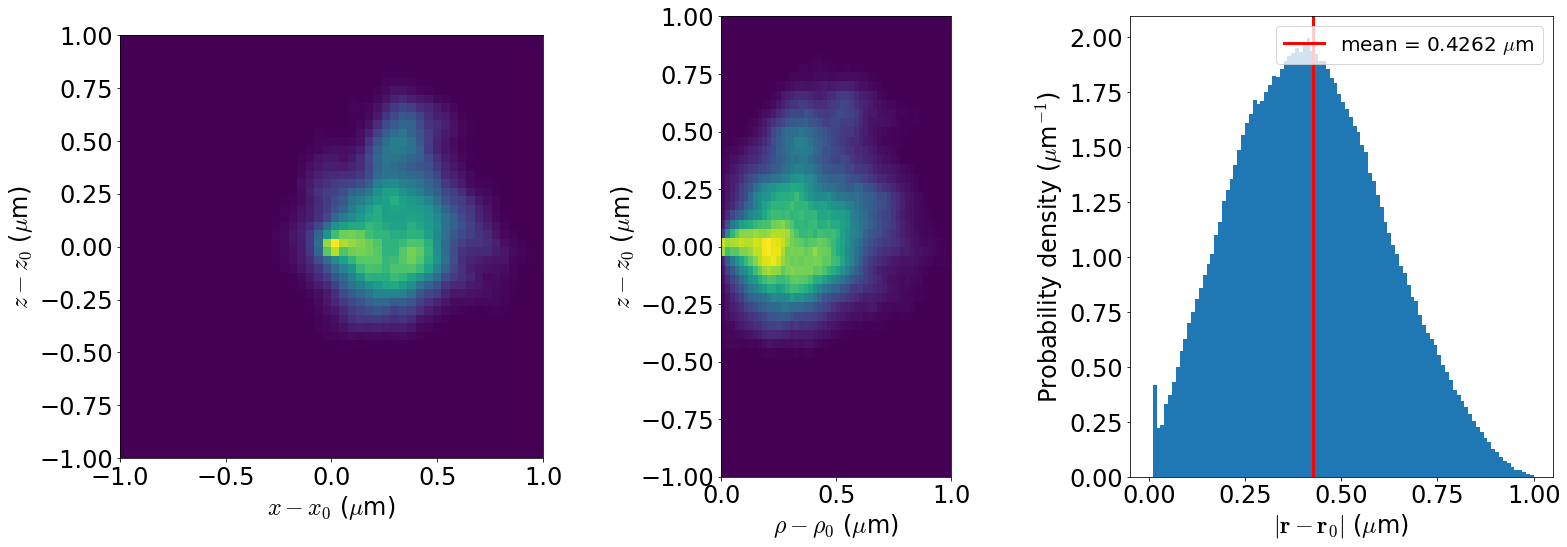

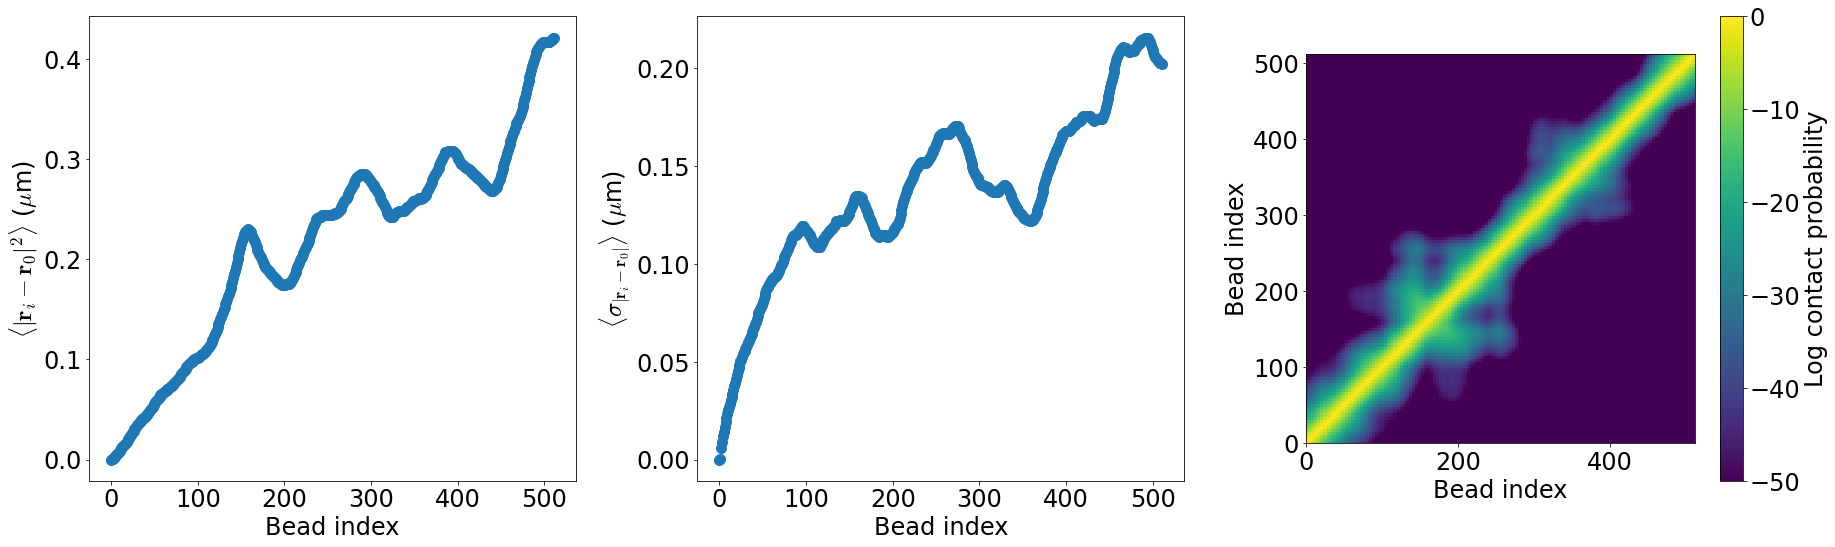

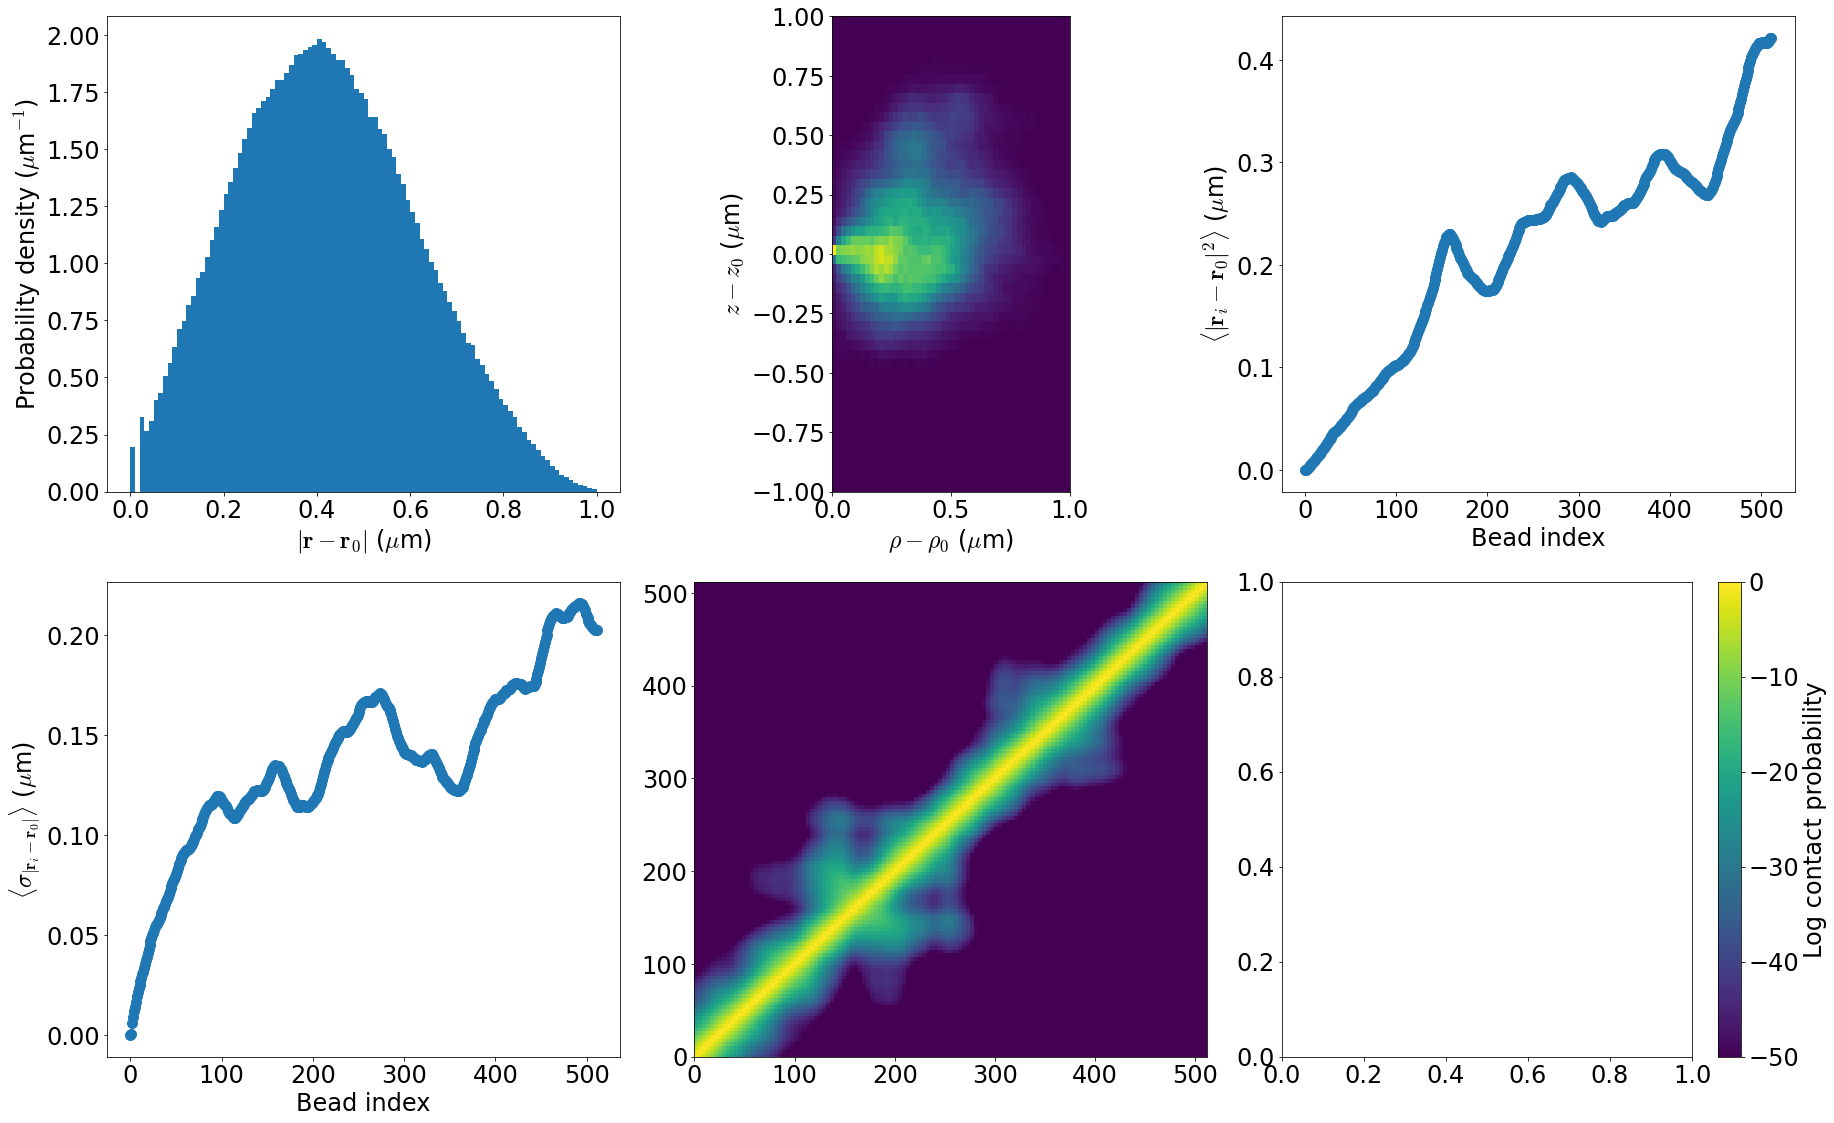

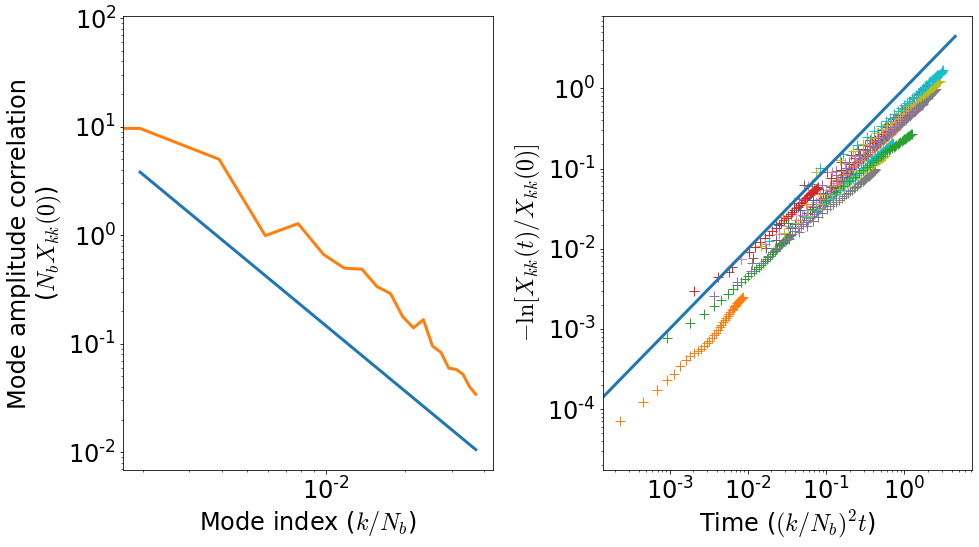

In [201]:
data_path = Path("21-04-23_AMchr1_line512_scan5.1_dt.001-.1/simulations/dt0.003/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)
    
    ##com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_total_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

### dt0.001

In [ ]:
data_path = Path("21-04-23_AMchr1_line512_scan5.1_dt.001-.1/simulations/dt0.001/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)
    
    ##com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_total_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

## 512 RS line scan dt.001-.1

### dt0.1

(20, 3602)


<ipython-input-182-967d01ee41eb>:65: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)


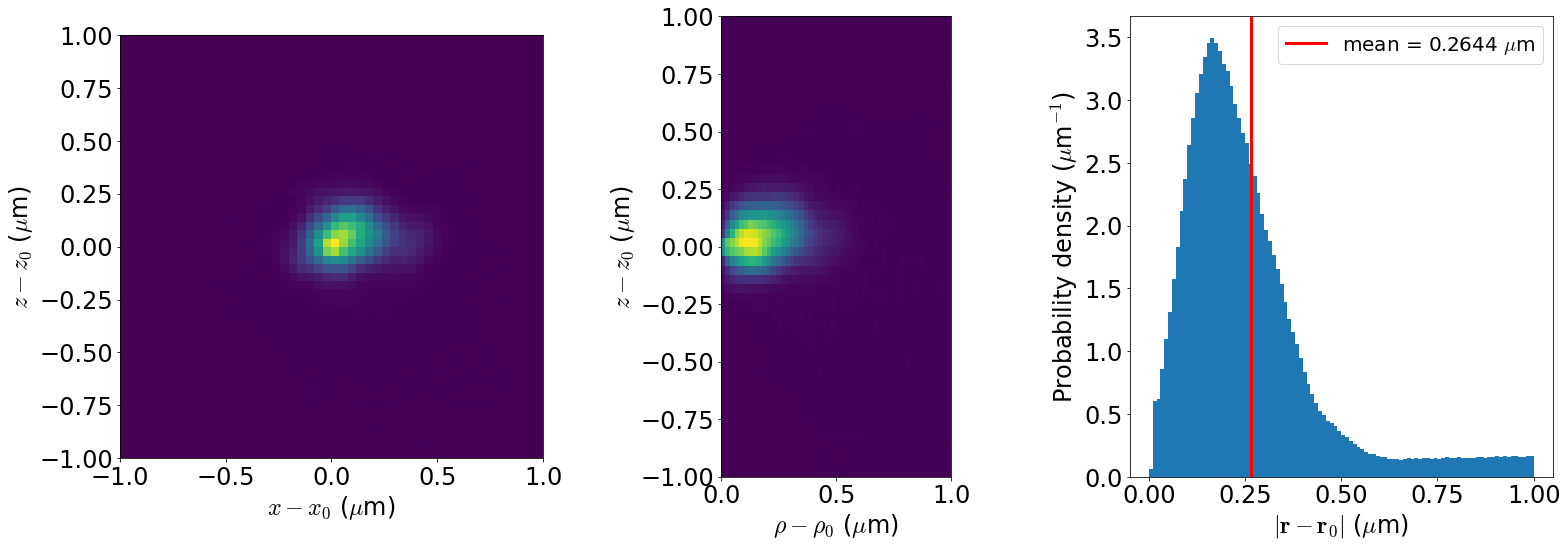

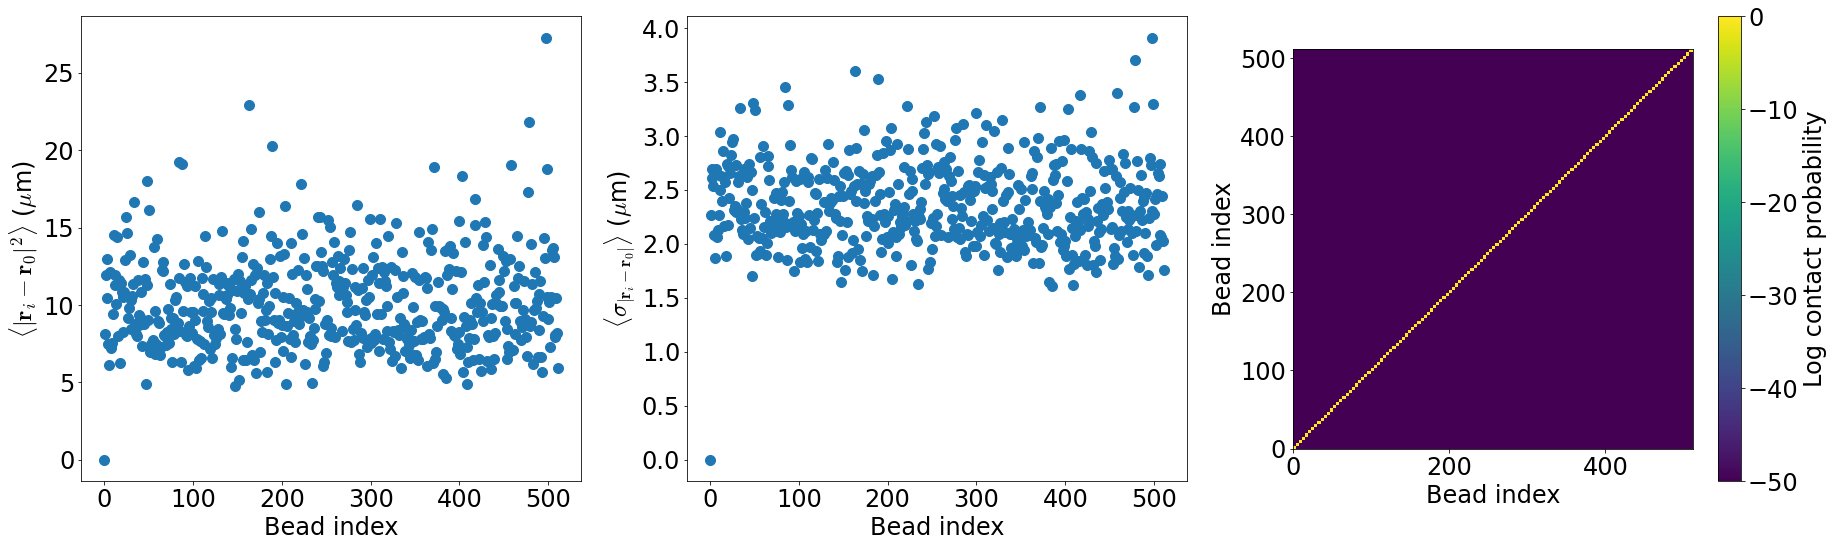

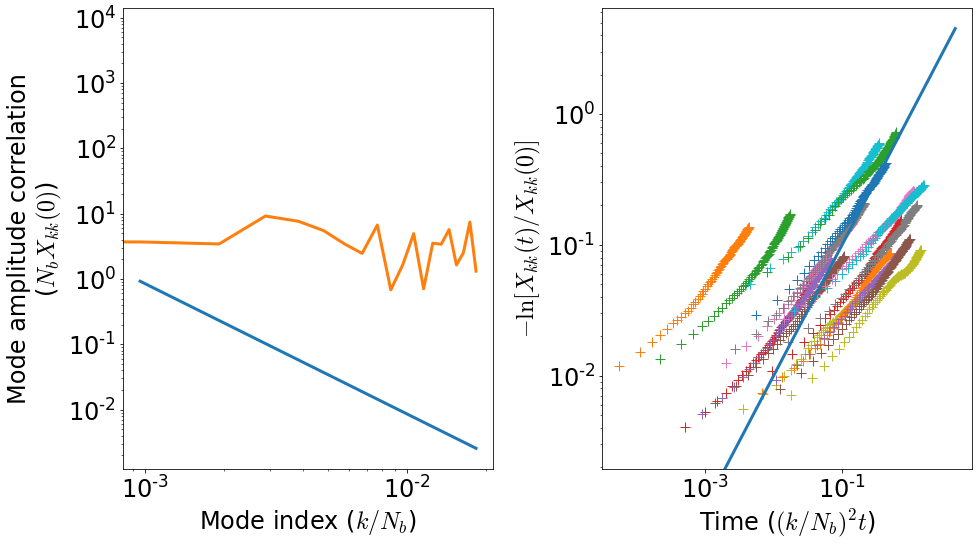

In [203]:
data_path = Path("21-04-23_AMchr1_RS_line512_scan5.1_dt.001-.1/simulations/dt0.100/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)
    
    ##com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

#Graphing
make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
#fig2, ax2 = make_total_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=80)



### dt0.030

(20, 3602)


<ipython-input-182-967d01ee41eb>:65: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)


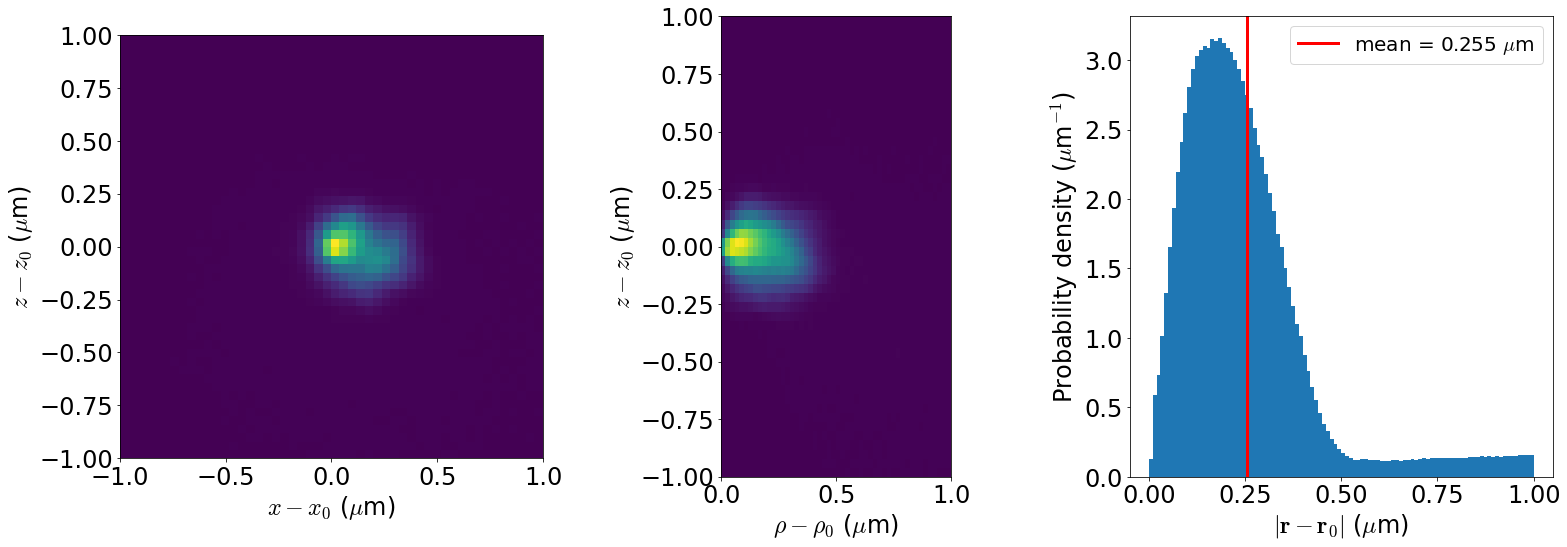

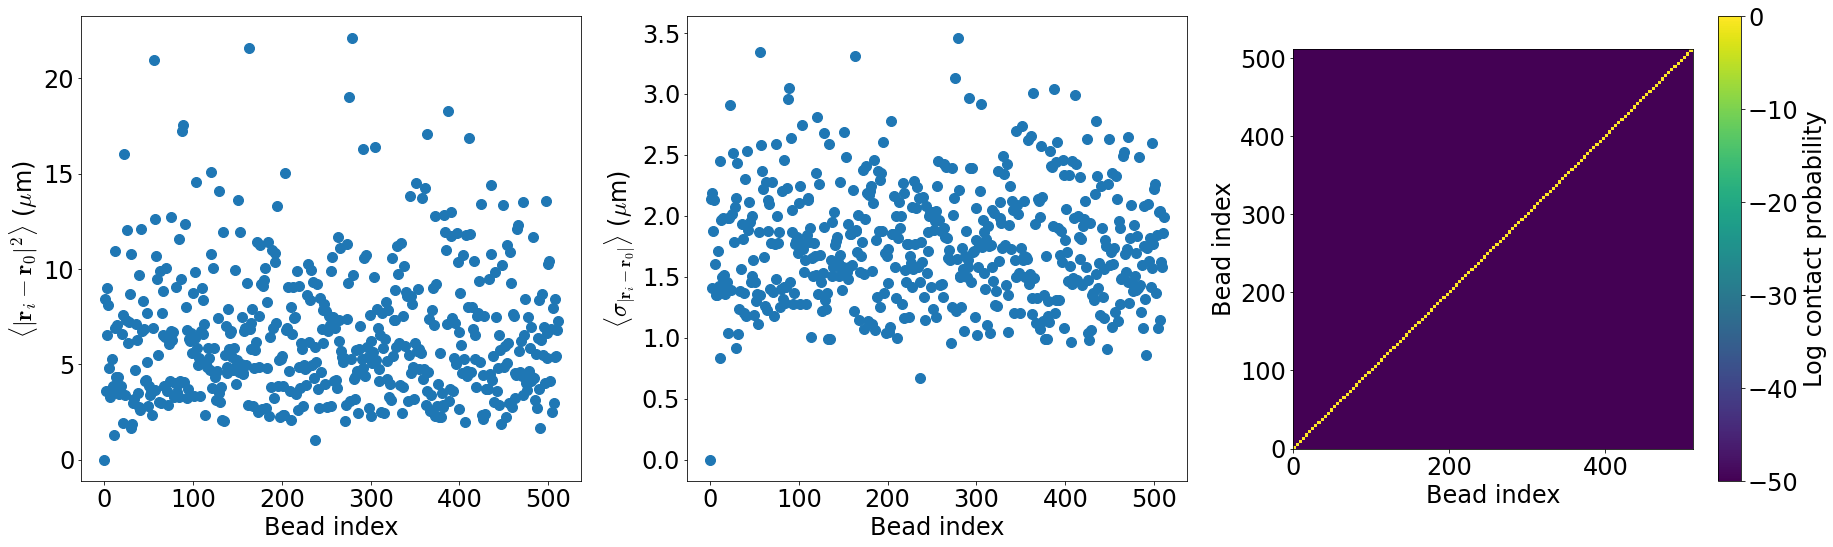

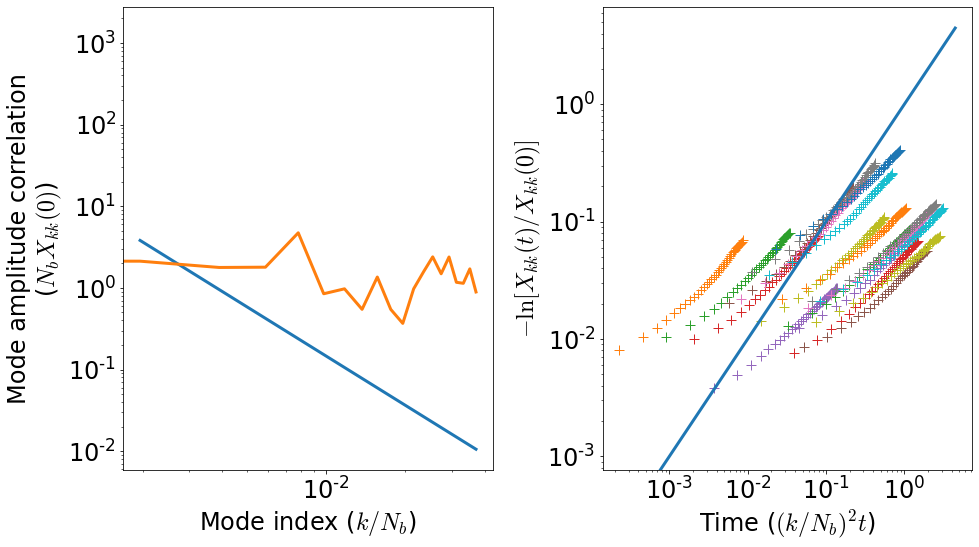

In [204]:
data_path = Path("21-04-23_AMchr1_RS_line512_scan5.1_dt.001-.1/simulations/dt0.030/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)
    
    ##com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
#fig2, ax2 = make_total_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

### dt0.01

(20, 3602)


<ipython-input-182-967d01ee41eb>:65: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)


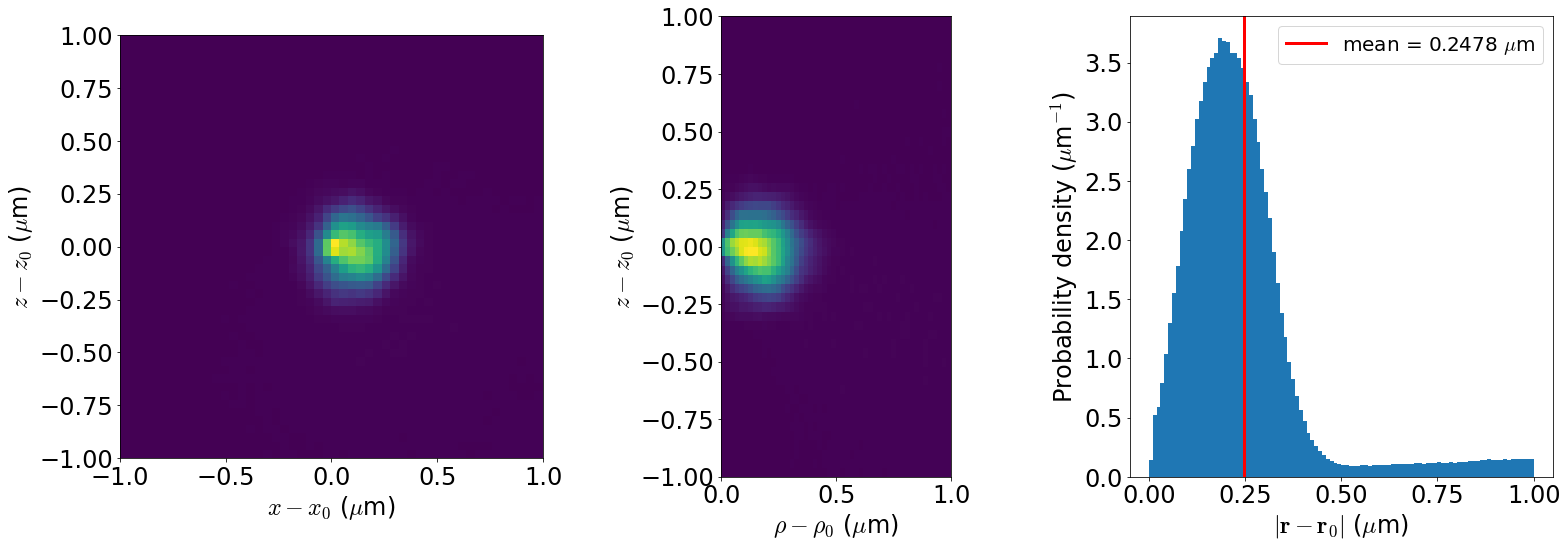

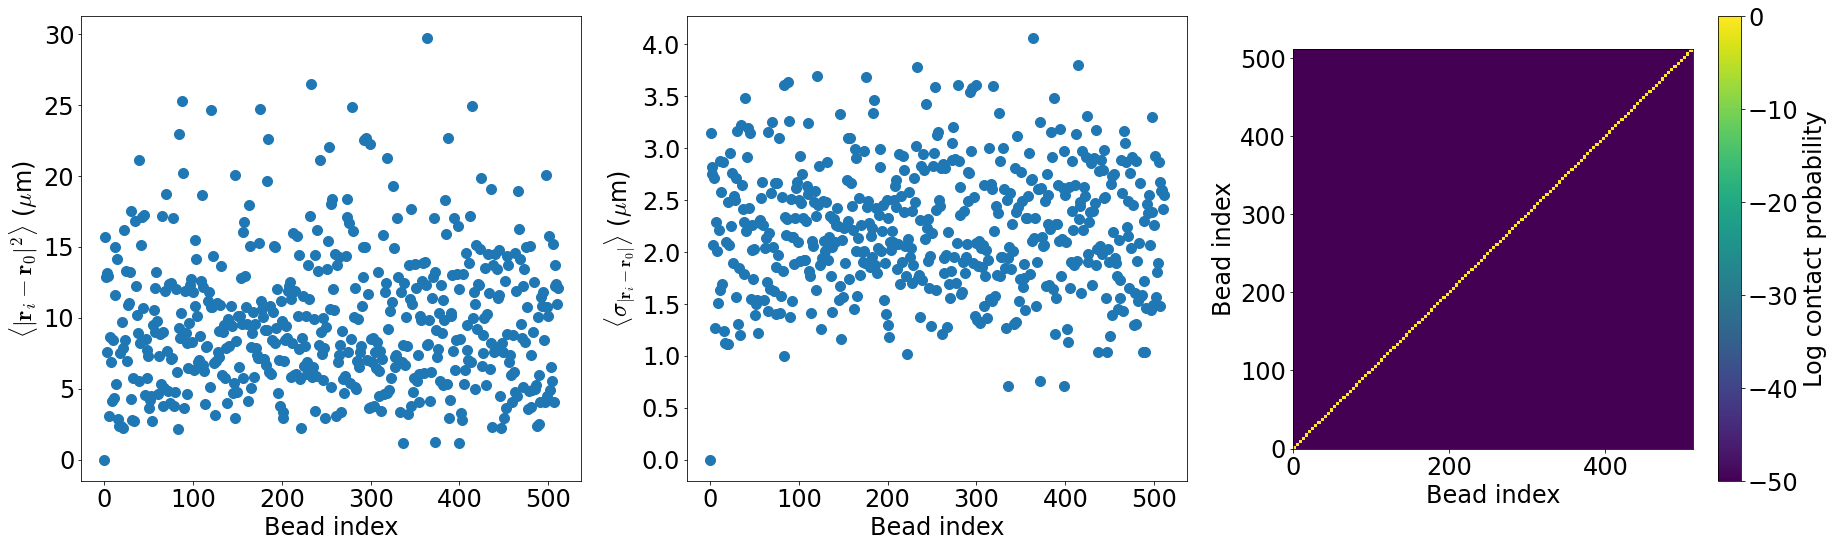

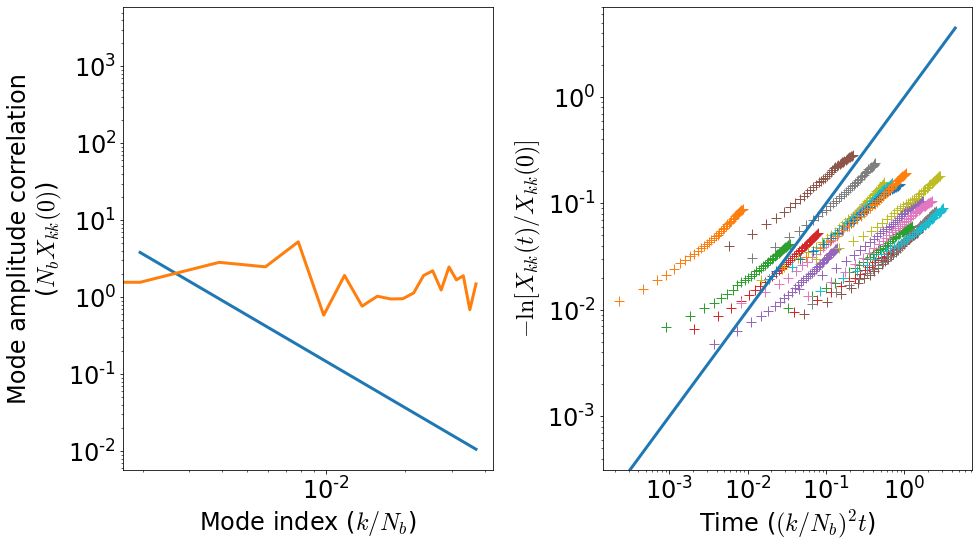

In [206]:
data_path = Path("21-04-23_AMchr1_RS_line512_scan5.1_dt.001-.1/simulations/dt0.010/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)
    
    ##com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
#fig2, ax2 = make_total_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

### dt0.003

(20, 1802)


<ipython-input-182-967d01ee41eb>:65: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)
<ipython-input-182-967d01ee41eb>:70: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-182-967d01ee41eb>:70: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-182-967d01ee41eb>:70: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')


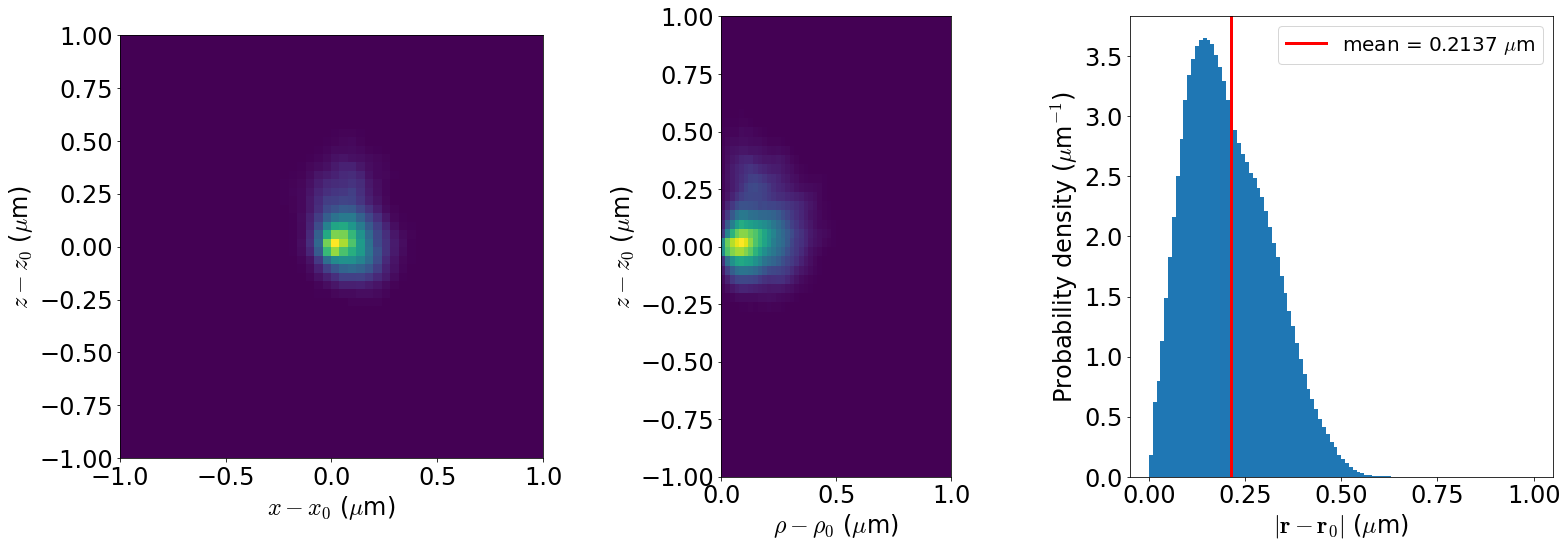

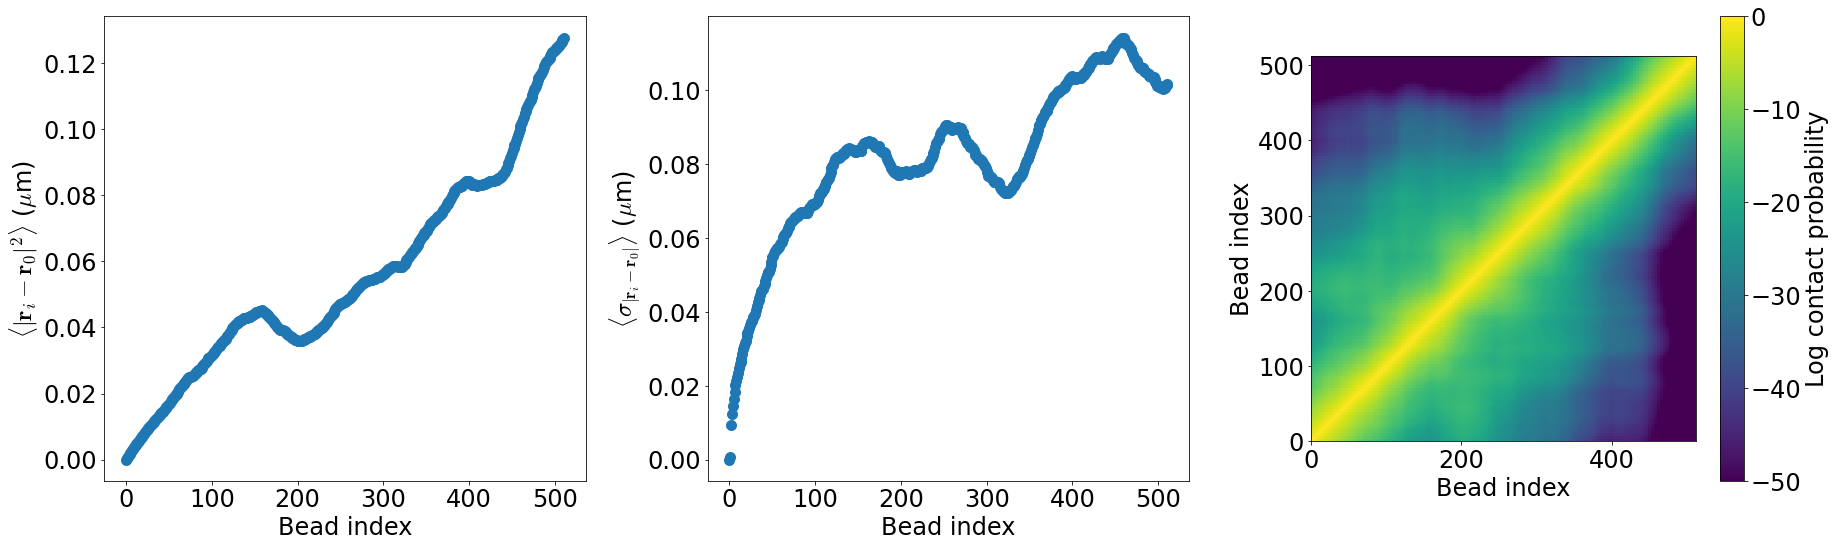

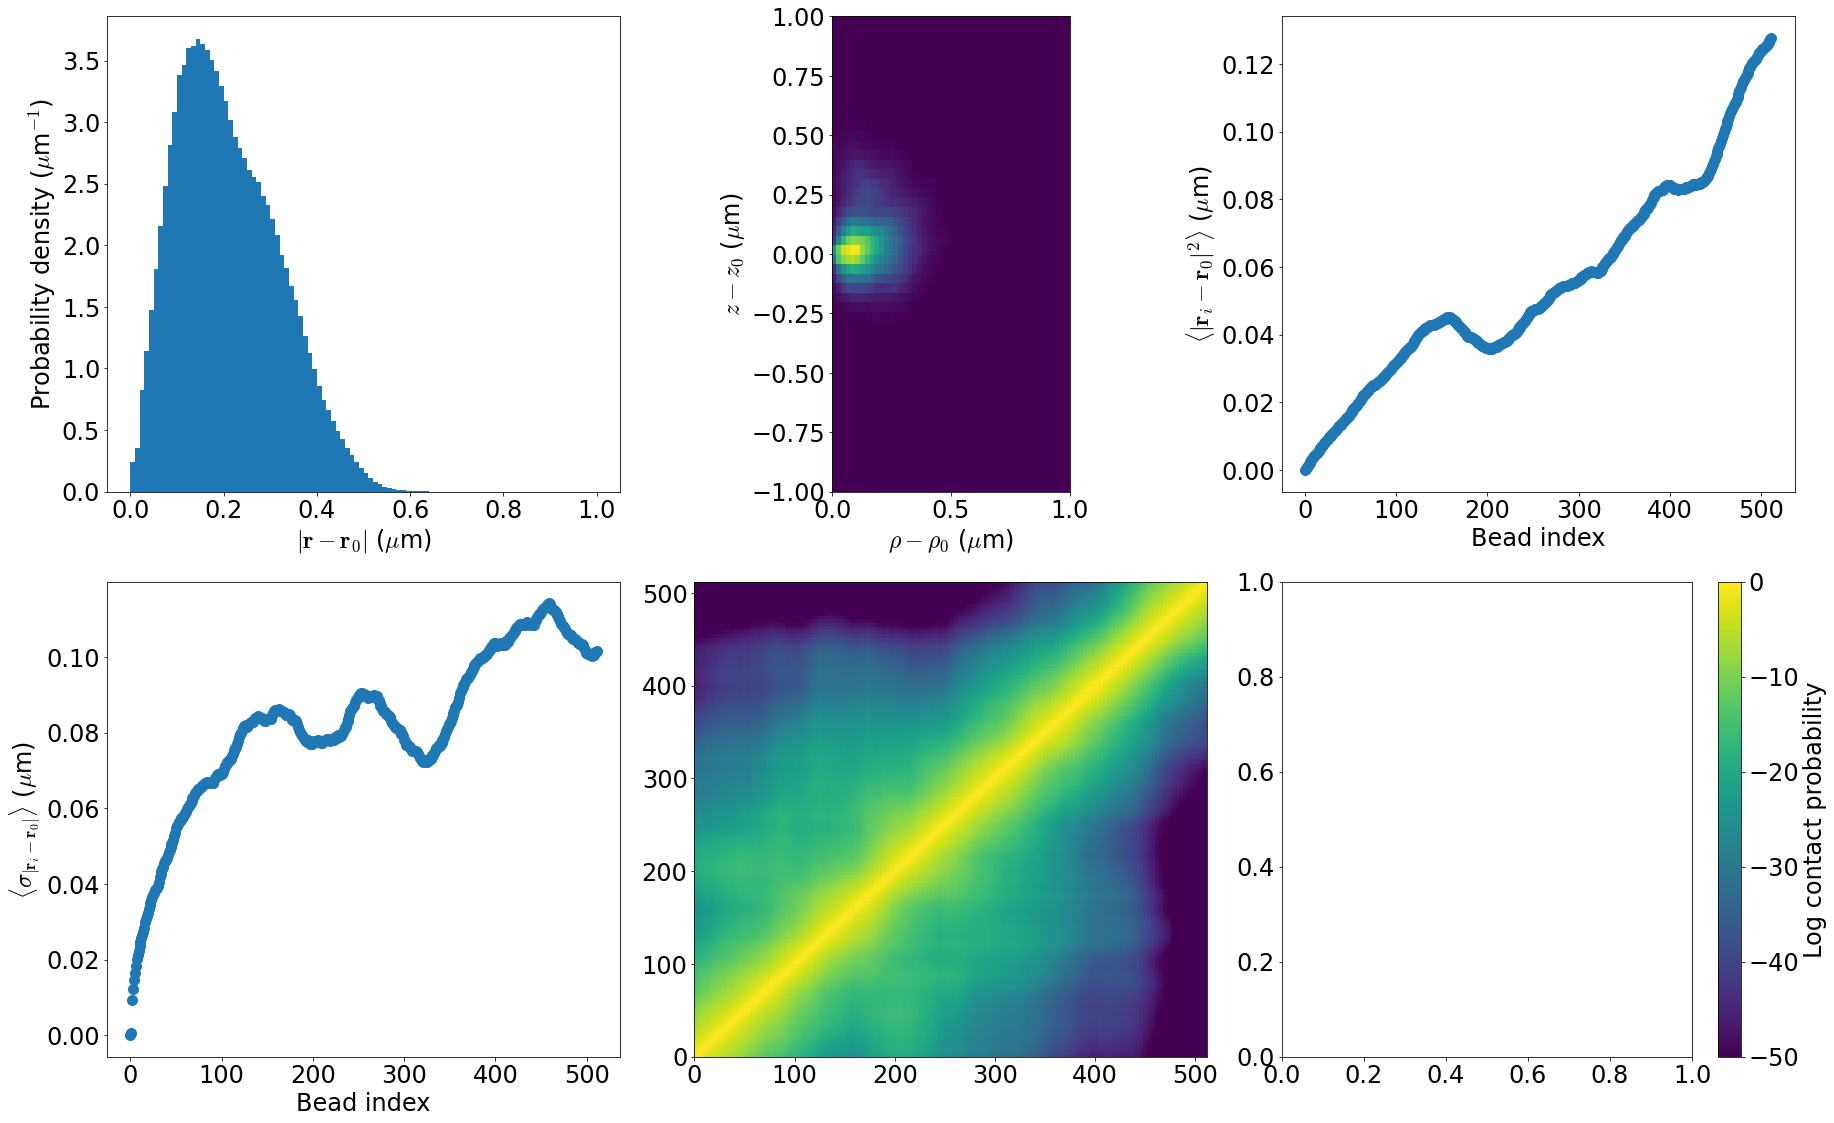

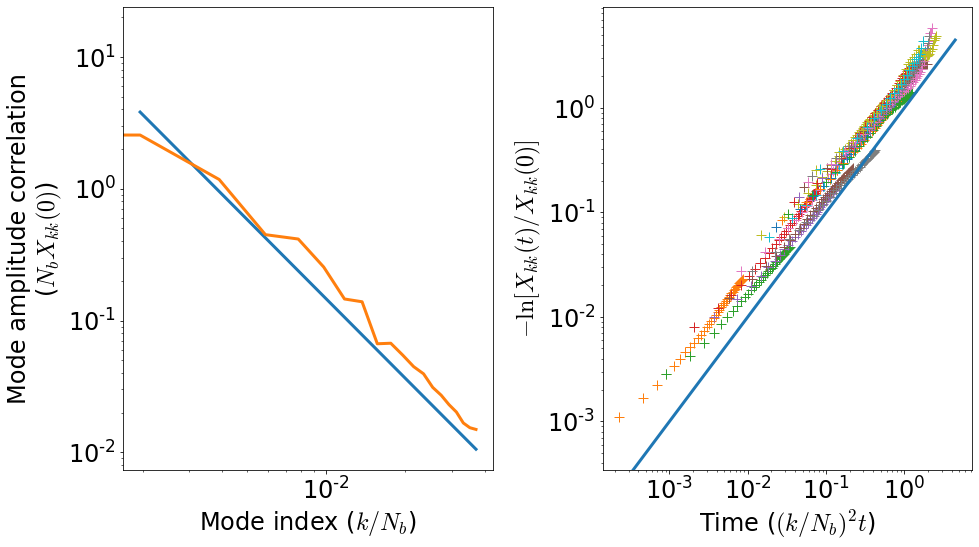

In [194]:
data_path = Path("21-04-23_AMchr1_RS_line512_scan5.1_dt.001-.1/simulations/dt0.003/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)
    
    ##com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_total_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

(20, 1802)


<ipython-input-182-967d01ee41eb>:65: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)
<ipython-input-182-967d01ee41eb>:70: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-182-967d01ee41eb>:70: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-182-967d01ee41eb>:70: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-182-967d01ee41eb>:70: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-182-967d01ee41eb>:70: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-182-967d01ee41eb>:70: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind

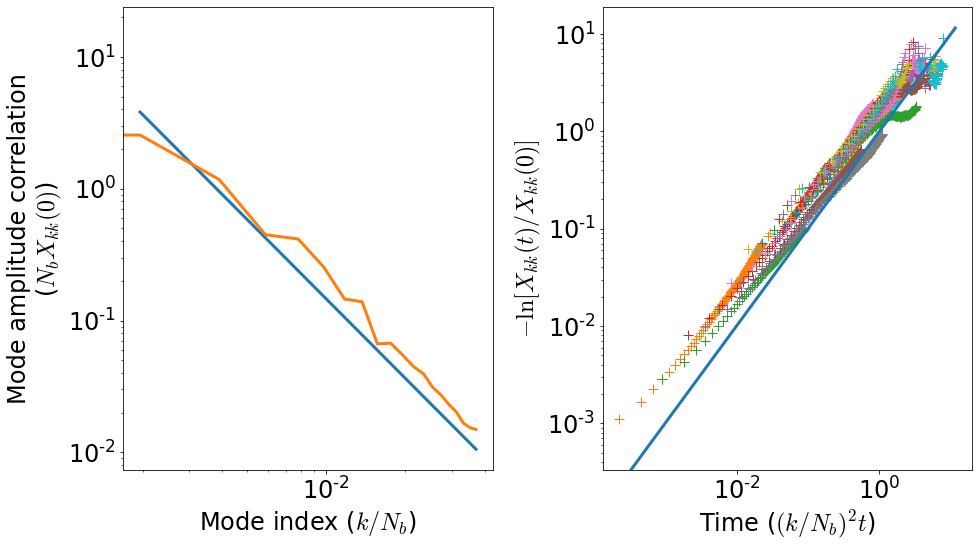

In [197]:
# Graphing
#make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
#fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
#fig2, ax2 = make_total_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=100)

### dt0.001

In [ ]:
data_path = Path("21-04-23_AMchr1_RS_line512_scan5.1_dt.001-.1/simulations/dt0.001/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)
    
    ##com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_total_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

## 512 RS $l_o=0$ line

<ipython-input-220-202214081dae>:85: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)
<ipython-input-220-202214081dae>:90: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-220-202214081dae>:90: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-220-202214081dae>:90: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-220-202214081dae>:90: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-220-202214081dae>:90: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-220-202214081dae>:90: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind

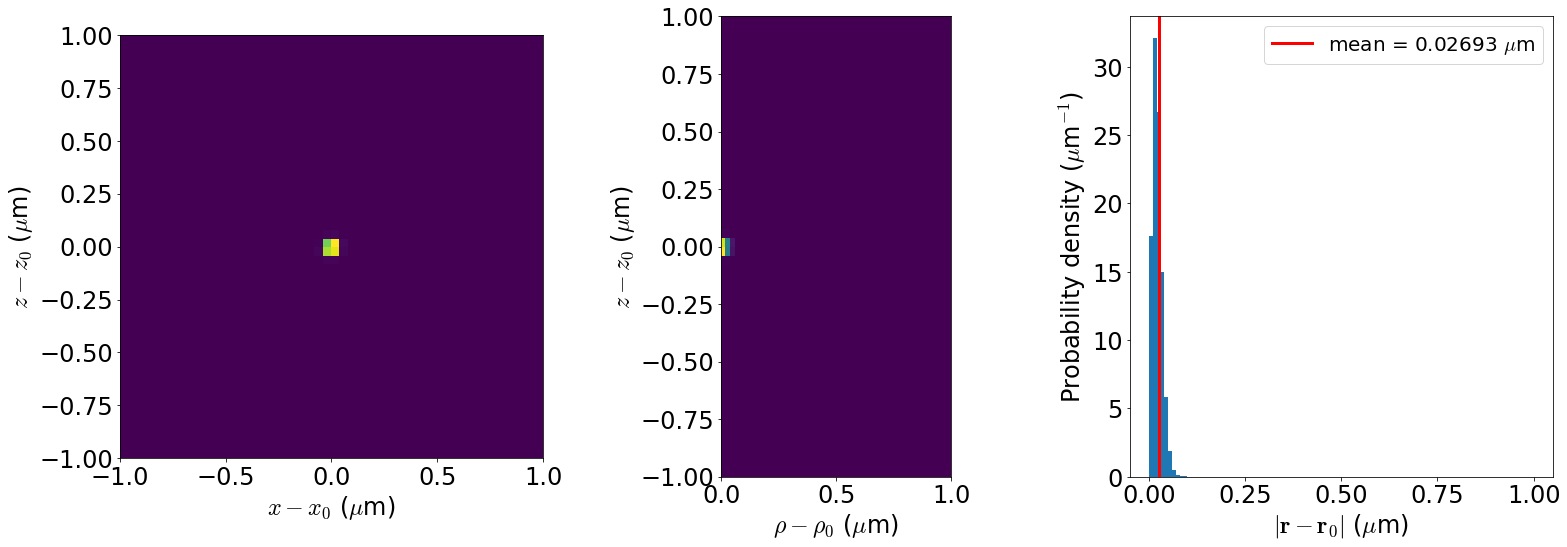

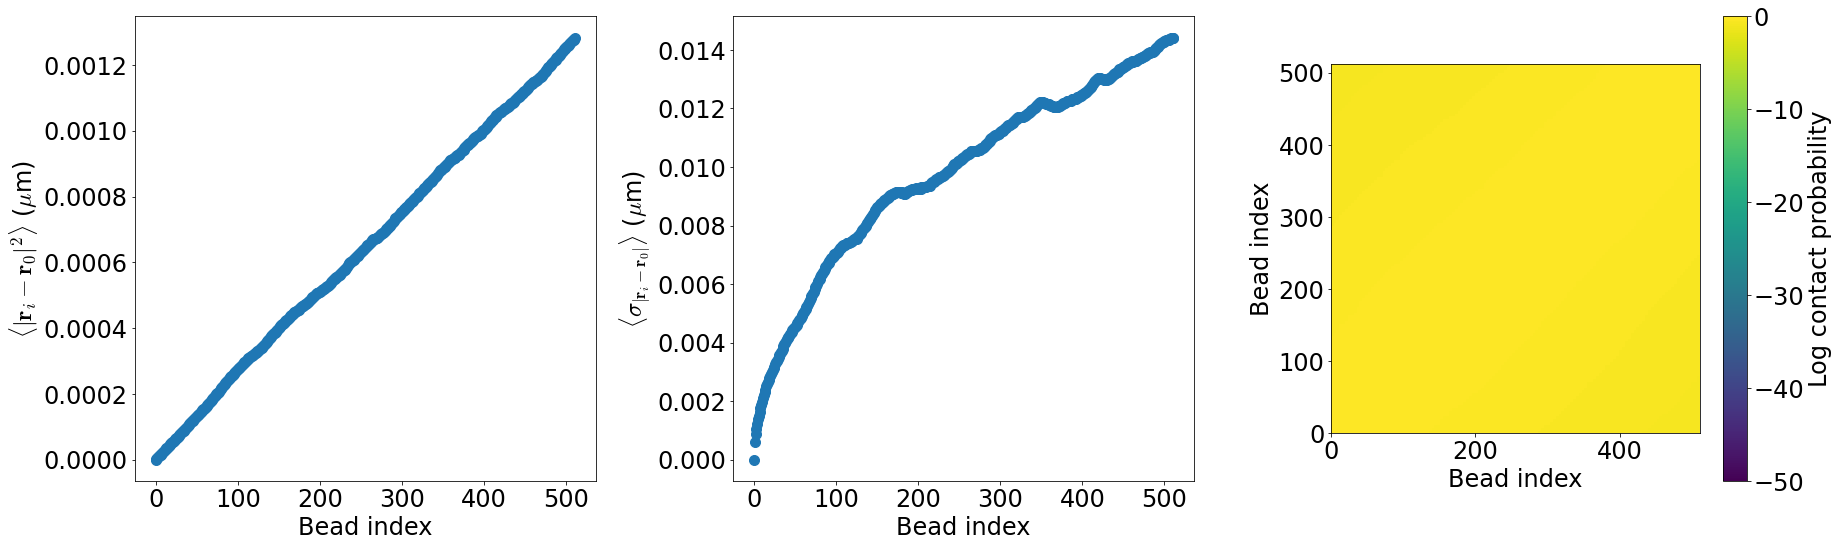

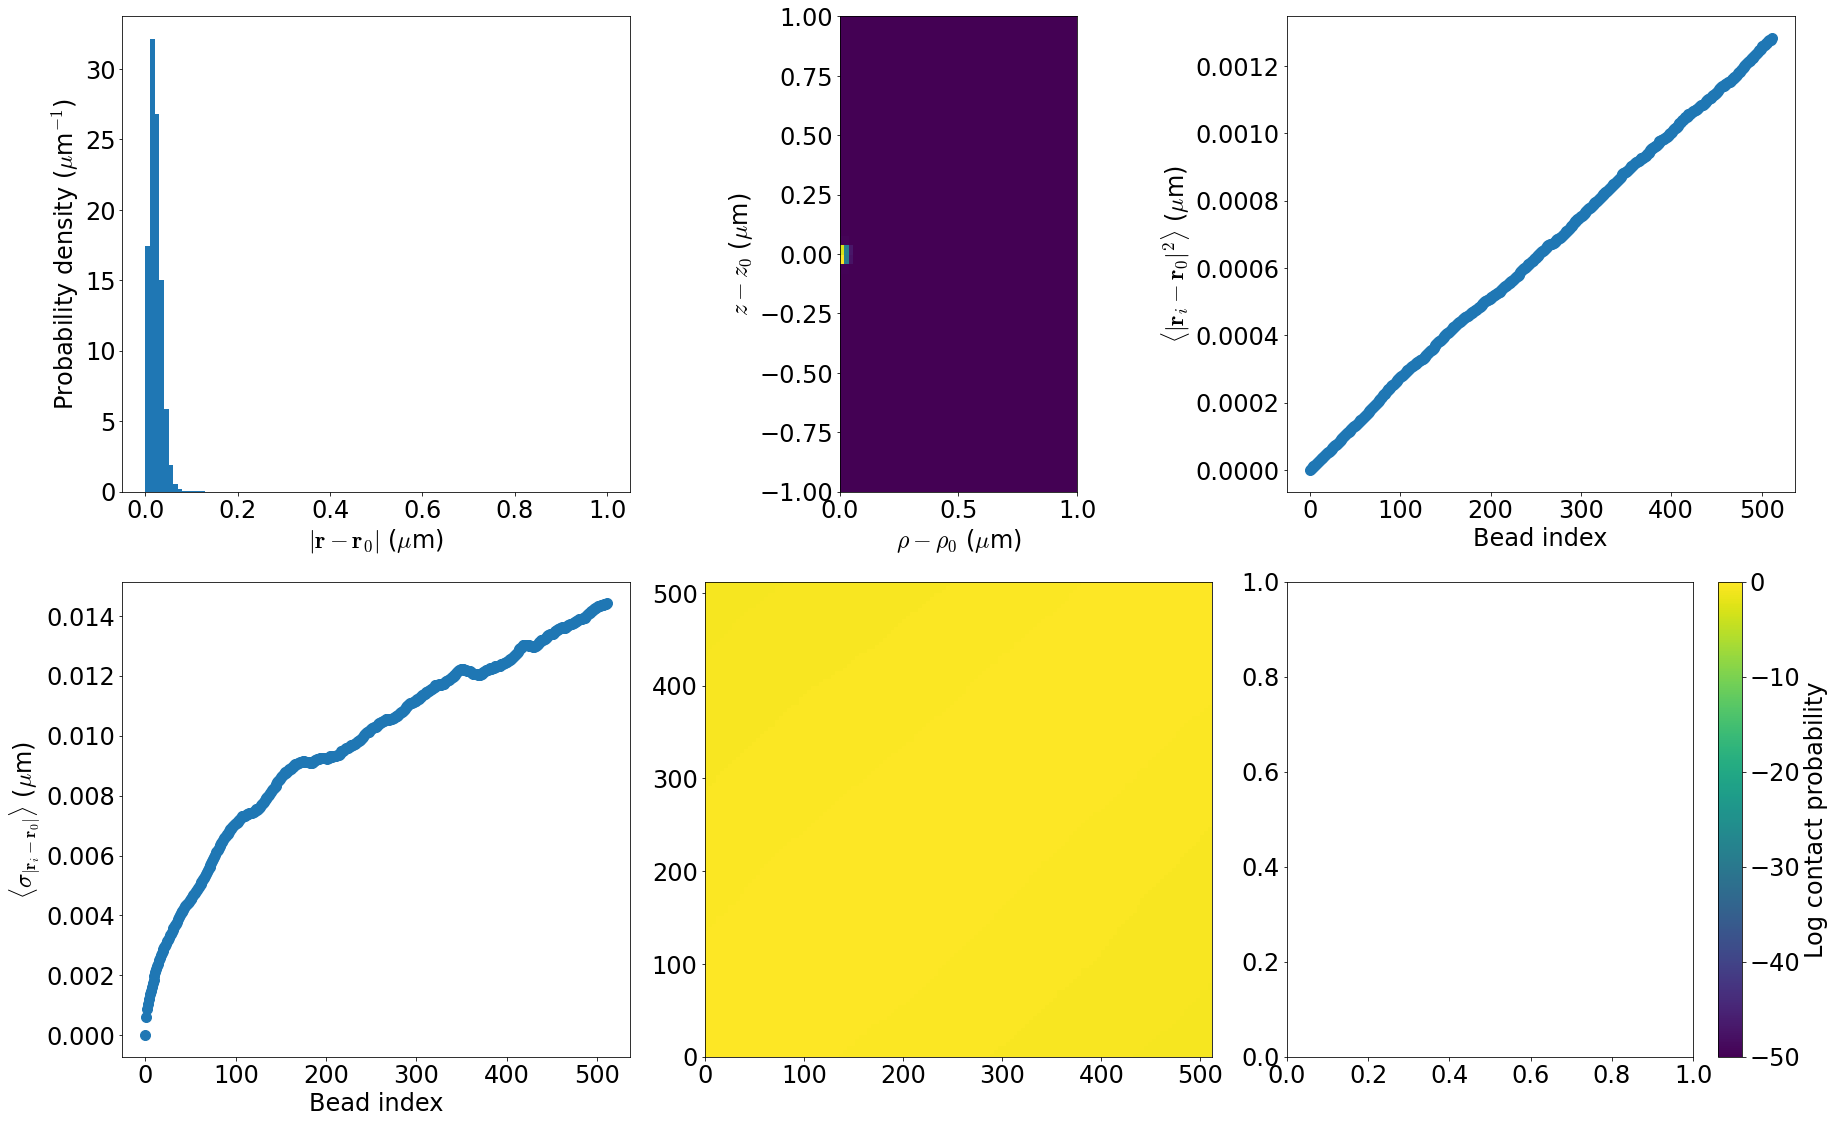

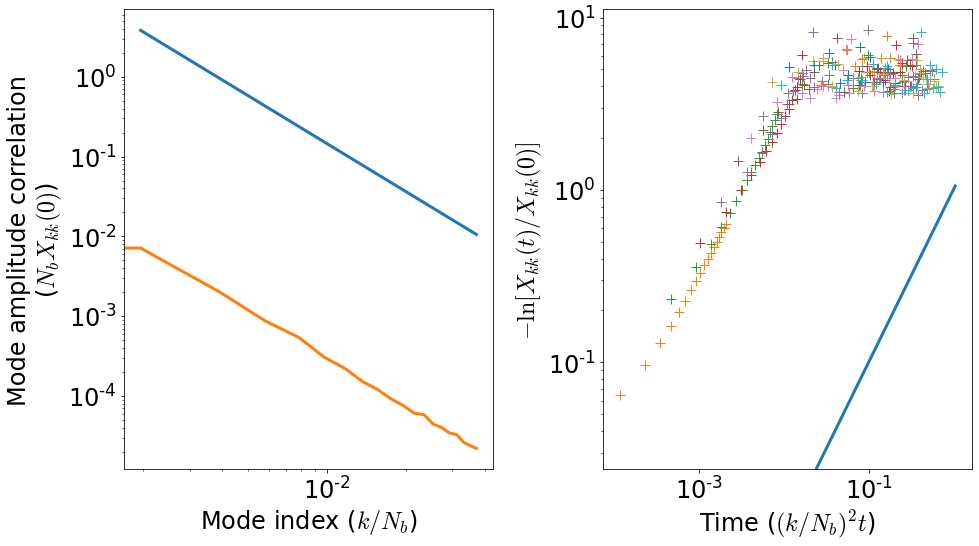

In [223]:
data_path = Path("21-04-29_AMchr1_RS_line512_lo0/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    ##com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_total_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=20)

## 512 RS $l_o=0$ line equil

<ipython-input-242-7bc174632697>:91: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)
<ipython-input-242-7bc174632697>:96: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-242-7bc174632697>:96: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-242-7bc174632697>:96: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-242-7bc174632697>:96: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-242-7bc174632697>:96: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-242-7bc174632697>:96: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind

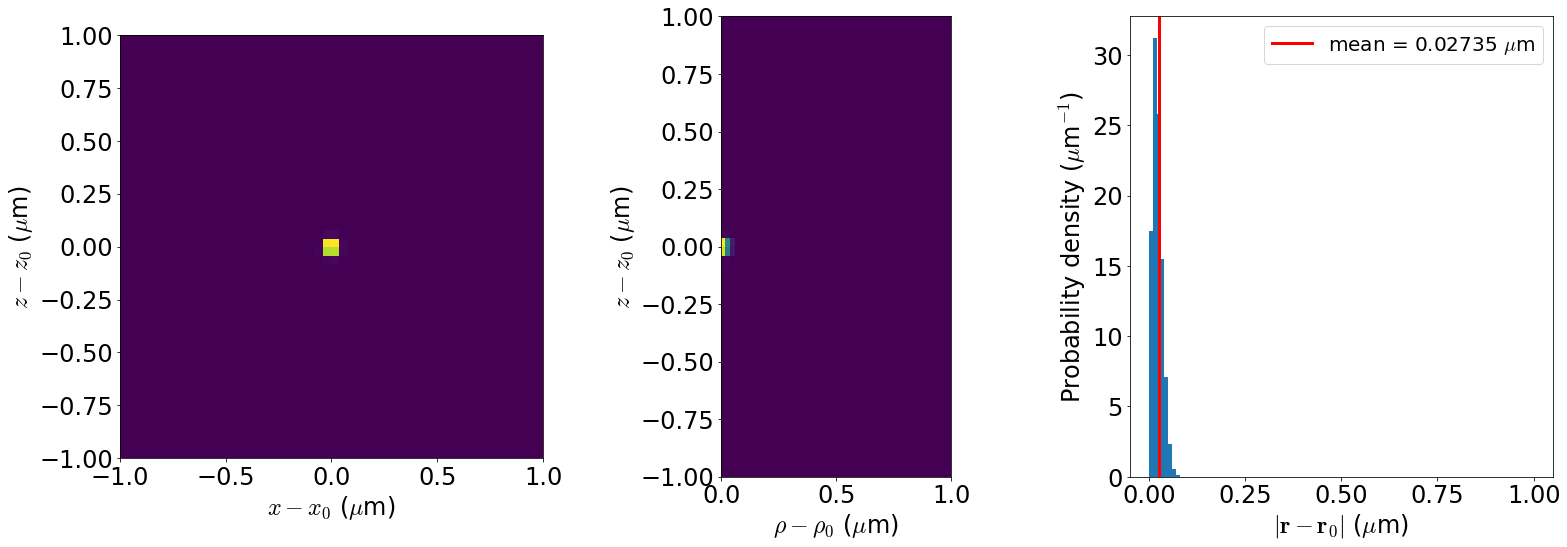

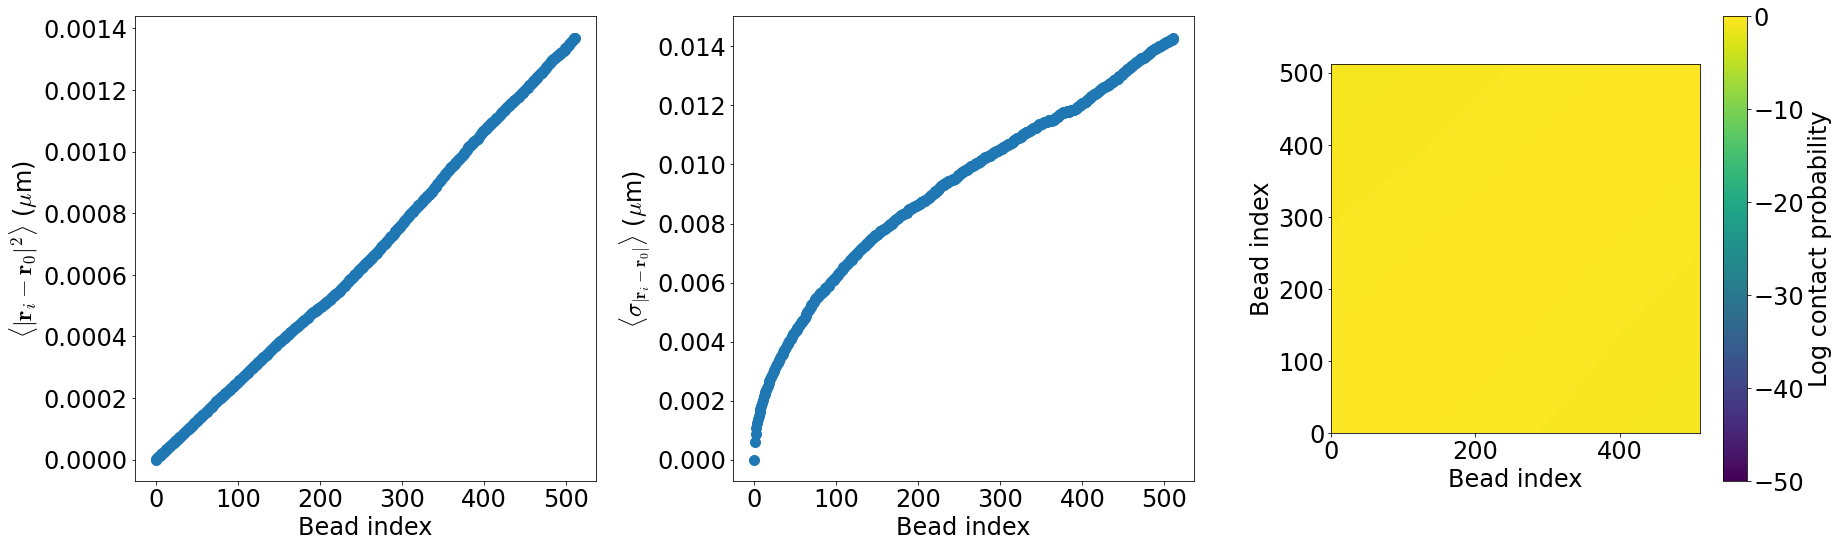

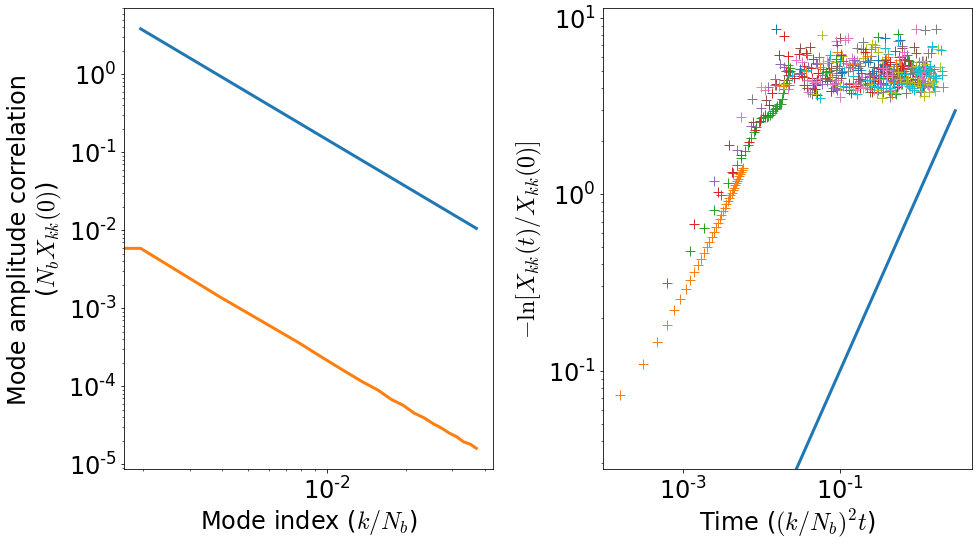

In [273]:
data_path = Path("21-05-07_AMchr1_RS_line512eq_lo0/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    ##com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
fig0, ax0 = make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

## 512 RS $l_o=0, k_l=36.50$ line

<ipython-input-229-95cbb5041cfa>:85: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)
<ipython-input-229-95cbb5041cfa>:90: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-229-95cbb5041cfa>:90: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-229-95cbb5041cfa>:90: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')


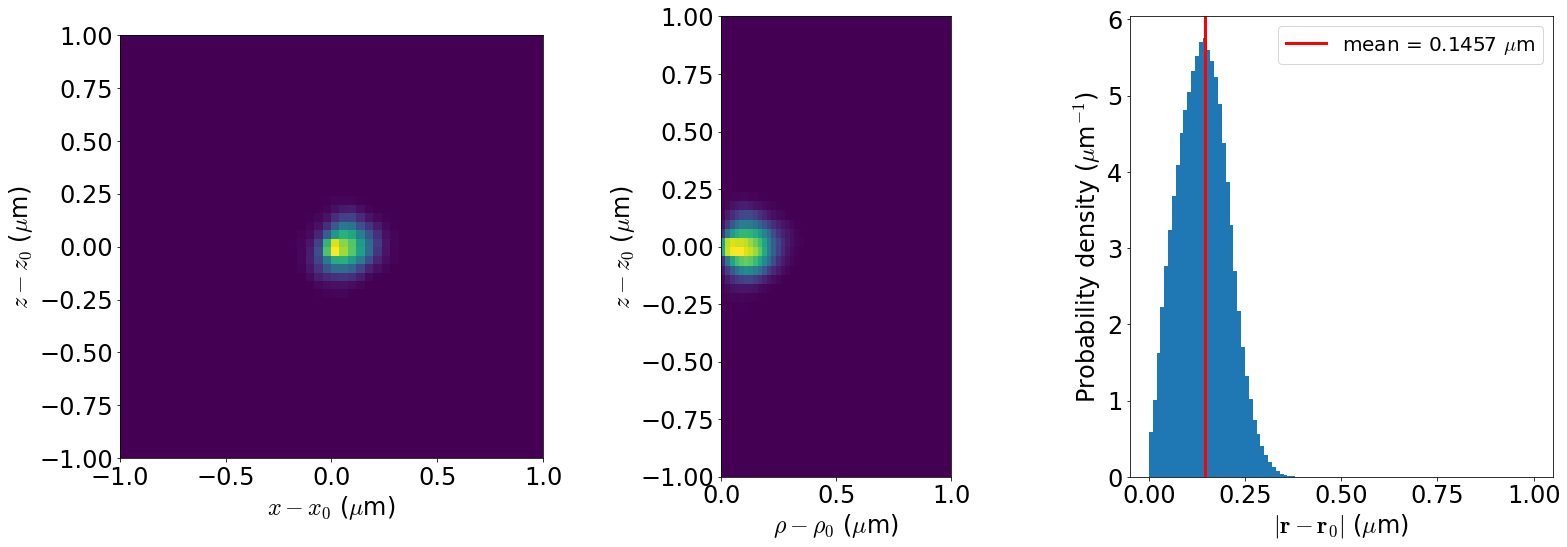

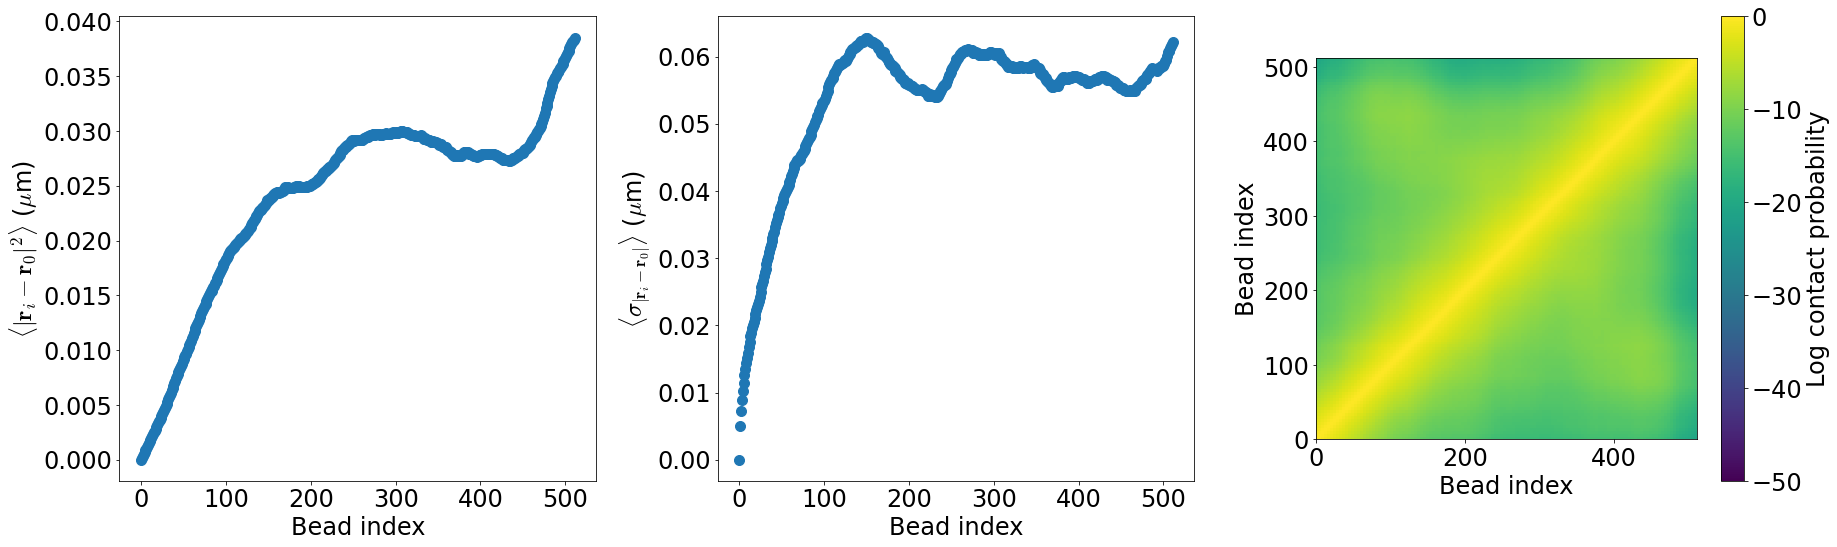

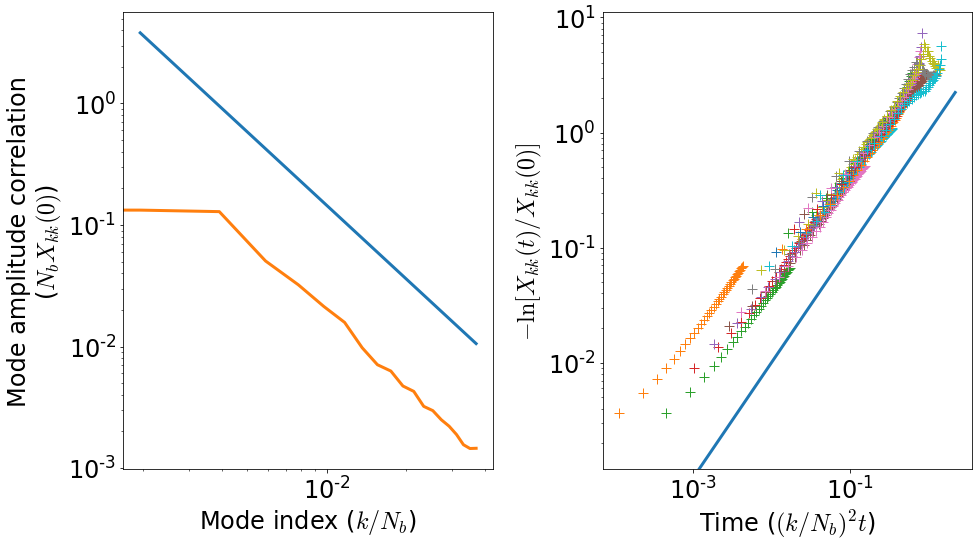

In [232]:
data_path = Path("21-04-29_AMchr1_RS_line512_lo0_kl36.50/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
fig0, ax0 = make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

## 512 RS $l_o=0, k_l=36.50$ line equil

<ipython-input-242-7bc174632697>:91: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e6)
<ipython-input-242-7bc174632697>:96: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-242-7bc174632697>:96: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-242-7bc174632697>:96: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-242-7bc174632697>:96: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')


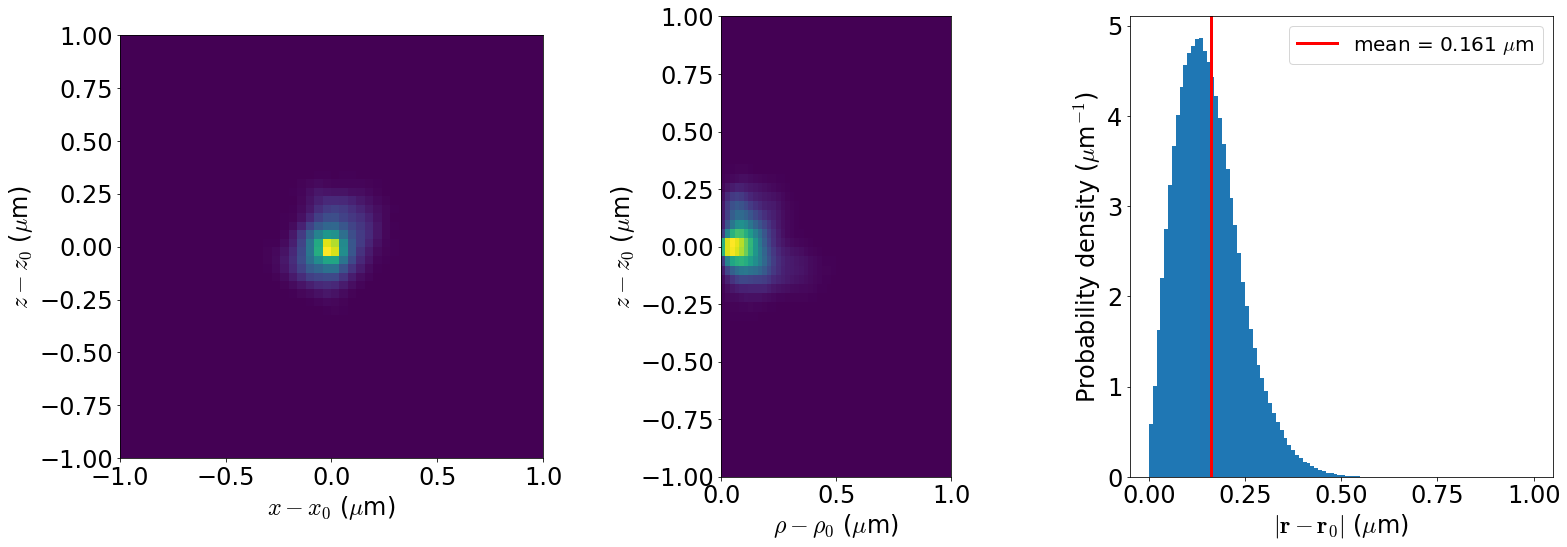

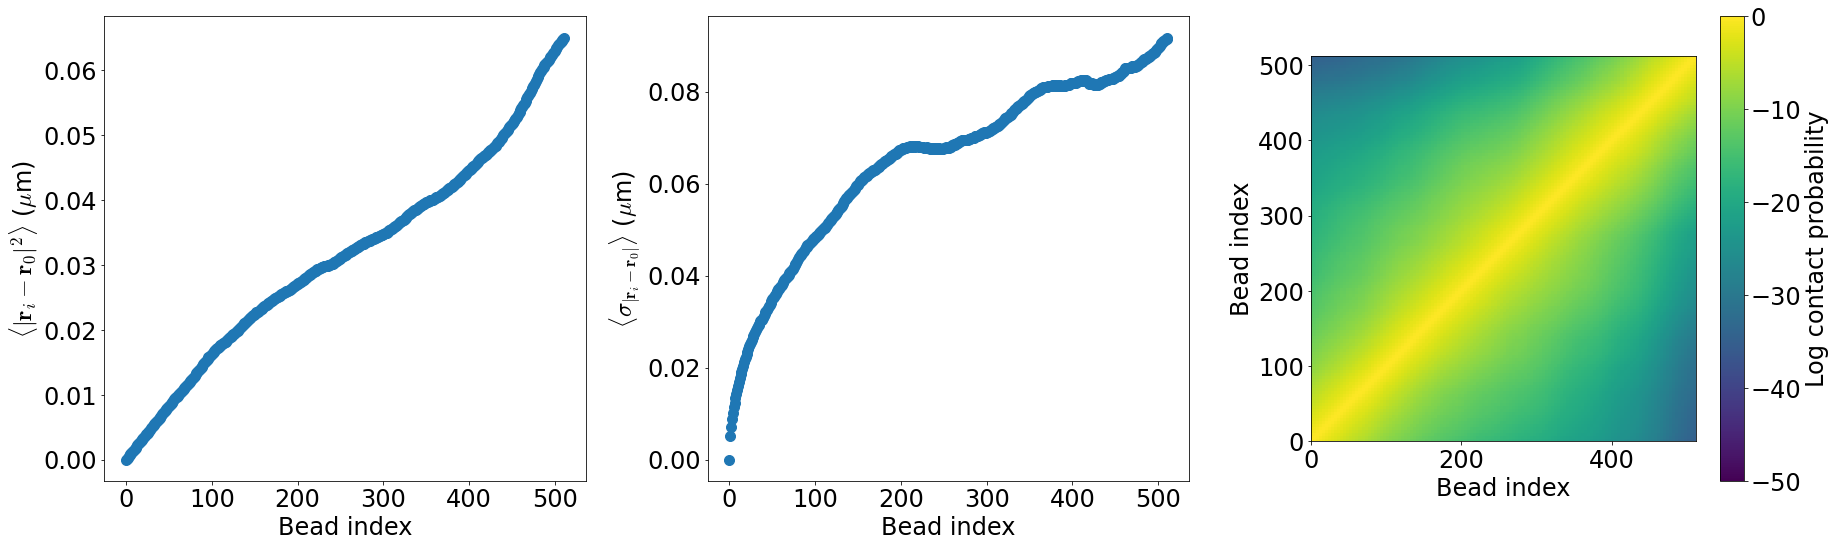

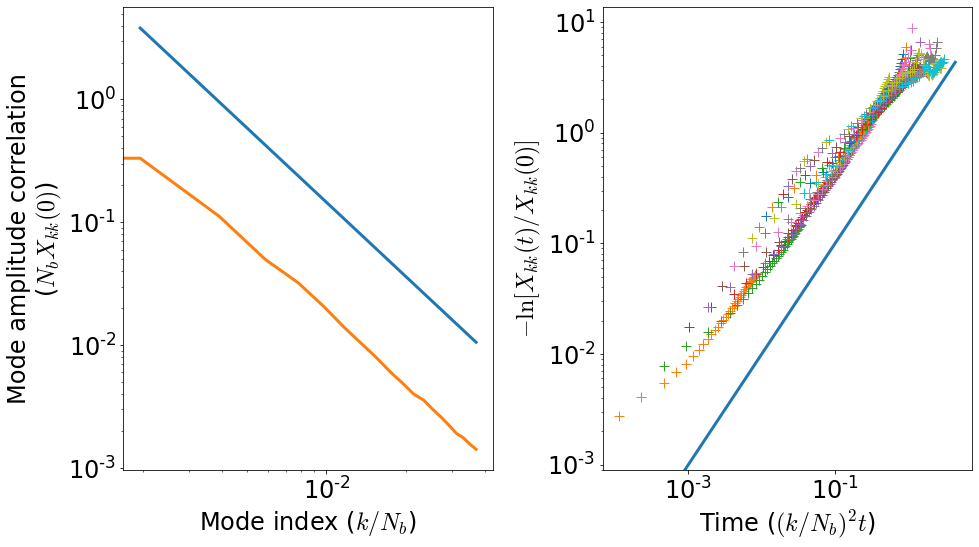

In [274]:
data_path = Path("21-05-05_AMchr1_RS_line512_lo0_kl36.50/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
fig0, ax0 = make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

## 512 RS $l_o=0, k_l=36.50, dt=.003$ line equil

<ipython-input-301-1b099708687c>:86: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e5)
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind

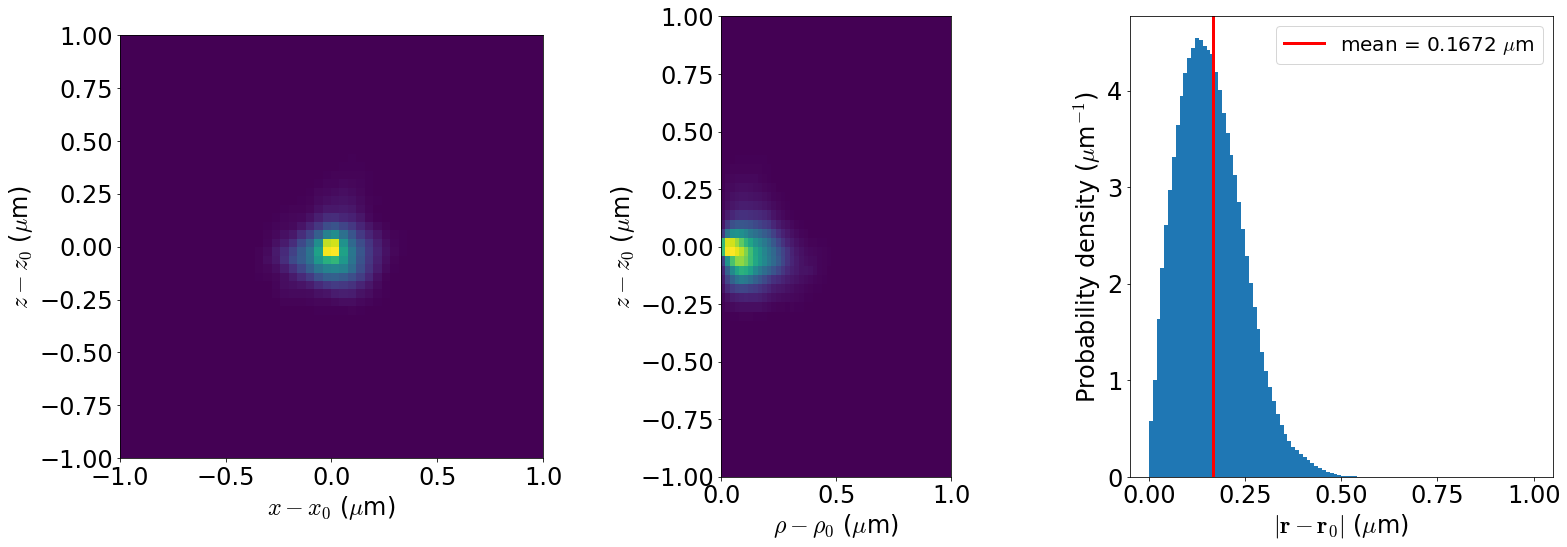

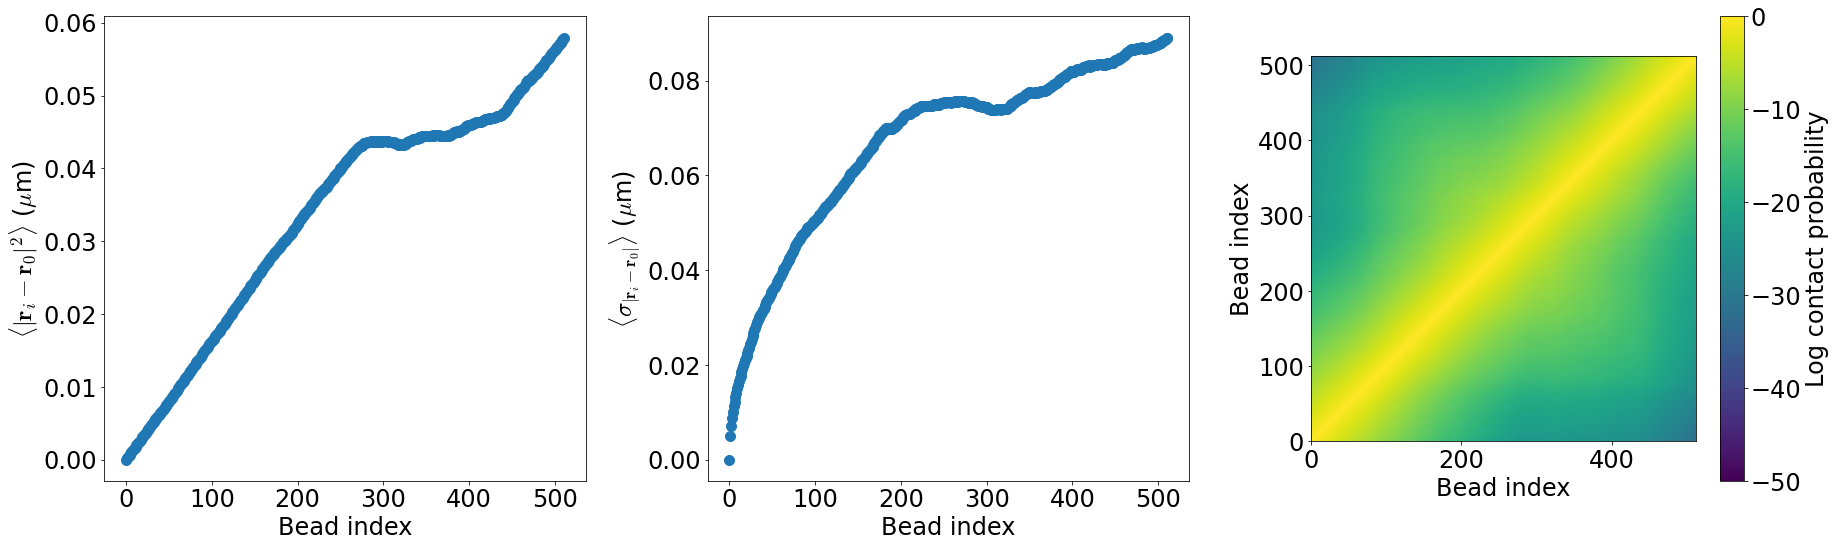

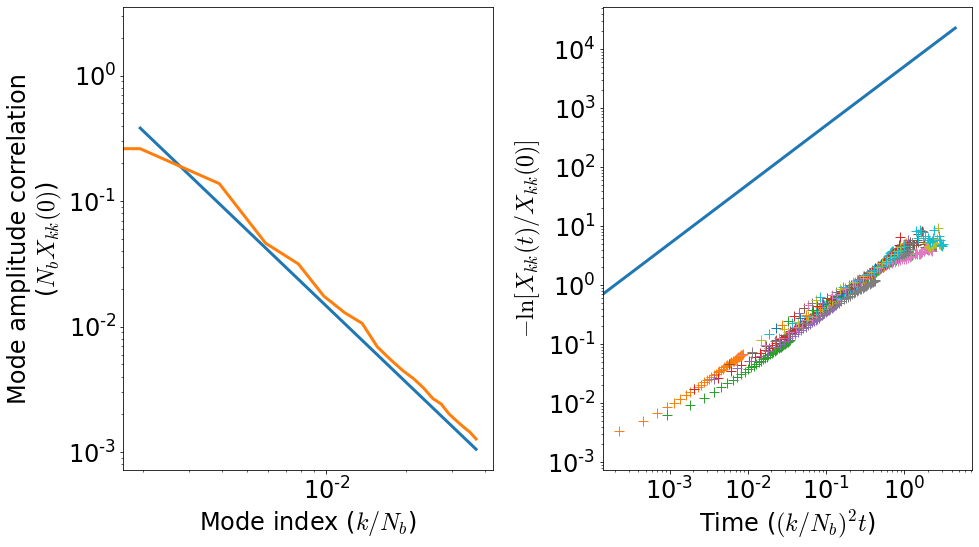

In [304]:
data_path = Path("21-05-05_AMchr1_RS_line512_lo0_kl36.50_dt.003/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    #mode_mat = get_rouse_modes(com_arr)

log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
fig0, ax0 = make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

## 512 RS $l_o=0, k_l=36.50, dt=.0001, \eta=1.0$ line equil

<ipython-input-301-1b099708687c>:86: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e5)
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind

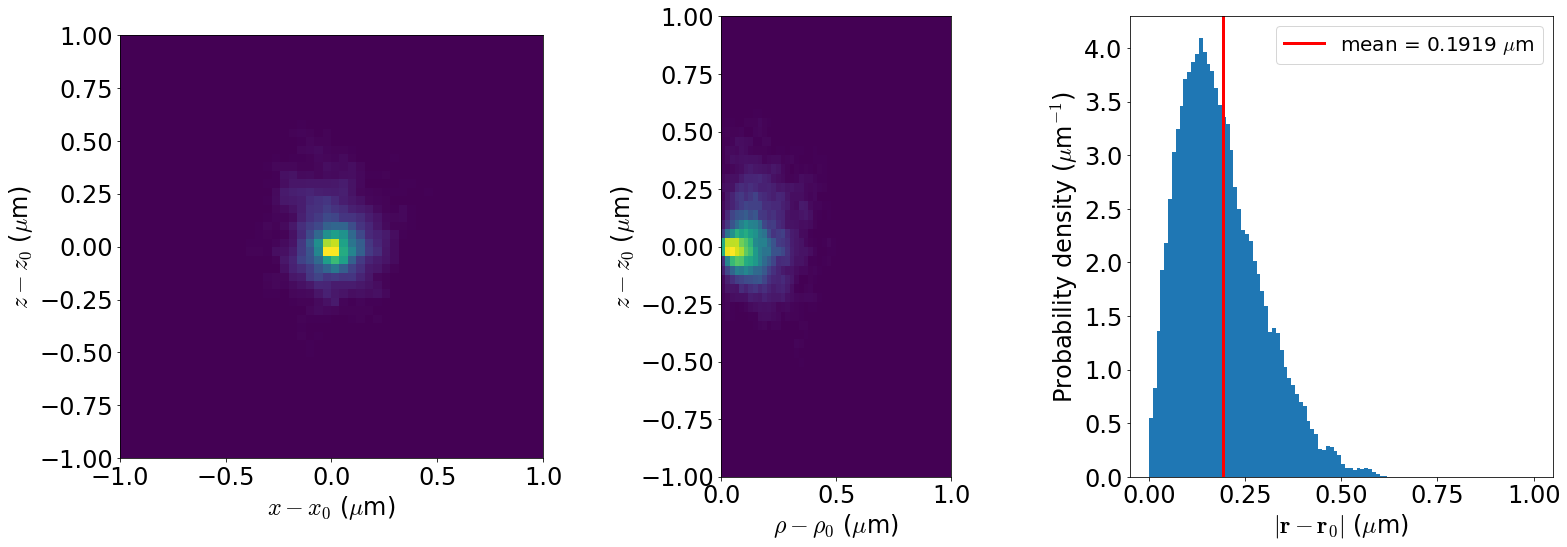

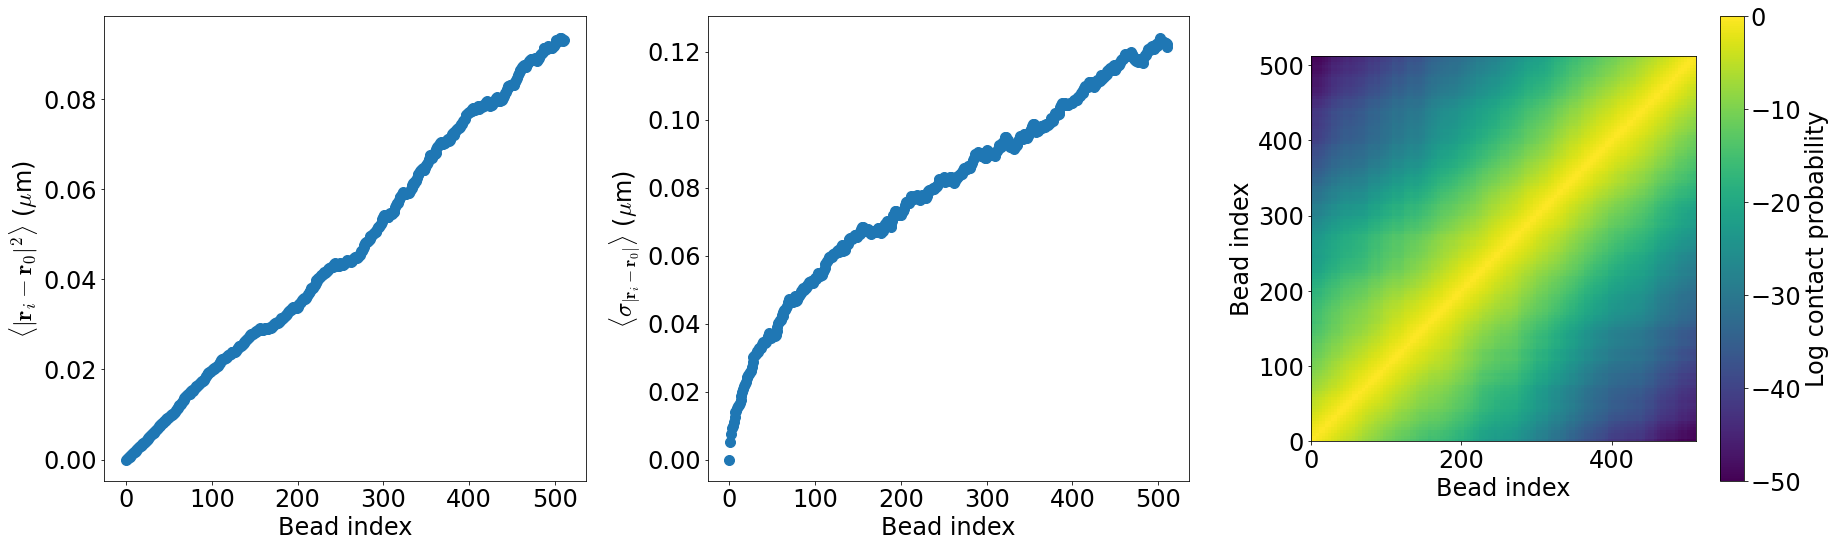

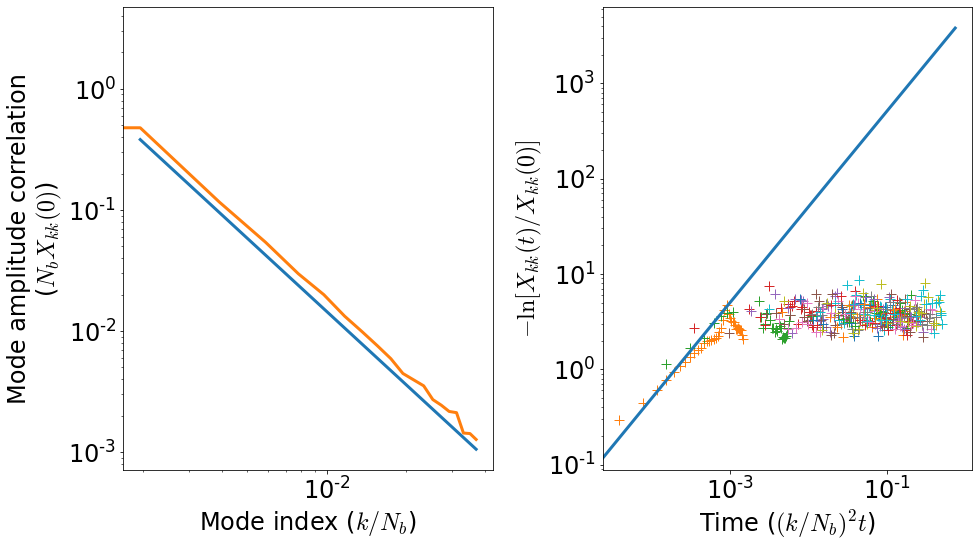

In [303]:
data_path = Path("21-05-11_AMchr1_RS_line512eq_lo0_kl36.50_visc1.0/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    #mode_mat = get_rouse_modes(com_arr)

log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
fig0, ax0 = make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=40)

## 512 RS $l_o=0, k_l=36.50, dt=.0001, \eta=1.0, ts=.1$ line equil

<ipython-input-301-1b099708687c>:86: RuntimeWarning: divide by zero encountered in power
  ax[0].loglog(mode_arr / nbeads, np.power(nbeads * mode_arr, -2.) * 1e5)
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind] / mode_corr[k, 0]), '+')
<ipython-input-301-1b099708687c>:91: RuntimeWarning: invalid value encountered in log
  -np.log(mode_corr[k, :max_ind

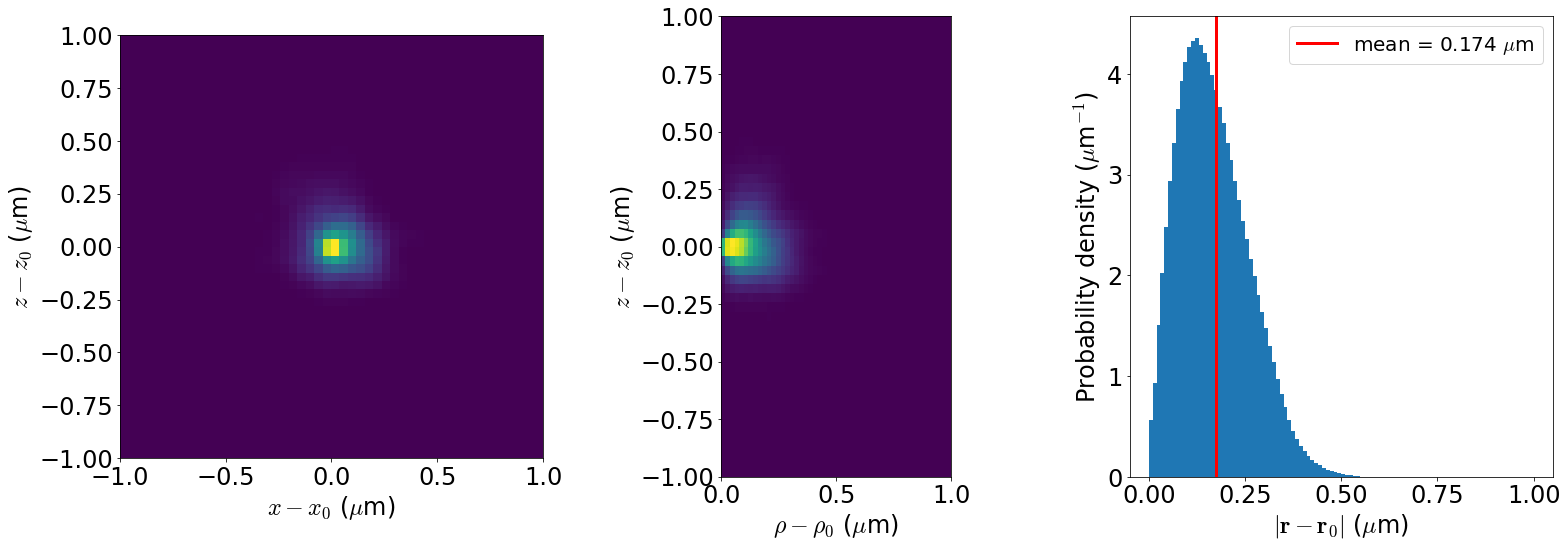

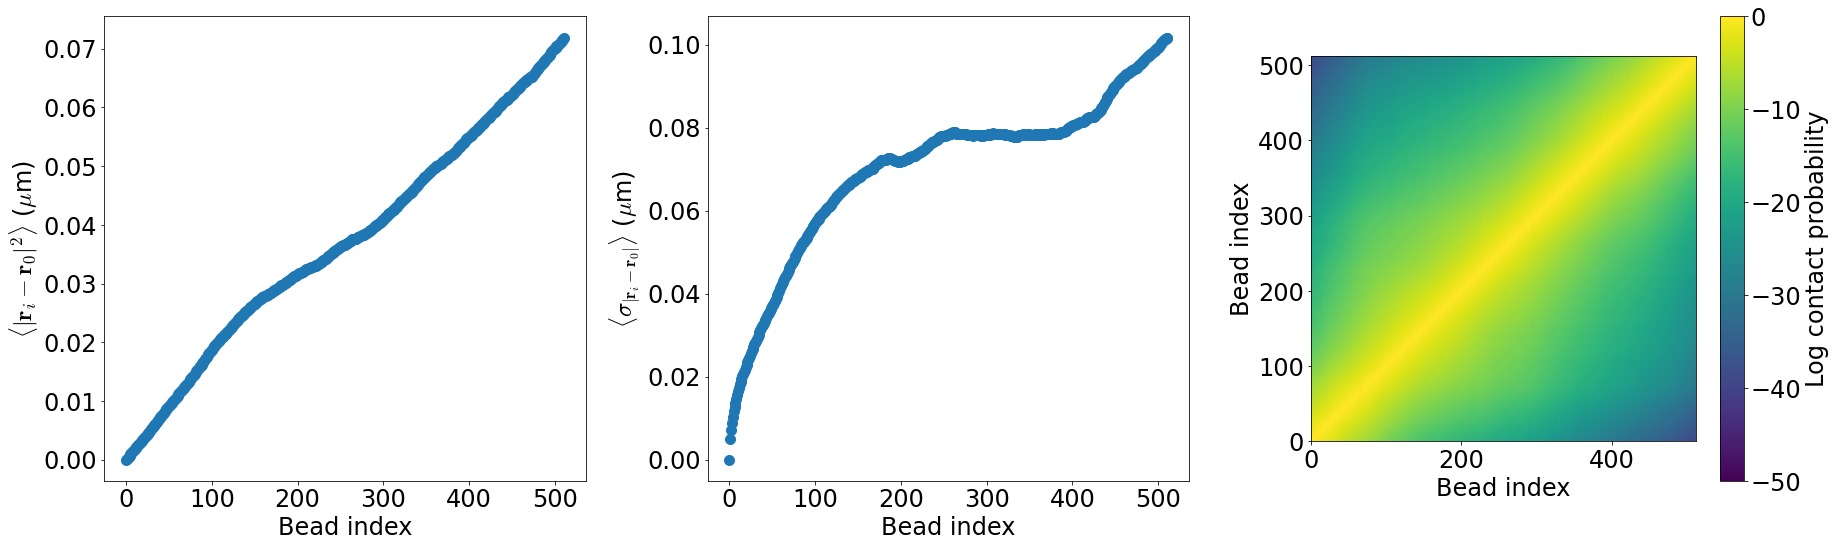

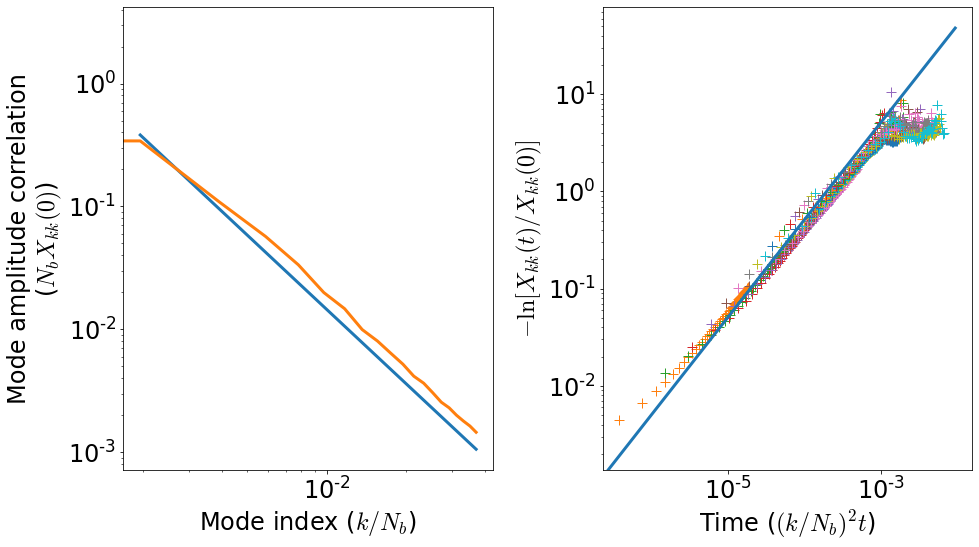

In [302]:
data_path = Path("21-05-12_AMchr1_RS_line512eq_lo0_kl36.50_visc1.0_ts.1/")
ss_ind = 0
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:]
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    nbeads = com_arr.shape[0]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    #mode_mat = get_rouse_modes(com_arr)

log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
mode_mat = get_rouse_modes(com_arr)

# Graphing
fig0, ax0 = make_segment_distr_graphs(com_arr, [], [0,1], 1,2)
fig1, ax1 = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=0, hist_max=1.)
fig2, ax2 = make_rouse_analysis_plots(time_arr, mode_mat, nbeads, max_ind=50)

# Conclusions and Next Steps

# Old

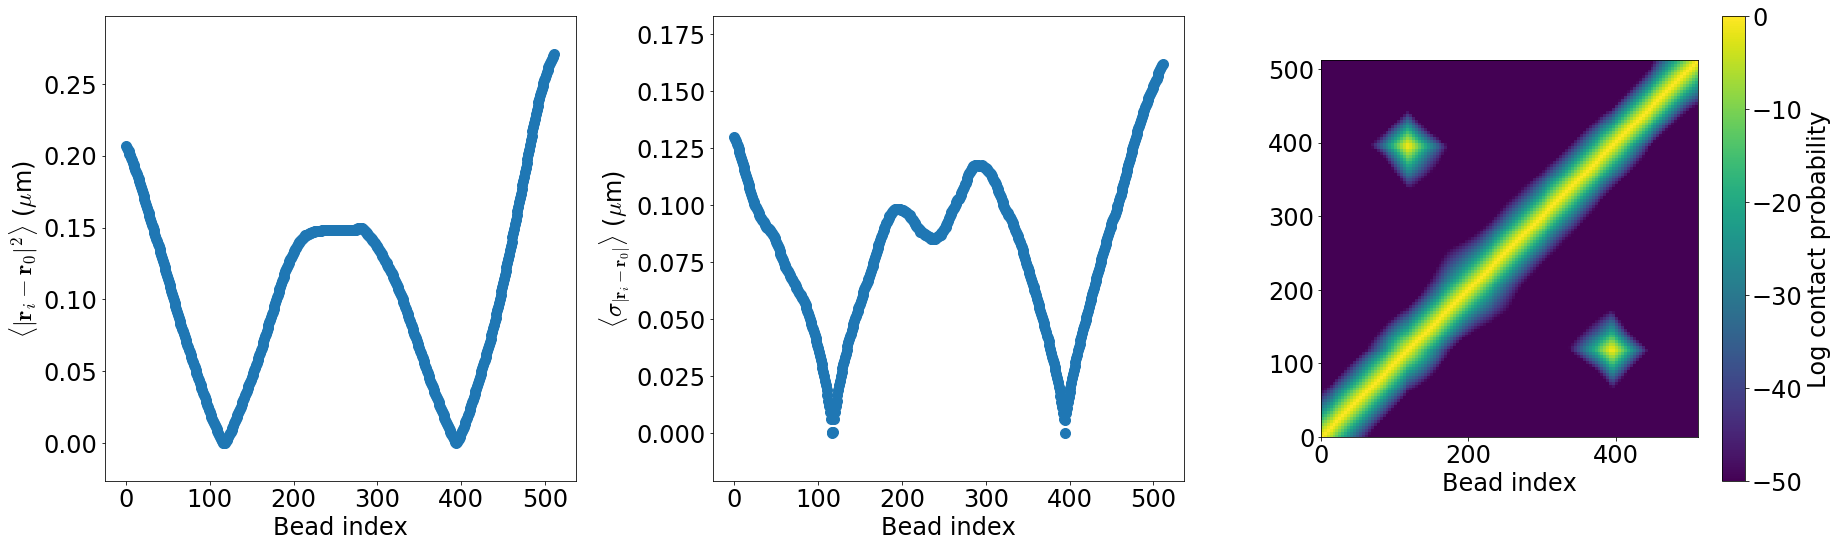

In [292]:
h5_data_paths = Path("21-04-14_AMchr1_looptails512-117-394eq_scan.6_50hr/simulations/").glob('s*/*.h5')
com_arr = None
ss_ind = 0
for h5_path in h5_data_paths:
    with h5py.File(h5_path, 'r+') as h5_data:
        sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
        if not isinstance(com_arr,np.ndarray):
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            continue
        com_arr = np.append(com_arr, .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :]), axis=-1)
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)

fig, ax = make_min_distr_plots(com_arr, log_contact_avg_mat, rel_ind=117, hist_max=1.)